## Benchmarking using SemHash on NLU Evaluation Corpora

This notebook benchmarks the results on the 3 NLU Evaluation Corpora:
1. Ask Ubuntu Corpus
2. Chatbot Corpus
3. Web Application Corpus


More information about the dataset is available here: 

https://github.com/sebischair/NLU-Evaluation-Corpora


* Semantic Hashing is used as a featurizer. The idea is taken from the paper:

https://www.microsoft.com/en-us/research/publication/learning-deep-structured-semantic-models-for-web-search-using-clickthrough-data/

* Benchmarks are performed on the same train and test datasets used by the other benchmarks performed in the past. One important paper that benchmarks the datasets mentioned above on some important platforms (Dialogflow, Luis, Watson and RASA) is : 

http://workshop.colips.org/wochat/@sigdial2017/documents/SIGDIAL22.pdf

* Furthermore, Botfuel made another benchmarks with more platforms (Recast, Snips and their own) and results can be found here: 

https://github.com/Botfuel/benchmark-nlp-2018

* The blogposts about the benchmarks done in the past are available at : 

https://medium.com/botfuel/benchmarking-intent-classification-services-june-2018-eb8684a1e55f

https://medium.com/snips-ai/an-introduction-to-snips-nlu-the-open-source-library-behind-snips-embedded-voice-platform-b12b1a60a41a

* To be very fair on our benchmarks and results, we used the same train and test set used by the other benchmarks and no cross validation or stratified splits were used. The test data was not used in any way to improve the results. The dataset used can be found here:

https://github.com/Botfuel/benchmark-nlp-2018/tree/master/results



In [1]:
%matplotlib inline
# import os
# os.environ['LDFLAGS'] = '-framework CoreFoundation -framework SystemConfiguration'
# !pip3 install spacy
import sys
print(sys.path)

for i in range(1,4):
    print(i)

['C:\\Users\\pedalo\\AppData\\Local\\Continuum\\anaconda3\\python36.zip', 'C:\\Users\\pedalo\\AppData\\Local\\Continuum\\anaconda3\\DLLs', 'C:\\Users\\pedalo\\AppData\\Local\\Continuum\\anaconda3\\lib', 'C:\\Users\\pedalo\\AppData\\Local\\Continuum\\anaconda3', '', 'C:\\Users\\pedalo\\AppData\\Roaming\\Python\\Python36\\site-packages', 'C:\\Users\\pedalo\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages', 'C:\\Users\\pedalo\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\win32', 'C:\\Users\\pedalo\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\Users\\pedalo\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\Users\\pedalo\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\pedalo\\.ipython']
1
2
3


In [2]:
#coding: utf-8
from __future__ import unicode_literals
import re
import os
import codecs
import json
import csv
import spacy
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn import model_selection
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors.nearest_centroid import NearestCentroid
import math
import random
from tqdm import tqdm
from nltk.corpus import wordnet
import timeit
import gc
from timeit import default_timer as timer

# import locale
# print(locale.getlocale())


Spacy english dataset with vectors needs to be present. It can be downloaded using the following command:

python -m spacy download en_core_web_lg

In [3]:
import spacy
# !python -m spacy download en_core_web_lg
nlp=spacy.load('en_core_web_lg')


In [4]:
nouns = {x.name().split('.', 1)[0] for x in wordnet.all_synsets('n')}
verbs = {x.name().split('.', 1)[0] for x in wordnet.all_synsets('v')}

def get_synonyms(word, number= 3):
    synonyms = []
    for syn in wordnet.synsets(word): 
        for l in syn.lemmas(): 
            synonyms.append(l.name().lower().replace("_", " "))
    synonyms = list(OrderedDict.fromkeys(synonyms))
    return synonyms[:number]
    #return [token.text for token in most_similar(nlp.vocab[word])]

In [5]:
print(get_synonyms("search",-1))

['search', 'hunt', 'hunting', 'lookup', 'seek', 'look for', 'look', 'research']


In [6]:
#Hyperparameters
benchmark_dataset = 'AskUbuntu' # Choose from 'AskUbuntu', 'Chatbot' or 'WebApplication'
oversample = True             # Whether to oversample small classes or not. True in the paper
synonym_extra_samples = True # Whether to replace words by synonyms in the oversampled samples. True in the paper
augment_extra_samples = False  # Whether to add random spelling mistakes in the oversampled samples. False in the paper
additional_synonyms = 0       # How many extra synonym augmented sentences to add for each sentence. 0 in the paper
additional_augments = 0       # How many extra spelling mistake augmented sentences to add for each sentence. 0 in the paper
mistake_distance = 2.1        # How far away on the keyboard a mistake can be


In [7]:
if benchmark_dataset == "Chatbot":
    intent_dict = {"DepartureTime":0, "FindConnection":1}
elif benchmark_dataset == "AskUbuntu":
    intent_dict = {"Make Update":0, "Setup Printer":1, "Shutdown Computer":2, "Software Recommendation":3, "None":4}
elif benchmark_dataset == "WebApplication":
    intent_dict = {"Download Video":0, "Change Password":1, "None":2, "Export Data":3, "Sync Accounts":4,
                  "Filter Spam":5, "Find Alternative":6, "Delete Account":7}

In [8]:
filename_train = "datasets/KL/" + benchmark_dataset + "/train.csv"
filename_test = "datasets/KL/" + benchmark_dataset + "/test.csv"

HD_vec_N = []
HD_vec_acc = []
HD_time = []
HD_f1 = []

In [9]:
def read_CSV_datafile(filename):    
    X = []
    y = []
    with open(filename,'r') as csvfile:
        reader = csv.reader(csvfile, delimiter='\t')
        for row in reader:
            X.append(row[0])
            if benchmark_dataset == 'AskUbuntu':
                 y.append(intent_dict[row[1]])
            elif benchmark_dataset == 'Chatbot':
                y.append(intent_dict[row[1]])
            else:
                y.append(intent_dict[row[1]])           
    return X,y


In [10]:
def tokenize(doc):
    """
    Returns a list of strings containing each token in `sentence`
    """
    #return [i for i in re.split(r"([-.\"',:? !\$#@~()*&\^%;\[\]/\\\+<>\n=])",
    #                            doc) if i != '' and i != ' ' and i != '\n']
    tokens = []
    doc = nlp.tokenizer(doc)
    for token in doc:
        tokens.append(token.text)
    return tokens



In [11]:
def preprocess(doc):
    clean_tokens = []
    doc = nlp(doc)
    for token in doc:
        if not token.is_stop:
            clean_tokens.append(token.lemma_)
    return " ".join(clean_tokens)

In [12]:
#********* Data augmentation part **************
class MeraDataset():
    """ Class to find typos based on the keyboard distribution, for QWERTY style keyboards
    
        It's the actual test set as defined in the paper that we comparing against."""

    def __init__(self, dataset_path):
        """ Instantiate the object.
            @param: dataset_path The directory which contains the data set."""
        self.dataset_path = dataset_path
        self.X_test, self.y_test, self.X_train, self.y_train = self.load()
        self.keyboard_cartesian = {'q': {'x': 0, 'y': 0}, 'w': {'x': 1, 'y': 0}, 'e': {'x': 2, 'y': 0},
                                   'r': {'x': 3, 'y': 0}, 't': {'x': 4, 'y': 0}, 'y': {'x': 5, 'y': 0},
                                   'u': {'x': 6, 'y': 0}, 'i': {'x': 7, 'y': 0}, 'o': {'x': 8, 'y': 0},
                                   'p': {'x': 9, 'y': 0}, 'a': {'x': 0, 'y': 1}, 'z': {'x': 0, 'y': 2},
                                   's': {'x': 1, 'y': 1}, 'x': {'x': 1, 'y': 2}, 'd': {'x': 2, 'y': 1},
                                   'c': {'x': 2, 'y': 2}, 'f': {'x': 3, 'y': 1}, 'b': {'x': 4, 'y': 2},
                                   'm': {'x': 6, 'y': 2}, 'j': {'x': 6, 'y': 1}, 'g': {'x': 4, 'y': 1},
                                   'h': {'x': 5, 'y': 1}, 'j': {'x': 6, 'y': 1}, 'k': {'x': 7, 'y': 1},
                                   'l': {'x': 8, 'y': 1}, 'v': {'x': 3, 'y': 2}, 'n': {'x': 5, 'y': 2},
                                   'ß': {'x': 10,'y': 2}, 'ü': {'x': 10,'y': 2}, 'ä': {'x': 10,'y': 0},
                                   'ö': {'x': 11,'y': 0}}
        self.nearest_to_i = self.get_nearest_to_i(self.keyboard_cartesian)
        self.splits = self.stratified_split()


    def get_nearest_to_i(self, keyboard_cartesian):
        """ Get the nearest key to the one read.
            @params: keyboard_cartesian The layout of the QWERTY keyboard for English
            
            return dictionary of eaculidean distances for the characters"""
        nearest_to_i = {}
        for i in keyboard_cartesian.keys():
            nearest_to_i[i] = []
            for j in keyboard_cartesian.keys():
                if self._euclidean_distance(i, j) < mistake_distance: #was > 1.2
                    nearest_to_i[i].append(j)
        return nearest_to_i

    def _shuffle_word(self, word, cutoff=0.7):
        """ Rearange the given characters in a word simulating typos given a probability.
        
            @param: word A single word coming from a sentence
            @param: cutoff The cutoff probability to make a change (default 0.9)
            
            return The word rearranged 
            """
        word = list(word.lower())
        if random.uniform(0, 1.0) > cutoff:
            loc = np.random.randint(0, len(word))
            if word[loc] in self.keyboard_cartesian:
                word[loc] = random.choice(self.nearest_to_i[word[loc]])
        return ''.join(word)

    def _euclidean_distance(self, a, b):
        """ Calculates the euclidean between 2 points in the keyboard
            @param: a Point one 
            @param: b Point two
            
            return The euclidean distance between the two points"""
        X = (self.keyboard_cartesian[a]['x'] - self.keyboard_cartesian[b]['x']) ** 2
        Y = (self.keyboard_cartesian[a]['y'] - self.keyboard_cartesian[b]['y']) ** 2
        return math.sqrt(X + Y)

    def _get_augment_sentence(self, sentence):
        return ' '.join([self._shuffle_word(item) for item in sentence.split(' ')])
    
    def _augment_sentence(self, sentence, num_samples):
        """ Augment the dataset of file with a sentence shuffled
            @param: sentence The sentence from the set
            @param: num_samples The number of sentences to genererate
            
            return A set of augmented sentences"""
        sentences = []
        for _ in range(num_samples):
            sentences.append(self._get_augment_sentence(sentence))
        sentences = list(set(sentences))
        # print("sentences", sentences)
        return sentences + [sentence]

    def _augment_split(self, X_train, y_train, num_samples=100):
        """ Split the augmented train dataset
            @param: X_train The full array of sentences
            @param: y_train The train labels in the train dataset
            @param: num_samples the number of new sentences to create (default 1000)
            
            return Augmented training dataset"""
        Xs, ys = [], []
        for X, y in zip(X_train, y_train):
            tmp_x = self._augment_sentence(X, num_samples)
            sample = [[Xs.append(item), ys.append(y)] for item in tmp_x]
#             print(X, y)
#             print(self.augmentedFile+str(self.nSamples)+".csv")
            
        with open(self.augmentedFile+str(self.nSamples)+"Train.csv", 'w', encoding='utf8') as csvFile:
            fileWriter = csv.writer(csvFile, delimiter='\t')
            for i in range(0, len(Xs)-1):
                fileWriter.writerow([Xs[i] + '\t' + ys[i]])
                # print(Xs[i], "\t", ys[i])
                # print(Xs[i])
            # fileWriter.writerows(Xs + ['\t'] + ys)
        return Xs, ys

    # Randomly replaces the nouns and verbs by synonyms
    def _synonym_word(self, word, cutoff=0.5):
        if random.uniform(0, 1.0) > cutoff and len(get_synonyms(word)) > 0 and word in nouns and word in verbs:
            return random.choice(get_synonyms(word))
        return word
    
    # Randomly replace words (nouns and verbs) in sentence by synonyms
    def _get_synonym_sentence(self, sentence, cutoff = 0.5):
        return ' '.join([self._synonym_word(item, cutoff) for item in sentence.split(' ')])

    # For all classes except the largest ones; add duplicate (possibly augmented) samples until all classes have the same size
    def _oversample_split(self, X_train, y_train, synonym_extra_samples = False, augment_extra_samples = False):
        """ Split the oversampled train dataset
            @param: X_train The full array of sentences
            @param: y_train The train labels in the train dataset
        
            return Oversampled training dataset"""
        
        classes = {}
        for X, y in zip(X_train, y_train):
            if y not in classes:
                classes[y] = []
            classes[y].append(X)
            
        max_class_size = max([len(entries) for entries in classes.values()])
        
        Xs, ys = [],[] 
        for y in classes.keys():
            for i in range(max_class_size):
                sentence = classes[y][i % len(classes[y])]
                if i >= len(classes[y]):
                    if synonym_extra_samples:
                        sentence = self._get_synonym_sentence(sentence)
                    if augment_extra_samples:
                        sentence = self._get_augment_sentence(sentence)
                Xs.append(sentence)
                ys.append(y)
                
        with open("./datasets/KL/Chatbot/train_augmented.csv", 'w', encoding='utf8') as csvFile:
            fileWriter = csv.writer(csvFile, delimiter='\t')
            for i in range(0, len(Xs)-1):
                fileWriter.writerow([Xs[i] + '\t' + ys[i]])
               
        return Xs, ys
    
    def _synonym_split(self, X_train, y_train, num_samples=100):
        """ Split the augmented train dataset
            @param: X_train The full array of sentences
            @param: y_train The train labels in the train dataset
            @param: num_samples the number of new sentences to create (default 1000)
            
            return Augmented training dataset"""
        Xs, ys = [], []
        for X, y in zip(X_train, y_train):
            sample = [[Xs.append(self._get_synonym_sentence(X)), ys.append(y)] for item in range(additional_synonyms)]
#             print(X, y)
            
        with open("./datasets/KL/Chatbot/train_augmented.csv", 'w', encoding='utf8') as csvFile:
            fileWriter = csv.writer(csvFile, delimiter='\t')
            for i in range(0, len(Xs)-1):
                fileWriter.writerow([Xs[i] + '\t' + ys[i]])
        return Xs, ys

    def load(self):
        """ Load the file for now only the test.csv, train.csv files hardcoded
        
            return The vector separated in test, train and the labels for each one"""
        with open(self.dataset_path) as csvfile:
            readCSV = csv.reader(csvfile, delimiter='	')
            all_rows = list(readCSV)
#             for i in all_rows:
#                 if i ==  28823:
#                     print(all_rows[i])
            X_test = [a[0] for a in all_rows]
            y_test = [a[1] for a in all_rows]

        with open(self.dataset_path) as csvfile:
            readCSV = csv.reader(csvfile, delimiter='\t')
            all_rows = list(readCSV)
            X_train = [a[0] for a in all_rows]
            y_train = [a[1] for a in all_rows]
        return X_test, y_test, X_train, y_train

    def process_sentence(self, x):
        """ Clean the tokens from stop words in a sentence.
            @param x Sentence to get rid of stop words.
            
            returns clean string sentence"""
        clean_tokens = []
        doc = nlp.tokenizer(x)
        for token in doc:
            if not token.is_stop:
                clean_tokens.append(token.lemma_)
        return " ".join(clean_tokens)

    def process_batch(self, X):
        """See the progress as is coming along.
        
            return list[] of clean sentences"""
        return [self.process_sentence(a) for a in tqdm(X)]

    def stratified_split(self):
        """ Split data whole into stratified test and training sets, then remove stop word from sentences
        
            return list of dictionaries with keys train,test and values the x and y for each one"""
        self.X_train, self.X_test = ([preprocess(sentence) for sentence in self.X_train],[preprocess(sentence) for sentence in self.X_test])
        print(self.X_train)
        if oversample:
            self.X_train, self.y_train = self._oversample_split(self.X_train, self.y_train, synonym_extra_samples, augment_extra_samples)
        if additional_synonyms > 0:
            self.X_train, self.y_train = self._synonym_split(self.X_train, self.y_train, additional_synonyms)
        if additional_augments > 0:
            self.X_train, self.y_train = self._augment_split(self.X_train, self.y_train, additional_augments)

        splits = [{"train": {"X": self.X_train, "y": self.y_train},
                   "test": {"X": self.X_test, "y": self.y_test}}]
        return splits

    def get_splits(self):
        """ Get the splitted sentences
            
            return splitted list of dictionaries"""
        return self.splits
#****************************************************


In [13]:
print("./datasets/KL/" + benchmark_dataset + "/train.csv")
dataset = MeraDataset("./datasets/KL/" + benchmark_dataset + "/train.csv")
print("mera****************************")
splits = dataset.get_splits()
xS_train = []
yS_train = []
for elem in splits[0]["train"]["X"]:
    xS_train.append(elem)
print(xS_train[:5])

for elem in splits[0]["train"]["y"]:
    yS_train.append(intent_dict[elem])
    
print(len(xS_train))


./datasets/KL/AskUbuntu/train.csv
['record screen ?', 'highlight annotate pdf ?', 'worth upgrade 12.04 LTS 13.04', 'upgrade 12.04 64 bit', 'upgrade Ubuntu 14.04.1 14.04.2 ?', 'upgrade Ubuntu 14.04 15.04', 'upgrade ubuntu 15.04 15.10 ?', 'upgrade 12.04 12.10 startup disk', 'upgrade 11.10 12.04 get problem ?', 'update 11.04 12.04 LiveCD', 'upgrade Ubuntu 9.10 12.10 terminal ?', 'upgrade Ubuntu 10.10 11.04 ?', 'matter Ubuntu 15.04 recognize HP LaserJet 1020', 'setup HP printer / scanner ubuntu ?', 'setup HP C4140 printer wirelessly ?', 'setup wireless printing printer connect usb Ubuntu Server 12.10 ?', 'install Pantum 2502w laser printer Ubuntu', 'install Canon MP560 Ubuntu 15.04', 'install Brother MFC-5890CN network printer ?', 'install driver Konica Minolta 200 ?', 'install driver Panasonic MB1900CX - - Printer / Scanner ?', 'install Canon LBP2900B printer 14.04 LTS ? try method LBP2900 not work', 'command line calculator Ubuntu ?', 'extract embed image pdf', 'use quickly cut Audio / v

In [14]:
X_train_raw, y_train_raw = read_CSV_datafile(filename = filename_train)
x_train_raw_clean = X_train_raw[:]
X_test_raw, y_test_raw = read_CSV_datafile(filename = filename_test)
x_test_raw_clean = X_test_raw[:]
print(y_train_raw[:5])

X_train_raw = xS_train
y_train_raw = yS_train
print(X_train_raw[:3])
x_train_raw_clean = xS_train[:]
print()

[4, 4, 0, 0, 0]
['record screen ?', 'highlight annotate pdf ?', 'Torrent client command - line ?']



In [15]:

print("Training data samples: \n",X_train_raw, "\n\n")
# print(f'Copy of train: {x_train_raw_clean}')
print("Class Labels: \n", y_train_raw, "\n\n")

print("Size of Training Data: {}".format(len(X_train_raw)))

Training data samples: 
 ['record screen ?', 'highlight annotate pdf ?', 'Torrent client command - line ?', 'record silver screen ?', 'highlight annotate pdf ?', 'Torrent client command - line ?', 'record screen ?', 'highlighting annotate pdf ?', 'Torrent client bidding - line ?', 'record screen ?', 'high spot annotate pdf ?', 'Torrent client command - line ?', 'record projection screen ?', 'high spot annotate pdf ?', 'Torrent client command - line ?', 'phonograph record screen ?', 'high spot annotate pdf ?', 'worth upgrade 12.04 LTS 13.04', 'upgrade 12.04 64 bit', 'upgrade Ubuntu 14.04.1 14.04.2 ?', 'upgrade Ubuntu 14.04 15.04', 'upgrade ubuntu 15.04 15.10 ?', 'upgrade 12.04 12.10 startup disk', 'upgrade 11.10 12.04 get problem ?', 'update 11.04 12.04 LiveCD', 'upgrade Ubuntu 9.10 12.10 terminal ?', 'upgrade Ubuntu 10.10 11.04 ?', 'worth acclivity 12.04 LTS 13.04', 'upgrade 12.04 64 bit', 'upgrade Ubuntu 14.04.1 14.04.2 ?', 'acclivity Ubuntu 14.04 15.04', 'acclivity ubuntu 15.04 15.10

# SemHash

In [16]:
def find_ngrams(input_list, n):
    return zip(*[input_list[i:] for i in range(n)])

def semhash_tokenizer(text):
    tokens = text.split(" ")
    final_tokens = []
    for unhashed_token in tokens:
        hashed_token = "#{}#".format(unhashed_token)
        final_tokens += [''.join(gram)
                         for gram in list(find_ngrams(list(hashed_token), 3))]
    return final_tokens

def semhash_corpus(corpus):
    new_corpus = []
    for sentence in corpus:
        sentence = preprocess(sentence)
        tokens = semhash_tokenizer(sentence)
        new_corpus.append(" ".join(map(str,tokens)))
    return new_corpus

# %%time
start = timer()
X_train_raw_no_HD = semhash_corpus(X_train_raw)
X_test_raw_no_HD = semhash_corpus(X_test_raw)
end = timer()

print("Time taken:", end-start, start, end) 

# print(timeit.Timer("for x in range(100): semhash_corpus(X_train_raw)", "gc.enable()").timeit())

Time taken: 1.183902941137968 0.0 1.183902941137968


In [17]:
print(X_train_raw[:5])
print(y_train_raw[:5])
# print(timeit.Timer("for x in range(10): print(x); semhash_corpus(X_train_raw)", "gc.enable(); from __main__ import semhash_corpus, X_train_raw").timeit())

['record screen ?', 'highlight annotate pdf ?', 'Torrent client command - line ?', 'record silver screen ?', 'highlight annotate pdf ?']
[4, 4, 4, 4, 4]


In [18]:
def get_vectorizer(corpus, preprocessor=None, tokenizer=None):
    vectorizer = CountVectorizer(ngram_range=(2,4),analyzer='char')
    vectorizer.fit(corpus)
    return vectorizer, vectorizer.get_feature_names()

In [19]:
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [20]:





def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


# #############################################################################
# Benchmark classifiers
def benchmark(clf, X_train, y_train, X_test, y_test, target_names,
              print_report=True, feature_names=None, print_top10=False,
              print_cm=True):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    f1_score = metrics.f1_score(y_test, pred, average='weighted')
    
    print("accuracy:   %0.3f" % score)
    #print("Accuracy: %0.3f (+/- %0.3f)" % (score.mean(), score.std() * 2))

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(["Make Update", "Setup Printer", "Shutdown Computer","Software Recommendation", "None"]):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join([feature_names[i] for i in top10]))))
        print()

    if print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,labels = range(len(target_names)),
                                            target_names=target_names))

    if print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))
    
    with open("./results.csv", 'a', encoding='utf8') as csvFile:
        fileWriter = csv.writer(csvFile, delimiter='\t')
        fileWriter.writerow([benchmark_dataset,str(clf),str(oversample),str(synonym_extra_samples),str(augment_extra_samples),
                             str(additional_synonyms),str(additional_augments), str(mistake_distance), str(score), str(f1_score)])

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time, f1_score

In [21]:
def plot_results(results):
    # make some plots
    indices = np.arange(len(results))

    results = [[x[i] for x in results] for i in range(4)]

    clf_names, score, training_time, test_time = results
    training_time = np.array(training_time) / np.max(training_time)
    test_time = np.array(test_time) / np.max(test_time)

    plt.figure(figsize=(12, 8))
    plt.title("Score")
    plt.barh(indices, score, .2, label="score", color='navy')
    plt.barh(indices + .3, training_time, .2, label="training time",
             color='c')
    plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)

    plt.show()

In [22]:
def data_for_training():
#     start = timer()
    X_train_raw_no_HD = semhash_corpus(X_train_raw)
    X_test_raw_no_HD = semhash_corpus(X_test_raw)
# end = timer()

# print("Time taken:", end-start, start, end) 
    vectorizer, feature_names = get_vectorizer(X_train_raw_no_HD, preprocessor=preprocess, tokenizer=tokenize)
    
    X_train_no_HD = vectorizer.transform(X_train_raw_no_HD).toarray()
    X_test_no_HD = vectorizer.transform(X_test_raw_no_HD).toarray()
            
    return X_train_no_HD, y_train_raw, X_test_no_HD, y_test_raw, feature_names



In [23]:
# X_train_no_HD, y_train, X_test_no_HD, y_test, feature_names = data_for_training()
semHash_vec_time = []
for i in range(20):
    start = timer()
# X_train_raw_no_HD = semhash_corpus(X_train_raw)
# X_test_raw_no_HD = semhash_corpus(X_test_raw)
    X_train, y_train, X_test, y_test, feature_names = data_for_training()
    end = timer()

    print("Time taken:", end-start, start, end)
    semHash_vec_time.append((end-start))
#     X_train, y_train, X_test, y_test, feature_names = data_for_training()

print(len(semHash_vec_time))

Time taken: 1.2582699353842735 2.4496182062457184 3.707888141629992
Time taken: 1.28676155793379 3.7115109277522773 4.998272485686067
Time taken: 1.2025603866373888 5.001699393115445 6.204259779752834
Time taken: 1.2236280127864179 6.207548020582778 7.431176033369196
Time taken: 1.2640517507627882 7.434409001498666 8.698460752261454
Time taken: 1.2346127347332185 8.70155505379149 9.936167788524708
Time taken: 1.1921953007537933 9.940088271472353 11.132283572226147
Time taken: 1.1711281594530139 11.135407934347668 12.306536093800682
Time taken: 1.2627145392899202 12.309868940669604 13.572583479959524
Time taken: 1.3197166934706939 13.576466629591938 14.896183323062631
Time taken: 1.3060837303836461 14.900195927177732 16.206279657561378
Time taken: 1.338140926961973 16.209918443675907 17.54805937063788
Time taken: 1.3163760890297773 17.552252823150145 18.868628912179922
Time taken: 1.2870873759576362 18.871810971243164 20.1588983472008
Time taken: 1.2869836184321848 20.161951921477858 21

In [24]:
#fix for n=1gram*********************************
def ngram_encode(str_test, HD_aphabet, aphabet, n_size): # method for mapping n-gram statistics of a word to an N-dimensional HD vector
    HD_ngram = np.zeros(HD_aphabet.shape[1]) # will store n-gram statistics mapped to HD vector
    full_str = '#' + str_test + '#' # include extra symbols to the string
    
    if len(full_str) < n_size: 
        raise Warning("String is less than n-gram size")
    
    #adjust the string for n-gram size
    if n_size == 1:
        full_str_e=full_str            
    else:
        full_str_e=full_str[:-(n_size-1)]    
        
    for il, l in enumerate(full_str_e): # loops through all n-grams
        hdgram = HD_aphabet[aphabet.find(full_str[il]), :] # picks HD vector for the first symbol in the current n-gram
        
        for ng in range(1, n_size): #loops through the rest of symbols in the current n-gram
                hdgram = hdgram * np.roll(HD_aphabet[aphabet.find(full_str[il+ng]), :], ng) # two operations simultaneously; binding via elementvise multiplication; rotation via cyclic shift

        HD_ngram += hdgram # increments HD vector of n-gram statistics with the HD vector for the currently observed n-gram

    HD_ngram_norm = np.sqrt(HD_aphabet.shape[1]) * (HD_ngram/ np.linalg.norm(HD_ngram) )  # normalizes HD-vector so that its norm equals sqrt(N)       
    return HD_ngram_norm # output normalized HD mapping



# N = 1000 # set the desired dimensionality of HD vectors
# n_size=3 # n-gram size
# aphabet = 'abcdefghijklmnopqrstuvwxyz#' #fix the alphabet. Note, we assume that capital letters are not in use 
# np.random.seed(1) # for reproducibility
# HD_aphabet = 2 * (np.random.randn(len(aphabet), N) < 0) - 1 # generates bipolar {-1, +1}^N HD vectors; one random HD vector per symbol in the alphabet

# str='jump' # example string to represent using n-grams
# HD_ngram = ngram_encode(str, HD_aphabet, aphabet, n_size) # HD_ngram is a projection of n-gram statistics for str to N-dimensional space. It can be used to learn the word embedding
# #***************************************************************


#     X_train, y_train, X_test, y_test, feature_names = data_for_training()
# def ngram_encode(str_test, HD_aphabet, aphabet, n_size): # method for mapping n-gram statistics of a word to an N-dimensional HD vector
#     HD_ngram = np.zeros(HD_aphabet.shape[1]) # will store n-gram statistics mapped to HD vector
#     full_str = '#' + str_test + '#' # include extra symbols to the string
        
#     for il, l in enumerate(full_str[:-(n_size-1)]): # loops through all n-grams
#         hdgram = HD_aphabet[aphabet.find(full_str[il]), :] # picks HD vector for the first symbol in the current n-gram
# #         print(aphabet.find(full_str[il]), full_str[il])
#         for ng in range(1, n_size): #loops through the rest of symbols in the current n-gram
#             hdgram = hdgram * np.roll(HD_aphabet[aphabet.find(full_str[il+ng]), :], ng) # two operations simultaneously; binding via elementvise multiplication; rotation via cyclic shift
            
#         HD_ngram += hdgram # increments HD vector of n-gram statistics with the HD vector for the currently observed n-gram
    
#     HD_ngram_norm = np.sqrt(HD_aphabet.shape[1]) * (HD_ngram/ np.linalg.norm(HD_ngram) )  # normalizes HD-vector so that its norm equals sqrt(N)       
#     return HD_ngram_norm # output normalized HD mapping



N = 1000 # set the desired dimensionality of HD vectors
n_size=3 # n-gram size
aphabet = 'abcdefghijklmnopqrstuvwxyz# ?-/!\+[]{}().,:;1234567890äöÿã' #fix the alphabet. Note, we assume that capital letters are not in use 
np.random.seed(1) # for reproducibility
HD_aphabet = 2 * (np.random.randn(len(aphabet), N) < 0) - 1 # generates bipolar {-1, +1}^N HD vectors; one random HD vector per symbol in the alphabet

str_test='High like a basketball jump'.lower() # example string to represent using n-grams

print(ngram_encode(str_test, HD_aphabet, aphabet, n_size)) # HD_ngram is a projection of n-gram statistics for str to N-dimensional space. It can be used to learn the word embedding
# print(X_train_raw[:5])
start = timer()
# for i in range(len(X_train_raw)):
#      X_train_raw[i] = ngram_encode(X_train_raw[i], HD_aphabet, aphabet, n_size) # HD_ngram is a projection of n-gram statistics for str to N-dimensional space. It can be used to learn the word embedding
# # print(X_train_raw[:5])
# for i in range(len(X_test_raw)):
#     X_test_raw[i] = ngram_encode(X_test_raw[i], HD_aphabet, aphabet, n_size)
# print(X_test_raw[:5])
end = timer()
print("Time taken:", end-start)
HD_time.append(end-start)
HD_vec_N.append(n_size)

# print(print(timeit.Timer("for x in range(100): ngram_encode(X_train_raw[i], HD_aphabet, aphabet, n_size)", "gc.enable();  from __main__ import semhash_corpus, X_train_raw").timeit()))

# X_train, y_train, X_test, y_test = X_train_raw, y_train_raw, X_test_raw, y_test_raw
# print(X_train[:5])

# print(timeit.Timer("for x in range(10): for i in range(len(X_train_raw)): ngram_encode(X_train_raw[i], HD_aphabet, aphabet, n_size)", "gc.enable();  from __main__ import ngram_encode, X_train_raw, HD_alphabet, n_size").timeit())


[-0.9378371  -1.68810677 -0.18756742  0.56270226  2.06324161  1.68810677
  0.56270226  0.18756742 -0.18756742  0.56270226 -0.18756742 -0.18756742
  2.06324161 -0.9378371   0.18756742  1.68810677 -0.56270226  0.9378371
 -0.9378371   0.9378371  -0.18756742 -0.56270226 -0.18756742  0.18756742
  0.18756742 -1.31297193 -0.9378371  -0.56270226 -1.31297193 -1.31297193
 -0.56270226  0.56270226 -0.18756742  0.18756742  2.43837645  0.9378371
  0.18756742  0.18756742 -1.31297193  2.06324161  0.56270226 -0.18756742
  0.9378371  -0.9378371  -0.18756742 -2.06324161 -0.18756742 -2.06324161
 -0.9378371   0.56270226  1.31297193 -1.31297193  1.68810677  0.56270226
 -1.68810677  1.31297193 -0.18756742 -0.9378371   0.56270226  0.56270226
 -0.18756742  0.18756742 -0.9378371  -0.18756742  0.56270226  0.18756742
  0.56270226 -0.18756742  0.56270226 -0.56270226  0.18756742 -0.56270226
  3.56378096  0.56270226  0.18756742  0.18756742 -0.18756742 -0.18756742
  1.68810677  1.68810677 -0.9378371  -1.68810677  1.3

 -2.06324161 -0.18756742  0.9378371  -0.56270226]
Time taken: 3.2484832733103985e-05


In [25]:
# print(X_train_raw[:3])
print(f'Lists data: {HD_time, HD_vec_N}')
X_train_raw = x_train_raw_clean
print(X_train_raw[:3])

Lists data: ([3.2484832733103985e-05], [3])
['record screen ?', 'highlight annotate pdf ?', 'Torrent client command - line ?']


In [26]:
semHash_time_train = []
semHash_time_test = []
semHash_f1 = []
semHash_acc = []
for i in range(10):
#     print(X_train)
    print(i)

0
1
2
3
4
5
6
7
8
9


Evaluating Split 0
gridsearchRF
________________________________________________________________________________
Training: 
GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000900,
            n_jobs=None, oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 60, 70], 'min_samples_leaf': [1, 11]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


train time: 1.370s
test time:  0.005s
accuracy:   0.908
classification report:
                         precision    recall  f1-score   support

            Make Update       0.93      1.00      0.96        37
          Setup Printer       1.00      0.92      0.96        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.86      0.90      0.88        40
                   None       0.00      0.00      0.00         5

              micro avg       0.91      0.91      0.91       109
              macro avg       0.76      0.76      0.76       109
           weighted avg       0.88      0.91      0.89       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 12  0  1  0]
 [ 0  0 14  0  0]
 [ 3  0  0 36  1]
 [ 0  0  0  5  0]]

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.109s
test time:  0.002s
accuracy:   0.853
dimensionality: 3748
density: 0.460032

classification report:
                         precision    recall  f1-score   support

            Make Update       0.94      0.92      0.93        37
          Setup Printer       0.93      1.00      0.96        13
      Shutdown Computer       0.88      1.00      0.93        14
Software Recommendation       0.88      0.70      0.78        40
                   None       0.36      0.80      0.50         5

              micro avg       0.85      0.85      0.85       109
              macro avg       0.80      0.88      0.82       109
           weighted avg       0.88      0.85      0.86       109

confusion matrix:
[[34  0  0  3  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  1  2 28  7]
 [ 0  0  0  1  4]]

L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     interce

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.044s
test time:  0.003s
accuracy:   0.844
dimensionality: 3748
density: 0.006083

classification report:
                         precision    recall  f1-score   support

            Make Update       0.97      0.84      0.90        37
          Setup Printer       0.76      1.00      0.87        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.86      0.80      0.83        40
                   None       0.22      0.40      0.29         5

              micro avg       0.84      0.84      0.84       109
              macro avg       0.76      0.81      0.78       109
           weighted avg       0.88      0.84      0.85       109

confusion matrix:
[[31  3  0  3  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 1  0  0 32  7]
 [ 0  1  0  2  2]]

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, 

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.286s
test time:  0.002s
accuracy:   0.899
dimensionality: 3748
density: 0.424546

classification report:
                         precision    recall  f1-score   support

            Make Update       0.95      0.95      0.95        37
          Setup Printer       1.00      0.92      0.96        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.82      0.93      0.87        40
                   None       0.00      0.00      0.00         5

              micro avg       0.90      0.90      0.90       109
              macro avg       0.75      0.76      0.76       109
           weighted avg       0.87      0.90      0.88       109

confusion matrix:
[[35  0  0  2  0]
 [ 0 12  0  1  0]
 [ 0  0 14  0  0]
 [ 2  0  0 37  1]
 [ 0  0  0  5  0]]

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       ea

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.342s
test time:  0.001s
accuracy:   0.881
dimensionality: 3748
density: 0.378815

classification report:
                         precision    recall  f1-score   support

            Make Update       0.97      0.86      0.91        37
          Setup Printer       0.93      1.00      0.96        13
      Shutdown Computer       0.93      1.00      0.97        14
Software Recommendation       0.83      0.88      0.85        40
                   None       0.40      0.40      0.40         5

              micro avg       0.88      0.88      0.88       109
              macro avg       0.81      0.83      0.82       109
           weighted avg       0.88      0.88      0.88       109

confusion matrix:
[[32  1  0  4  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 1  0  1 35  3]
 [ 0  0  0  3  2]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_thresho

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.070s
test time:  0.001s
accuracy:   0.881
classification report:
                         precision    recall  f1-score   support

            Make Update       0.94      0.89      0.92        37
          Setup Printer       0.87      1.00      0.93        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.91      0.80      0.85        40
                   None       0.40      0.80      0.53         5

              micro avg       0.88      0.88      0.88       109
              macro avg       0.82      0.90      0.85       109
           weighted avg       0.91      0.88      0.89       109

confusion matrix:
[[33  2  0  2  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  0 32  6]
 [ 0  0  0  1  4]]

KMeans
________________________________________________________________________________
Training: 
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_d

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.037
classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.00      0.00      0.00        37
          Setup Printer       0.04      0.31      0.07        13
      Shutdown Computer       0.00      0.00      0.00        14
Software Recommendation       0.00      0.00      0.00        40
                   None       0.00      0.00      0.00         5

              micro avg       0.04      0.04      0.04       109
              macro avg       0.01      0.06      0.01       109
           weighted avg       0.00      0.04      0.01       109

confusion matrix:
[[ 0 37  0  0  0]
 [ 9  4  0  0  0]
 [ 0 14  0  0  0]
 [ 1 39  0  0  0]
 [ 1  4  0  0  0]]

LogisticRegression
________________________________________________________________________________
Training: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=Non

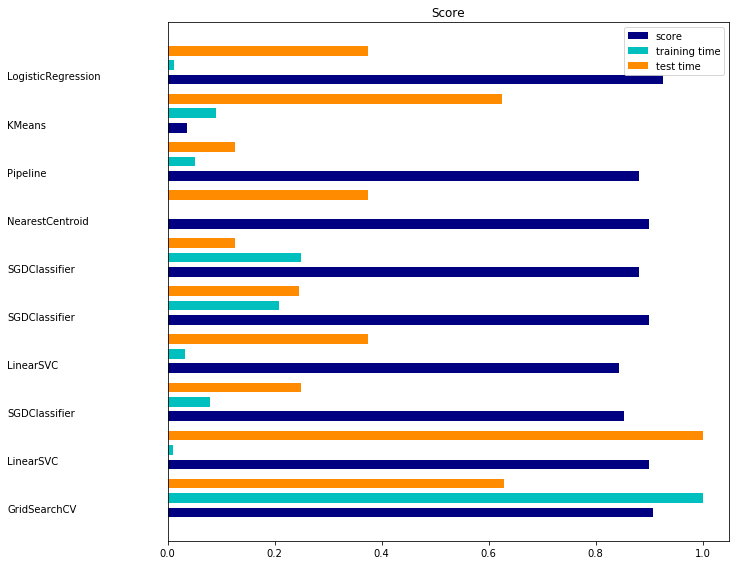

Evaluating Split 0
gridsearchRF
________________________________________________________________________________
Training: 
GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000900,
            n_jobs=None, oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 60, 70], 'min_samples_leaf': [1, 11]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


train time: 1.358s
test time:  0.005s
accuracy:   0.899
classification report:
                         precision    recall  f1-score   support

            Make Update       0.90      1.00      0.95        37
          Setup Printer       0.92      0.85      0.88        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.88      0.88      0.88        40
                   None       0.50      0.20      0.29         5

              micro avg       0.90      0.90      0.90       109
              macro avg       0.84      0.78      0.80       109
           weighted avg       0.89      0.90      0.89       109

confusion matrix:
[[37  0  0  0  0]
 [ 1 11  0  1  0]
 [ 0  0 14  0  0]
 [ 3  1  0 35  1]
 [ 0  0  0  4  1]]

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.103s
test time:  0.002s
accuracy:   0.890
dimensionality: 3748
density: 0.443757

classification report:
                         precision    recall  f1-score   support

            Make Update       0.95      0.95      0.95        37
          Setup Printer       0.93      1.00      0.96        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.83      0.88      0.85        40
                   None       0.00      0.00      0.00         5

              micro avg       0.89      0.89      0.89       109
              macro avg       0.74      0.76      0.75       109
           weighted avg       0.87      0.89      0.88       109

confusion matrix:
[[35  0  0  2  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  1  0 35  2]
 [ 0  0  0  5  0]]

L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     interce

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.039s
test time:  0.002s
accuracy:   0.853
dimensionality: 3748
density: 0.005816

classification report:
                         precision    recall  f1-score   support

            Make Update       0.97      0.84      0.90        37
          Setup Printer       0.76      1.00      0.87        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.87      0.82      0.85        40
                   None       0.25      0.40      0.31         5

              micro avg       0.85      0.85      0.85       109
              macro avg       0.77      0.81      0.78       109
           weighted avg       0.88      0.85      0.86       109

confusion matrix:
[[31  3  0  3  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 1  0  0 33  6]
 [ 0  1  0  2  2]]

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, 

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.322s
test time:  0.002s
accuracy:   0.917
dimensionality: 3748
density: 0.407631

classification report:
                         precision    recall  f1-score   support

            Make Update       0.95      0.97      0.96        37
          Setup Printer       0.87      1.00      0.93        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.95      0.88      0.91        40
                   None       0.40      0.40      0.40         5

              micro avg       0.92      0.92      0.92       109
              macro avg       0.83      0.85      0.84       109
           weighted avg       0.92      0.92      0.92       109

confusion matrix:
[[36  0  0  1  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  0 35  3]
 [ 0  2  0  1  2]]

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       ea

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.290s
test time:  0.002s
accuracy:   0.908
dimensionality: 3748
density: 0.399787

classification report:
                         precision    recall  f1-score   support

            Make Update       0.92      0.97      0.95        37
          Setup Printer       0.93      1.00      0.96        13
      Shutdown Computer       0.93      1.00      0.97        14
Software Recommendation       0.88      0.88      0.88        40
                   None       1.00      0.20      0.33         5

              micro avg       0.91      0.91      0.91       109
              macro avg       0.93      0.81      0.82       109
           weighted avg       0.91      0.91      0.90       109

confusion matrix:
[[36  0  0  1  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  1  1 35  0]
 [ 0  0  0  4  1]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_thresho

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.059s
test time:  0.001s
accuracy:   0.881
classification report:
                         precision    recall  f1-score   support

            Make Update       0.94      0.89      0.92        37
          Setup Printer       0.87      1.00      0.93        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.89      0.82      0.86        40
                   None       0.38      0.60      0.46         5

              micro avg       0.88      0.88      0.88       109
              macro avg       0.82      0.86      0.83       109
           weighted avg       0.90      0.88      0.89       109

confusion matrix:
[[33  1  0  3  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  0 33  5]
 [ 0  1  0  1  3]]

KMeans
________________________________________________________________________________
Training: 
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_d

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.037
classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.00      0.00      0.00        37
          Setup Printer       0.04      0.31      0.07        13
      Shutdown Computer       0.00      0.00      0.00        14
Software Recommendation       0.00      0.00      0.00        40
                   None       0.00      0.00      0.00         5

              micro avg       0.04      0.04      0.04       109
              macro avg       0.01      0.06      0.01       109
           weighted avg       0.00      0.04      0.01       109

confusion matrix:
[[ 0 37  0  0  0]
 [ 9  4  0  0  0]
 [ 0 14  0  0  0]
 [ 1 39  0  0  0]
 [ 1  4  0  0  0]]

LogisticRegression
________________________________________________________________________________
Training: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=Non

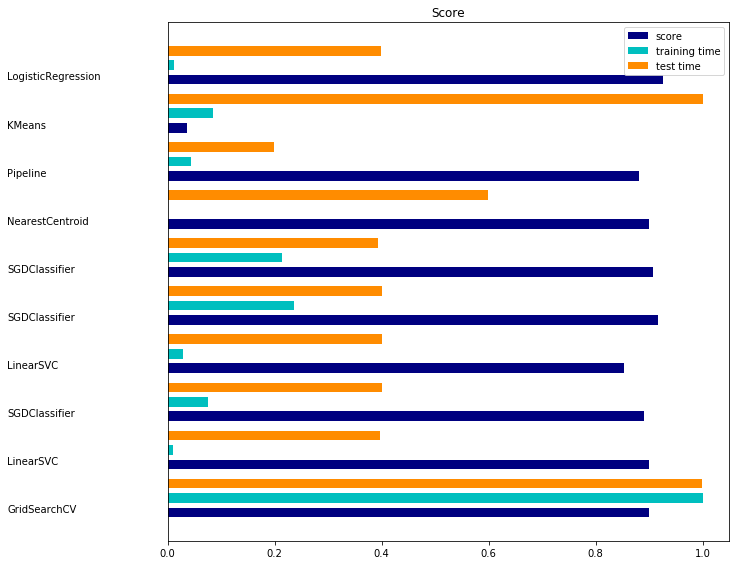

Evaluating Split 0
gridsearchRF
________________________________________________________________________________
Training: 
GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000900,
            n_jobs=None, oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 60, 70], 'min_samples_leaf': [1, 11]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


train time: 1.312s
test time:  0.005s
accuracy:   0.881
classification report:
                         precision    recall  f1-score   support

            Make Update       0.92      0.97      0.95        37
          Setup Printer       1.00      0.92      0.96        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.83      0.85      0.84        40
                   None       0.00      0.00      0.00         5

              micro avg       0.88      0.88      0.88       109
              macro avg       0.75      0.75      0.75       109
           weighted avg       0.87      0.88      0.87       109

confusion matrix:
[[36  0  0  1  0]
 [ 0 12  0  1  0]
 [ 0  0 14  0  0]
 [ 3  0  0 34  3]
 [ 0  0  0  5  0]]

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.101s
test time:  0.002s


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.881
dimensionality: 3748
density: 0.414034

classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.92      0.92      0.92        37
          Setup Printer       0.81      1.00      0.90        13
      Shutdown Computer       0.88      1.00      0.93        14
Software Recommendation       0.88      0.88      0.88        40
                   None       0.00      0.00      0.00         5

              micro avg       0.88      0.88      0.88       109
              macro avg       0.70      0.76      0.72       109
           weighted avg       0.84      0.88      0.86       109

confusion matrix:
[[34  0  1  2  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  2  0 35  0]
 [ 0  1  1  3  0]]

L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.001,


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.041s
test time:  0.002s
accuracy:   0.807
dimensionality: 3748
density: 0.005496

classification report:
                         precision    recall  f1-score   support

            Make Update       0.97      0.84      0.90        37
          Setup Printer       0.65      1.00      0.79        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.85      0.70      0.77        40
                   None       0.20      0.40      0.27         5

              micro avg       0.81      0.81      0.81       109
              macro avg       0.73      0.79      0.74       109
           weighted avg       0.86      0.81      0.82       109

confusion matrix:
[[31  3  0  3  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 1  3  0 28  8]
 [ 0  1  0  2  2]]

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, 

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.285s
test time:  0.002s


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.899
dimensionality: 3748
density: 0.382337

classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.92      0.92      0.92        37
          Setup Printer       0.87      1.00      0.93        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.86      0.93      0.89        40
                   None       0.00      0.00      0.00         5

              micro avg       0.90      0.90      0.90       109
              macro avg       0.73      0.77      0.75       109
           weighted avg       0.86      0.90      0.88       109

confusion matrix:
[[34  0  0  3  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  0  0 37  0]
 [ 0  2  0  3  0]]

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hin

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.338s
test time:  0.002s


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.890
dimensionality: 3748
density: 0.387567

classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.97      0.86      0.91        37
          Setup Printer       0.76      1.00      0.87        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.84      0.95      0.89        40
                   None       0.00      0.00      0.00         5

              micro avg       0.89      0.89      0.89       109
              macro avg       0.72      0.76      0.74       109
           weighted avg       0.86      0.89      0.87       109

confusion matrix:
[[32  1  0  4  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 1  1  0 38  0]
 [ 0  2  0  3  0]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.003s
test time:  0.004s
accuracy:   0.899
classification report:
                         precis

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.065s
test time:  0.001s
accuracy:   0.872
classification report:
                         precision    recall  f1-score   support

            Make Update       0.94      0.89      0.92        37
          Setup Printer       0.87      1.00      0.93        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.89      0.80      0.84        40
                   None       0.33      0.60      0.43         5

              micro avg       0.87      0.87      0.87       109
              macro avg       0.81      0.86      0.82       109
           weighted avg       0.89      0.87      0.88       109

confusion matrix:
[[33  2  0  2  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  0 32  6]
 [ 0  0  0  2  3]]

KMeans
________________________________________________________________________________
Training: 
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_d

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.037
classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.00      0.00      0.00        37
          Setup Printer       0.04      0.31      0.07        13
      Shutdown Computer       0.00      0.00      0.00        14
Software Recommendation       0.00      0.00      0.00        40
                   None       0.00      0.00      0.00         5

              micro avg       0.04      0.04      0.04       109
              macro avg       0.01      0.06      0.01       109
           weighted avg       0.00      0.04      0.01       109

confusion matrix:
[[ 0 37  0  0  0]
 [ 9  4  0  0  0]
 [ 0 14  0  0  0]
 [ 1 39  0  0  0]
 [ 1  4  0  0  0]]

LogisticRegression
________________________________________________________________________________
Training: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=Non

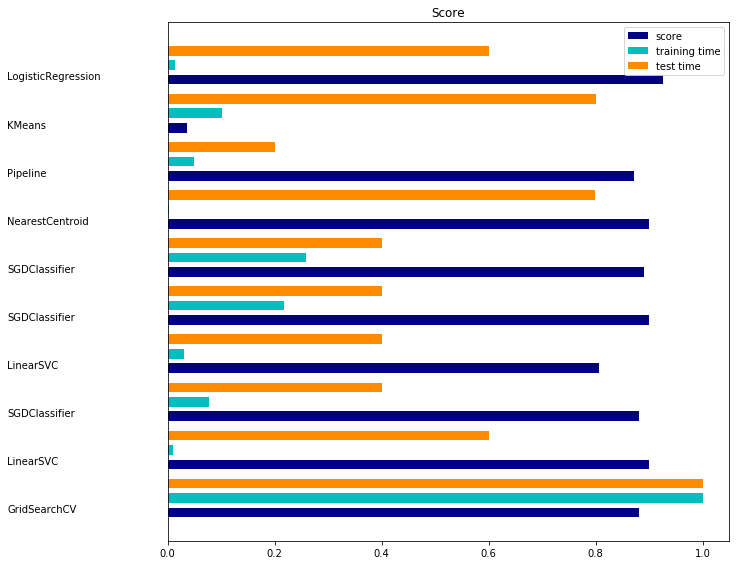

Evaluating Split 0
gridsearchRF
________________________________________________________________________________
Training: 
GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000900,
            n_jobs=None, oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 60, 70], 'min_samples_leaf': [1, 11]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


train time: 1.287s
test time:  0.004s
accuracy:   0.862
classification report:
                         precision    recall  f1-score   support

            Make Update       0.90      1.00      0.95        37
          Setup Printer       0.92      0.85      0.88        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.86      0.80      0.83        40
                   None       0.00      0.00      0.00         5

              micro avg       0.86      0.86      0.86       109
              macro avg       0.74      0.73      0.73       109
           weighted avg       0.86      0.86      0.86       109

confusion matrix:
[[37  0  0  0  0]
 [ 1 11  0  1  0]
 [ 0  0 14  0  0]
 [ 3  0  0 32  5]
 [ 0  1  0  4  0]]

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.108s
test time:  0.001s
accuracy:   0.908
dimensionality: 3748
density: 0.472732

classification report:
                         precision    recall  f1-score   support

            Make Update       0.94      0.92      0.93        37
          Setup Printer       1.00      1.00      1.00        13
      Shutdown Computer       0.93      1.00      0.97        14
Software Recommendation       0.86      0.93      0.89        40
                   None       0.50      0.20      0.29         5

              micro avg       0.91      0.91      0.91       109
              macro avg       0.85      0.81      0.81       109
           weighted avg       0.90      0.91      0.90       109

confusion matrix:
[[34  0  0  3  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  0 37  1]
 [ 0  0  1  3  1]]

L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     interce

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.037s
test time:  0.002s
accuracy:   0.835
dimensionality: 3748
density: 0.006190

classification report:
                         precision    recall  f1-score   support

            Make Update       0.97      0.84      0.90        37
          Setup Printer       0.72      1.00      0.84        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.86      0.78      0.82        40
                   None       0.22      0.40      0.29         5

              micro avg       0.83      0.83      0.83       109
              macro avg       0.75      0.80      0.77       109
           weighted avg       0.87      0.83      0.85       109

confusion matrix:
[[31  3  0  3  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 1  1  0 31  7]
 [ 0  1  0  2  2]]

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, 

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.283s
test time:  0.002s
accuracy:   0.844
dimensionality: 3748
density: 0.426521

classification report:
                         precision    recall  f1-score   support

            Make Update       0.95      1.00      0.97        37
          Setup Printer       0.93      1.00      0.96        13
      Shutdown Computer       0.61      1.00      0.76        14
Software Recommendation       0.96      0.68      0.79        40
                   None       0.20      0.20      0.20         5

              micro avg       0.84      0.84      0.84       109
              macro avg       0.73      0.78      0.74       109
           weighted avg       0.87      0.84      0.84       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  1  6 27  4]
 [ 0  0  3  1  1]]

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       ea

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.313s
test time:  0.002s
accuracy:   0.908
dimensionality: 3748
density: 0.408858

classification report:
                         precision    recall  f1-score   support

            Make Update       0.92      0.97      0.95        37
          Setup Printer       1.00      1.00      1.00        13
      Shutdown Computer       0.93      1.00      0.97        14
Software Recommendation       0.89      0.85      0.87        40
                   None       0.50      0.40      0.44         5

              micro avg       0.91      0.91      0.91       109
              macro avg       0.85      0.84      0.85       109
           weighted avg       0.90      0.91      0.91       109

confusion matrix:
[[36  0  0  1  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  0  1 34  2]
 [ 0  0  0  3  2]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_thresho

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.066s
test time:  0.000s
accuracy:   0.872
classification report:
                         precision    recall  f1-score   support

            Make Update       0.92      0.89      0.90        37
          Setup Printer       0.86      0.92      0.89        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.91      0.80      0.85        40
                   None       0.40      0.80      0.53         5

              micro avg       0.87      0.87      0.87       109
              macro avg       0.82      0.88      0.84       109
           weighted avg       0.90      0.87      0.88       109

confusion matrix:
[[33  2  0  2  0]
 [ 1 12  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  0 32  6]
 [ 0  0  0  1  4]]

KMeans
________________________________________________________________________________
Training: 
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_d

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.037
classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.00      0.00      0.00        37
          Setup Printer       0.04      0.31      0.07        13
      Shutdown Computer       0.00      0.00      0.00        14
Software Recommendation       0.00      0.00      0.00        40
                   None       0.00      0.00      0.00         5

              micro avg       0.04      0.04      0.04       109
              macro avg       0.01      0.06      0.01       109
           weighted avg       0.00      0.04      0.01       109

confusion matrix:
[[ 0 37  0  0  0]
 [ 9  4  0  0  0]
 [ 0 14  0  0  0]
 [ 1 39  0  0  0]
 [ 1  4  0  0  0]]

LogisticRegression
________________________________________________________________________________
Training: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=Non

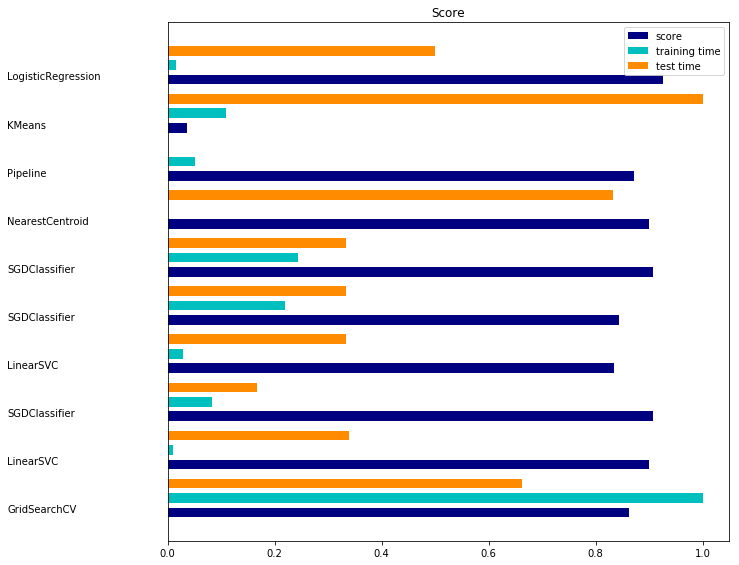

Evaluating Split 0
gridsearchRF
________________________________________________________________________________
Training: 
GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000900,
            n_jobs=None, oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 60, 70], 'min_samples_leaf': [1, 11]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


train time: 1.340s
test time:  0.005s
accuracy:   0.890
classification report:
                         precision    recall  f1-score   support

            Make Update       0.93      1.00      0.96        37
          Setup Printer       0.92      0.92      0.92        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.87      0.82      0.85        40
                   None       0.25      0.20      0.22         5

              micro avg       0.89      0.89      0.89       109
              macro avg       0.79      0.79      0.79       109
           weighted avg       0.88      0.89      0.89       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 12  0  1  0]
 [ 0  0 14  0  0]
 [ 3  1  0 33  3]
 [ 0  0  0  4  1]]

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.096s
test time:  0.002s
accuracy:   0.899
dimensionality: 3748
density: 0.451974

classification report:
                         precision    recall  f1-score   support

            Make Update       0.95      0.95      0.95        37
          Setup Printer       0.93      1.00      0.96        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.84      0.90      0.87        40
                   None       0.00      0.00      0.00         5

              micro avg       0.90      0.90      0.90       109
              macro avg       0.74      0.77      0.76       109
           weighted avg       0.87      0.90      0.88       109

confusion matrix:
[[35  0  0  2  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  1  0 36  1]
 [ 0  0  0  5  0]]

L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     interce

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.042s
test time:  0.002s
accuracy:   0.844
dimensionality: 3748
density: 0.006350

classification report:
                         precision    recall  f1-score   support

            Make Update       0.94      0.84      0.89        37
          Setup Printer       0.76      1.00      0.87        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.86      0.80      0.83        40
                   None       0.25      0.40      0.31         5

              micro avg       0.84      0.84      0.84       109
              macro avg       0.76      0.81      0.78       109
           weighted avg       0.87      0.84      0.85       109

confusion matrix:
[[31  3  0  3  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  0 32  6]
 [ 0  1  0  2  2]]

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, 

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.283s
test time:  0.001s


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.917
dimensionality: 3748
density: 0.367076

classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.92      0.97      0.95        37
          Setup Printer       1.00      1.00      1.00        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.86      0.93      0.89        40
                   None       0.00      0.00      0.00         5

              micro avg       0.92      0.92      0.92       109
              macro avg       0.76      0.78      0.77       109
           weighted avg       0.88      0.92      0.90       109

confusion matrix:
[[36  0  0  1  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  0  0 37  0]
 [ 0  0  0  5  0]]

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hin

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.283s
test time:  0.002s


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.881
dimensionality: 3748
density: 0.425347

classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.92      0.92      0.92        37
          Setup Printer       1.00      1.00      1.00        13
      Shutdown Computer       0.78      1.00      0.88        14
Software Recommendation       0.85      0.88      0.86        40
                   None       0.00      0.00      0.00         5

              micro avg       0.88      0.88      0.88       109
              macro avg       0.71      0.76      0.73       109
           weighted avg       0.84      0.88      0.86       109

confusion matrix:
[[34  0  0  3  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  0  2 35  0]
 [ 0  0  2  3  0]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.003s
test time:  0.004s
accuracy:   0.899
classification report:
                         precis

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.065s
test time:  0.001s
accuracy:   0.853
classification report:
                         precision    recall  f1-score   support

            Make Update       0.94      0.89      0.92        37
          Setup Printer       0.93      1.00      0.96        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.86      0.75      0.80        40
                   None       0.27      0.60      0.37         5

              micro avg       0.85      0.85      0.85       109
              macro avg       0.80      0.85      0.81       109
           weighted avg       0.89      0.85      0.87       109

confusion matrix:
[[33  1  0  3  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  0 30  8]
 [ 0  0  0  2  3]]

KMeans
________________________________________________________________________________
Training: 
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_d

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.037
classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.00      0.00      0.00        37
          Setup Printer       0.04      0.31      0.07        13
      Shutdown Computer       0.00      0.00      0.00        14
Software Recommendation       0.00      0.00      0.00        40
                   None       0.00      0.00      0.00         5

              micro avg       0.04      0.04      0.04       109
              macro avg       0.01      0.06      0.01       109
           weighted avg       0.00      0.04      0.01       109

confusion matrix:
[[ 0 37  0  0  0]
 [ 9  4  0  0  0]
 [ 0 14  0  0  0]
 [ 1 39  0  0  0]
 [ 1  4  0  0  0]]

LogisticRegression
________________________________________________________________________________
Training: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=Non

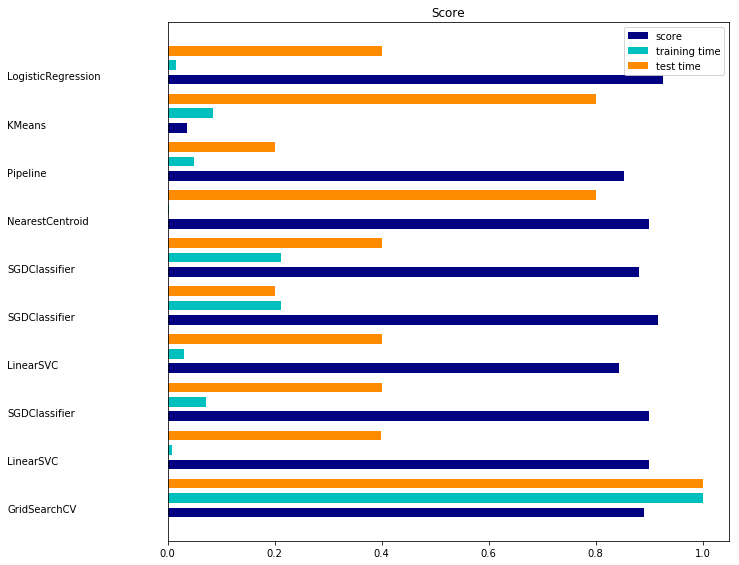

Evaluating Split 0
gridsearchRF
________________________________________________________________________________
Training: 
GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000900,
            n_jobs=None, oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 60, 70], 'min_samples_leaf': [1, 11]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


train time: 1.313s
test time:  0.006s
accuracy:   0.908
classification report:
                         precision    recall  f1-score   support

            Make Update       0.93      1.00      0.96        37
          Setup Printer       0.86      0.92      0.89        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.90      0.88      0.89        40
                   None       0.50      0.20      0.29         5

              micro avg       0.91      0.91      0.91       109
              macro avg       0.84      0.80      0.80       109
           weighted avg       0.90      0.91      0.90       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 12  0  1  0]
 [ 0  0 14  0  0]
 [ 3  1  0 35  1]
 [ 0  1  0  3  1]]

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.098s
test time:  0.002s


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.899
dimensionality: 3748
density: 0.452775

classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.97      0.89      0.93        37
          Setup Printer       0.93      1.00      0.96        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.81      0.95      0.87        40
                   None       0.00      0.00      0.00         5

              micro avg       0.90      0.90      0.90       109
              macro avg       0.74      0.77      0.75       109
           weighted avg       0.87      0.90      0.88       109

confusion matrix:
[[33  0  0  4  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 1  1  0 38  0]
 [ 0  0  0  5  0]]

L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.001,


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.037s
test time:  0.002s
accuracy:   0.853
dimensionality: 3748
density: 0.006403

classification report:
                         precision    recall  f1-score   support

            Make Update       0.97      0.84      0.90        37
          Setup Printer       0.76      1.00      0.87        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.87      0.82      0.85        40
                   None       0.25      0.40      0.31         5

              micro avg       0.85      0.85      0.85       109
              macro avg       0.77      0.81      0.78       109
           weighted avg       0.88      0.85      0.86       109

confusion matrix:
[[31  3  0  3  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 1  0  0 33  6]
 [ 0  1  0  2  2]]

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, 

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.287s
test time:  0.002s
accuracy:   0.917
dimensionality: 3748
density: 0.437834

classification report:
                         precision    recall  f1-score   support

            Make Update       0.92      0.97      0.95        37
          Setup Printer       0.87      1.00      0.93        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.90      0.88      0.89        40
                   None       1.00      0.40      0.57         5

              micro avg       0.92      0.92      0.92       109
              macro avg       0.94      0.85      0.87       109
           weighted avg       0.92      0.92      0.91       109

confusion matrix:
[[36  0  0  1  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  2  0 35  0]
 [ 0  0  0  3  2]]

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       ea

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.297s
test time:  0.002s
accuracy:   0.908
dimensionality: 3748
density: 0.407257

classification report:
                         precision    recall  f1-score   support

            Make Update       1.00      0.89      0.94        37
          Setup Printer       0.93      1.00      0.96        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.84      0.93      0.88        40
                   None       0.50      0.40      0.44         5

              micro avg       0.91      0.91      0.91       109
              macro avg       0.85      0.84      0.85       109
           weighted avg       0.91      0.91      0.91       109

confusion matrix:
[[33  0  0  4  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 0  1  0 37  2]
 [ 0  0  0  3  2]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_thresho

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.069s
test time:  0.001s
accuracy:   0.872
classification report:
                         precision    recall  f1-score   support

            Make Update       0.94      0.86      0.90        37
          Setup Printer       0.87      1.00      0.93        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.89      0.80      0.84        40
                   None       0.40      0.80      0.53         5

              micro avg       0.87      0.87      0.87       109
              macro avg       0.82      0.89      0.84       109
           weighted avg       0.90      0.87      0.88       109

confusion matrix:
[[32  2  0  3  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  0 32  6]
 [ 0  0  0  1  4]]

KMeans
________________________________________________________________________________
Training: 
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_d

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.037
classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.00      0.00      0.00        37
          Setup Printer       0.04      0.31      0.07        13
      Shutdown Computer       0.00      0.00      0.00        14
Software Recommendation       0.00      0.00      0.00        40
                   None       0.00      0.00      0.00         5

              micro avg       0.04      0.04      0.04       109
              macro avg       0.01      0.06      0.01       109
           weighted avg       0.00      0.04      0.01       109

confusion matrix:
[[ 0 37  0  0  0]
 [ 9  4  0  0  0]
 [ 0 14  0  0  0]
 [ 1 39  0  0  0]
 [ 1  4  0  0  0]]

LogisticRegression
________________________________________________________________________________
Training: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=Non

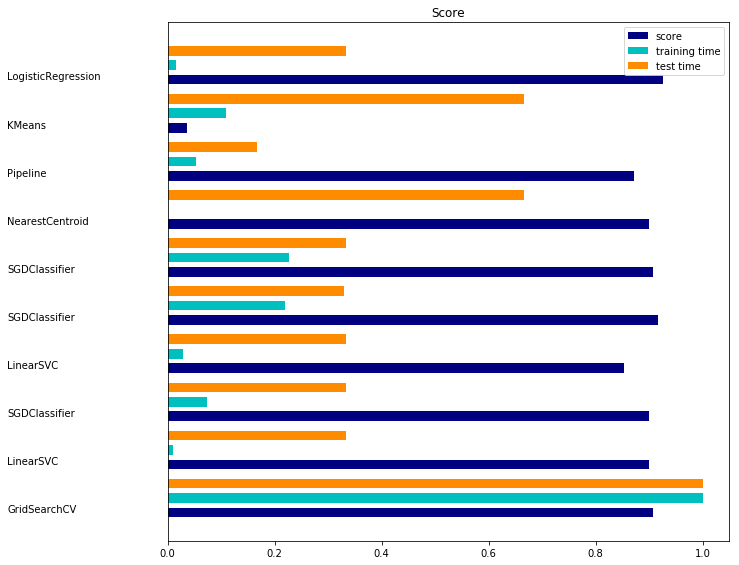

Evaluating Split 0
gridsearchRF
________________________________________________________________________________
Training: 
GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000900,
            n_jobs=None, oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 60, 70], 'min_samples_leaf': [1, 11]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


train time: 1.300s
test time:  0.006s
accuracy:   0.917
classification report:
                         precision    recall  f1-score   support

            Make Update       0.93      1.00      0.96        37
          Setup Printer       1.00      0.92      0.96        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.88      0.90      0.89        40
                   None       0.50      0.20      0.29         5

              micro avg       0.92      0.92      0.92       109
              macro avg       0.86      0.80      0.82       109
           weighted avg       0.91      0.92      0.91       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 12  0  1  0]
 [ 0  0 14  0  0]
 [ 3  0  0 36  1]
 [ 0  0  0  4  1]]

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.102s
test time:  0.003s
accuracy:   0.890
dimensionality: 3748
density: 0.450747

classification report:
                         precision    recall  f1-score   support

            Make Update       0.94      0.92      0.93        37
          Setup Printer       1.00      0.92      0.96        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.80      0.93      0.86        40
                   None       0.00      0.00      0.00         5

              micro avg       0.89      0.89      0.89       109
              macro avg       0.75      0.75      0.75       109
           weighted avg       0.86      0.89      0.87       109

confusion matrix:
[[34  0  0  3  0]
 [ 0 12  0  1  0]
 [ 0  0 14  0  0]
 [ 2  0  0 37  1]
 [ 0  0  0  5  0]]

L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     interce

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.043s
test time:  0.002s
accuracy:   0.872
dimensionality: 3748
density: 0.006350

classification report:
                         precision    recall  f1-score   support

            Make Update       0.97      0.89      0.93        37
          Setup Printer       0.87      1.00      0.93        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.86      0.80      0.83        40
                   None       0.33      0.60      0.43         5

              micro avg       0.87      0.87      0.87       109
              macro avg       0.81      0.86      0.82       109
           weighted avg       0.89      0.87      0.88       109

confusion matrix:
[[33  1  0  3  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 1  1  0 32  6]
 [ 0  0  0  2  3]]

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, 

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.307s
test time:  0.002s
accuracy:   0.872
dimensionality: 3748
density: 0.403895

classification report:
                         precision    recall  f1-score   support

            Make Update       0.83      0.95      0.89        37
          Setup Printer       1.00      1.00      1.00        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.91      0.75      0.82        40
                   None       0.43      0.60      0.50         5

              micro avg       0.87      0.87      0.87       109
              macro avg       0.83      0.86      0.84       109
           weighted avg       0.88      0.87      0.87       109

confusion matrix:
[[35  0  0  2  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 6  0  0 30  4]
 [ 1  0  0  1  3]]

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       ea

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.303s
test time:  0.002s


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.908
dimensionality: 3748
density: 0.417663

classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.93      1.00      0.96        37
          Setup Printer       1.00      0.92      0.96        13
      Shutdown Computer       0.88      1.00      0.93        14
Software Recommendation       0.88      0.90      0.89        40
                   None       0.00      0.00      0.00         5

              micro avg       0.91      0.91      0.91       109
              macro avg       0.74      0.76      0.75       109
           weighted avg       0.87      0.91      0.89       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 12  1  0  0]
 [ 0  0 14  0  0]
 [ 3  0  1 36  0]
 [ 0  0  0  5  0]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.002s
test time:  0.004s
accuracy:   0.899
classification report:
                         precis

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.065s
test time:  0.000s
accuracy:   0.853
classification report:
                         precision    recall  f1-score   support

            Make Update       0.94      0.89      0.92        37
          Setup Printer       0.87      1.00      0.93        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.88      0.75      0.81        40
                   None       0.27      0.60      0.37         5

              micro avg       0.85      0.85      0.85       109
              macro avg       0.79      0.85      0.81       109
           weighted avg       0.89      0.85      0.87       109

confusion matrix:
[[33  2  0  2  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  0 30  8]
 [ 0  0  0  2  3]]

KMeans
________________________________________________________________________________
Training: 
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_d

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.037
classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.00      0.00      0.00        37
          Setup Printer       0.04      0.31      0.07        13
      Shutdown Computer       0.00      0.00      0.00        14
Software Recommendation       0.00      0.00      0.00        40
                   None       0.00      0.00      0.00         5

              micro avg       0.04      0.04      0.04       109
              macro avg       0.01      0.06      0.01       109
           weighted avg       0.00      0.04      0.01       109

confusion matrix:
[[ 0 37  0  0  0]
 [ 9  4  0  0  0]
 [ 0 14  0  0  0]
 [ 1 39  0  0  0]
 [ 1  4  0  0  0]]

LogisticRegression
________________________________________________________________________________
Training: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=Non

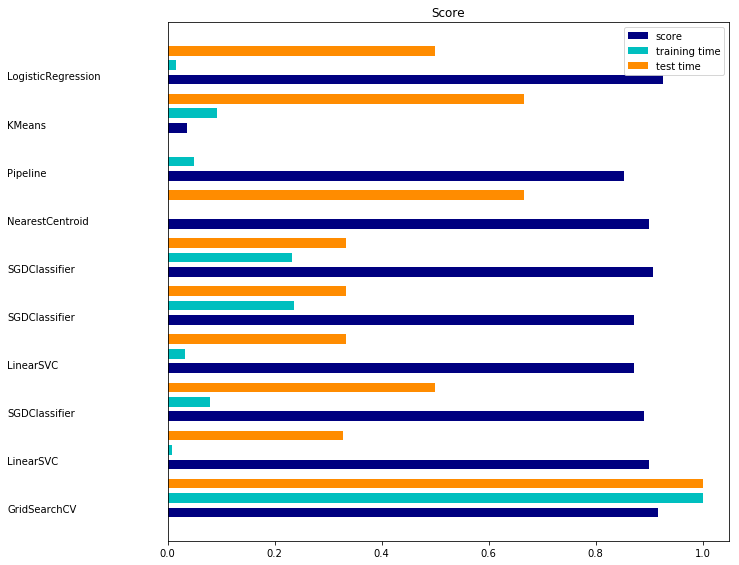

Evaluating Split 0
gridsearchRF
________________________________________________________________________________
Training: 
GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000900,
            n_jobs=None, oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 60, 70], 'min_samples_leaf': [1, 11]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


train time: 1.305s
test time:  0.005s
accuracy:   0.899
classification report:
                         precision    recall  f1-score   support

            Make Update       0.93      1.00      0.96        37
          Setup Printer       1.00      0.92      0.96        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.85      0.88      0.86        40
                   None       0.00      0.00      0.00         5

              micro avg       0.90      0.90      0.90       109
              macro avg       0.76      0.76      0.76       109
           weighted avg       0.87      0.90      0.89       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 12  0  1  0]
 [ 0  0 14  0  0]
 [ 3  0  0 35  2]
 [ 0  0  0  5  0]]

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.099s
test time:  0.002s


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.908
dimensionality: 3748
density: 0.465155

classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.90      0.97      0.94        37
          Setup Printer       1.00      0.92      0.96        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.86      0.93      0.89        40
                   None       0.00      0.00      0.00         5

              micro avg       0.91      0.91      0.91       109
              macro avg       0.75      0.76      0.76       109
           weighted avg       0.87      0.91      0.89       109

confusion matrix:
[[36  0  0  1  0]
 [ 1 12  0  0  0]
 [ 0  0 14  0  0]
 [ 3  0  0 37  0]
 [ 0  0  0  5  0]]

L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.001,


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.039s
test time:  0.002s
accuracy:   0.853
dimensionality: 3748
density: 0.005977

classification report:
                         precision    recall  f1-score   support

            Make Update       0.97      0.84      0.90        37
          Setup Printer       0.72      1.00      0.84        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.87      0.82      0.85        40
                   None       0.29      0.40      0.33         5

              micro avg       0.85      0.85      0.85       109
              macro avg       0.77      0.81      0.78       109
           weighted avg       0.88      0.85      0.86       109

confusion matrix:
[[31  3  0  3  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 1  1  0 33  5]
 [ 0  1  0  2  2]]

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, 

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.273s
test time:  0.002s
accuracy:   0.881
dimensionality: 3748
density: 0.418890

classification report:
                         precision    recall  f1-score   support

            Make Update       0.95      1.00      0.97        37
          Setup Printer       1.00      1.00      1.00        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.94      0.72      0.82        40
                   None       0.25      0.60      0.35         5

              micro avg       0.88      0.88      0.88       109
              macro avg       0.83      0.86      0.83       109
           weighted avg       0.92      0.88      0.89       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  0 29  9]
 [ 0  0  0  2  3]]

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       ea

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.296s
test time:  0.002s
accuracy:   0.881
dimensionality: 3748
density: 0.404269

classification report:
                         precision    recall  f1-score   support

            Make Update       0.94      0.92      0.93        37
          Setup Printer       0.68      1.00      0.81        13
      Shutdown Computer       1.00      0.93      0.96        14
Software Recommendation       0.88      0.88      0.88        40
                   None       1.00      0.20      0.33         5

              micro avg       0.88      0.88      0.88       109
              macro avg       0.90      0.78      0.78       109
           weighted avg       0.90      0.88      0.87       109

confusion matrix:
[[34  0  0  3  0]
 [ 0 13  0  0  0]
 [ 0  1 13  0  0]
 [ 2  3  0 35  0]
 [ 0  2  0  2  1]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_thresho

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.061s
test time:  0.000s
accuracy:   0.890
classification report:
                         precision    recall  f1-score   support

            Make Update       0.94      0.89      0.92        37
          Setup Printer       0.93      1.00      0.96        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.89      0.82      0.86        40
                   None       0.44      0.80      0.57         5

              micro avg       0.89      0.89      0.89       109
              macro avg       0.84      0.90      0.86       109
           weighted avg       0.91      0.89      0.90       109

confusion matrix:
[[33  1  0  3  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  0 33  5]
 [ 0  0  0  1  4]]

KMeans
________________________________________________________________________________
Training: 
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_d

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.037
classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.00      0.00      0.00        37
          Setup Printer       0.04      0.31      0.07        13
      Shutdown Computer       0.00      0.00      0.00        14
Software Recommendation       0.00      0.00      0.00        40
                   None       0.00      0.00      0.00         5

              micro avg       0.04      0.04      0.04       109
              macro avg       0.01      0.06      0.01       109
           weighted avg       0.00      0.04      0.01       109

confusion matrix:
[[ 0 37  0  0  0]
 [ 9  4  0  0  0]
 [ 0 14  0  0  0]
 [ 1 39  0  0  0]
 [ 1  4  0  0  0]]

LogisticRegression
________________________________________________________________________________
Training: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=Non

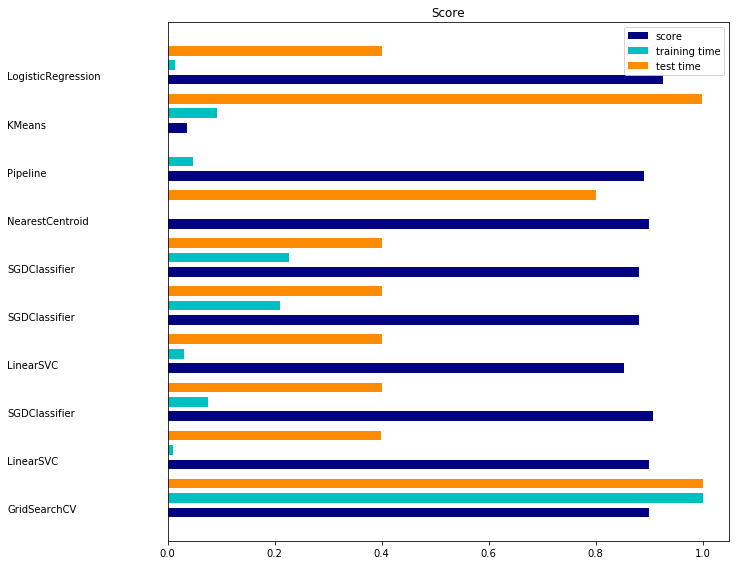

Evaluating Split 0
gridsearchRF
________________________________________________________________________________
Training: 
GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000900,
            n_jobs=None, oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 60, 70], 'min_samples_leaf': [1, 11]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


train time: 1.396s
test time:  0.006s
accuracy:   0.881
classification report:
                         precision    recall  f1-score   support

            Make Update       0.93      1.00      0.96        37
          Setup Printer       1.00      0.92      0.96        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.85      0.82      0.84        40
                   None       0.00      0.00      0.00         5

              micro avg       0.88      0.88      0.88       109
              macro avg       0.75      0.75      0.75       109
           weighted avg       0.87      0.88      0.88       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 12  0  1  0]
 [ 0  0 14  0  0]
 [ 3  0  0 33  4]
 [ 0  0  0  5  0]]

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.094s
test time:  0.002s
accuracy:   0.890
dimensionality: 3748
density: 0.387887

classification report:
                         precision    recall  f1-score   support

            Make Update       0.95      0.95      0.95        37
          Setup Printer       0.86      0.92      0.89        13
      Shutdown Computer       0.82      1.00      0.90        14
Software Recommendation       0.90      0.90      0.90        40
                   None       0.00      0.00      0.00         5

              micro avg       0.89      0.89      0.89       109
              macro avg       0.71      0.75      0.73       109
           weighted avg       0.86      0.89      0.87       109

confusion matrix:
[[35  0  0  2  0]
 [ 0 12  1  0  0]
 [ 0  0 14  0  0]
 [ 2  0  1 36  1]
 [ 0  2  1  2  0]]

L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     interce

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.036s
test time:  0.003s
accuracy:   0.862
dimensionality: 3748
density: 0.006457

classification report:
                         precision    recall  f1-score   support

            Make Update       0.97      0.84      0.90        37
          Setup Printer       0.76      1.00      0.87        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.87      0.85      0.86        40
                   None       0.29      0.40      0.33         5

              micro avg       0.86      0.86      0.86       109
              macro avg       0.78      0.82      0.79       109
           weighted avg       0.88      0.86      0.87       109

confusion matrix:
[[31  3  0  3  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 1  0  0 34  5]
 [ 0  1  0  2  2]]

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, 

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.274s
test time:  0.002s
accuracy:   0.826
dimensionality: 3748
density: 0.394450

classification report:
                         precision    recall  f1-score   support

            Make Update       0.89      0.92      0.91        37
          Setup Printer       0.57      1.00      0.72        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.88      0.72      0.79        40
                   None       0.00      0.00      0.00         5

              micro avg       0.83      0.83      0.83       109
              macro avg       0.67      0.73      0.68       109
           weighted avg       0.82      0.83      0.81       109

confusion matrix:
[[34  0  0  3  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 4  6  0 29  1]
 [ 0  4  0  1  0]]

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       ea

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.306s
test time:  0.002s
accuracy:   0.908
dimensionality: 3748
density: 0.429829

classification report:
                         precision    recall  f1-score   support

            Make Update       0.92      0.97      0.95        37
          Setup Printer       0.81      1.00      0.90        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.89      0.85      0.87        40
                   None       1.00      0.40      0.57         5

              micro avg       0.91      0.91      0.91       109
              macro avg       0.93      0.84      0.86       109
           weighted avg       0.91      0.91      0.90       109

confusion matrix:
[[36  0  0  1  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  3  0 34  0]
 [ 0  0  0  3  2]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_thresho

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.072s
test time:  0.000s
accuracy:   0.872
classification report:
                         precision    recall  f1-score   support

            Make Update       0.94      0.89      0.92        37
          Setup Printer       0.81      1.00      0.90        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.91      0.80      0.85        40
                   None       0.33      0.60      0.43         5

              micro avg       0.87      0.87      0.87       109
              macro avg       0.80      0.86      0.82       109
           weighted avg       0.90      0.87      0.88       109

confusion matrix:
[[33  2  0  2  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  0 32  6]
 [ 0  1  0  1  3]]

KMeans
________________________________________________________________________________
Training: 
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_d

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.037
classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.00      0.00      0.00        37
          Setup Printer       0.04      0.31      0.07        13
      Shutdown Computer       0.00      0.00      0.00        14
Software Recommendation       0.00      0.00      0.00        40
                   None       0.00      0.00      0.00         5

              micro avg       0.04      0.04      0.04       109
              macro avg       0.01      0.06      0.01       109
           weighted avg       0.00      0.04      0.01       109

confusion matrix:
[[ 0 37  0  0  0]
 [ 9  4  0  0  0]
 [ 0 14  0  0  0]
 [ 1 39  0  0  0]
 [ 1  4  0  0  0]]

LogisticRegression
________________________________________________________________________________
Training: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=Non

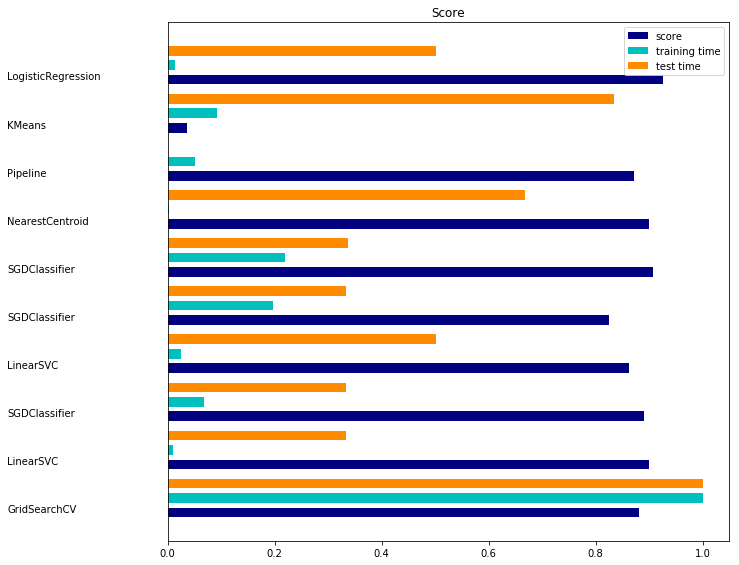

Evaluating Split 0
gridsearchRF
________________________________________________________________________________
Training: 
GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000900,
            n_jobs=None, oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 60, 70], 'min_samples_leaf': [1, 11]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


train time: 1.314s
test time:  0.006s
accuracy:   0.862
classification report:
                         precision    recall  f1-score   support

            Make Update       0.93      1.00      0.96        37
          Setup Printer       1.00      0.92      0.96        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.86      0.75      0.80        40
                   None       0.12      0.20      0.15         5

              micro avg       0.86      0.86      0.86       109
              macro avg       0.78      0.77      0.77       109
           weighted avg       0.88      0.86      0.87       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 12  0  1  0]
 [ 0  0 14  0  0]
 [ 3  0  0 30  7]
 [ 0  0  0  4  1]]

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.108s
test time:  0.002s
accuracy:   0.899
dimensionality: 3748
density: 0.429776

classification report:
                         precision    recall  f1-score   support

            Make Update       0.90      1.00      0.95        37
          Setup Printer       1.00      1.00      1.00        13
      Shutdown Computer       0.88      1.00      0.93        14
Software Recommendation       1.00      0.75      0.86        40
                   None       0.44      0.80      0.57         5

              micro avg       0.90      0.90      0.90       109
              macro avg       0.84      0.91      0.86       109
           weighted avg       0.93      0.90      0.90       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 4  0  1 30  5]
 [ 0  0  1  0  4]]

L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     interce

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.044s
test time:  0.003s
accuracy:   0.817
dimensionality: 3748
density: 0.005870

classification report:
                         precision    recall  f1-score   support

            Make Update       0.97      0.84      0.90        37
          Setup Printer       0.65      1.00      0.79        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.85      0.72      0.78        40
                   None       0.22      0.40      0.29         5

              micro avg       0.82      0.82      0.82       109
              macro avg       0.74      0.79      0.75       109
           weighted avg       0.86      0.82      0.83       109

confusion matrix:
[[31  3  0  3  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 1  3  0 29  7]
 [ 0  1  0  2  2]]

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, 

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.305s
test time:  0.002s
accuracy:   0.890
dimensionality: 3748
density: 0.391142

classification report:
                         precision    recall  f1-score   support

            Make Update       0.92      0.89      0.90        37
          Setup Printer       1.00      0.92      0.96        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.82      0.93      0.87        40
                   None       0.50      0.20      0.29         5

              micro avg       0.89      0.89      0.89       109
              macro avg       0.85      0.79      0.80       109
           weighted avg       0.88      0.89      0.88       109

confusion matrix:
[[33  0  0  4  0]
 [ 1 12  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  0 37  1]
 [ 0  0  0  4  1]]

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       ea

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.274s
test time:  0.016s
accuracy:   0.881
dimensionality: 3748
density: 0.383565

classification report:
                         precision    recall  f1-score   support

            Make Update       0.90      0.97      0.94        37
          Setup Printer       1.00      1.00      1.00        13
      Shutdown Computer       0.78      1.00      0.88        14
Software Recommendation       0.89      0.78      0.83        40
                   None       0.67      0.40      0.50         5

              micro avg       0.88      0.88      0.88       109
              macro avg       0.85      0.83      0.83       109
           weighted avg       0.88      0.88      0.88       109

confusion matrix:
[[36  0  0  1  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 4  0  4 31  1]
 [ 0  0  0  3  2]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_thresho

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.059s
test time:  0.001s
accuracy:   0.862
classification report:
                         precision    recall  f1-score   support

            Make Update       0.94      0.86      0.90        37
          Setup Printer       0.81      1.00      0.90        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.86      0.80      0.83        40
                   None       0.38      0.60      0.46         5

              micro avg       0.86      0.86      0.86       109
              macro avg       0.80      0.85      0.82       109
           weighted avg       0.88      0.86      0.87       109

confusion matrix:
[[32  2  0  3  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  1  0 32  5]
 [ 0  0  0  2  3]]

KMeans
________________________________________________________________________________
Training: 
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_d

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.037
classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.00      0.00      0.00        37
          Setup Printer       0.04      0.31      0.07        13
      Shutdown Computer       0.00      0.00      0.00        14
Software Recommendation       0.00      0.00      0.00        40
                   None       0.00      0.00      0.00         5

              micro avg       0.04      0.04      0.04       109
              macro avg       0.01      0.06      0.01       109
           weighted avg       0.00      0.04      0.01       109

confusion matrix:
[[ 0 37  0  0  0]
 [ 9  4  0  0  0]
 [ 0 14  0  0  0]
 [ 1 39  0  0  0]
 [ 1  4  0  0  0]]

LogisticRegression
________________________________________________________________________________
Training: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=Non

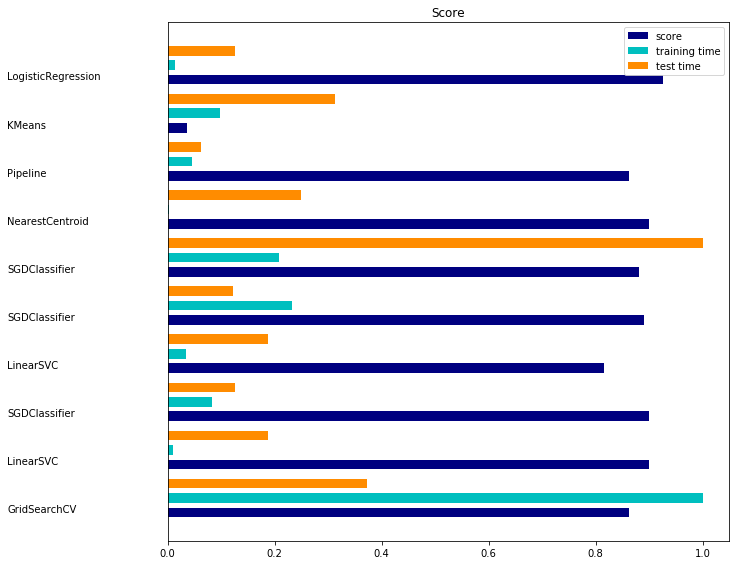

Evaluating Split 0
gridsearchRF
________________________________________________________________________________
Training: 
GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000900,
            n_jobs=None, oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 60, 70], 'min_samples_leaf': [1, 11]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


train time: 1.368s
test time:  0.006s
accuracy:   0.881
classification report:
                         precision    recall  f1-score   support

            Make Update       0.93      1.00      0.96        37
          Setup Printer       1.00      0.92      0.96        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.86      0.80      0.83        40
                   None       0.17      0.20      0.18         5

              micro avg       0.88      0.88      0.88       109
              macro avg       0.79      0.78      0.79       109
           weighted avg       0.89      0.88      0.88       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 12  0  1  0]
 [ 0  0 14  0  0]
 [ 3  0  0 32  5]
 [ 0  0  0  4  1]]

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.104s
test time:  0.002s


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.890
dimensionality: 3748
density: 0.463234

classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.94      0.86      0.90        37
          Setup Printer       1.00      1.00      1.00        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.79      0.95      0.86        40
                   None       0.00      0.00      0.00         5

              micro avg       0.89      0.89      0.89       109
              macro avg       0.75      0.76      0.75       109
           weighted avg       0.86      0.89      0.87       109

confusion matrix:
[[32  0  0  5  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  0 38  0]
 [ 0  0  0  5  0]]

L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.001,


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.047s
test time:  0.002s
accuracy:   0.817
dimensionality: 3748
density: 0.006243

classification report:
                         precision    recall  f1-score   support

            Make Update       0.94      0.84      0.89        37
          Setup Printer       0.72      1.00      0.84        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.85      0.72      0.78        40
                   None       0.20      0.40      0.27         5

              micro avg       0.82      0.82      0.82       109
              macro avg       0.74      0.79      0.75       109
           weighted avg       0.86      0.82      0.83       109

confusion matrix:
[[31  3  0  3  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  1  0 29  8]
 [ 0  1  0  2  2]]

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, 

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.300s
test time:  0.002s
accuracy:   0.899
dimensionality: 3748
density: 0.400694

classification report:
                         precision    recall  f1-score   support

            Make Update       0.84      0.97      0.90        37
          Setup Printer       1.00      1.00      1.00        13
      Shutdown Computer       0.88      1.00      0.93        14
Software Recommendation       0.94      0.85      0.89        40
                   None       1.00      0.20      0.33         5

              micro avg       0.90      0.90      0.90       109
              macro avg       0.93      0.80      0.81       109
           weighted avg       0.91      0.90      0.89       109

confusion matrix:
[[36  0  0  1  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 5  0  1 34  0]
 [ 2  0  1  1  1]]

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       ea

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.307s
test time:  0.003s
accuracy:   0.908
dimensionality: 3748
density: 0.395838

classification report:
                         precision    recall  f1-score   support

            Make Update       0.93      1.00      0.96        37
          Setup Printer       1.00      1.00      1.00        13
      Shutdown Computer       0.93      1.00      0.97        14
Software Recommendation       0.97      0.78      0.86        40
                   None       0.44      0.80      0.57         5

              micro avg       0.91      0.91      0.91       109
              macro avg       0.85      0.92      0.87       109
           weighted avg       0.93      0.91      0.91       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  0  1 31  5]
 [ 0  0  0  1  4]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_thresho

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.063s
test time:  0.000s
accuracy:   0.862
classification report:
                         precision    recall  f1-score   support

            Make Update       0.94      0.89      0.92        37
          Setup Printer       0.81      1.00      0.90        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.91      0.78      0.84        40
                   None       0.30      0.60      0.40         5

              micro avg       0.86      0.86      0.86       109
              macro avg       0.79      0.85      0.81       109
           weighted avg       0.89      0.86      0.87       109

confusion matrix:
[[33  2  0  2  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  0 31  7]
 [ 0  1  0  1  3]]

KMeans
________________________________________________________________________________
Training: 
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_d

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.037
classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.00      0.00      0.00        37
          Setup Printer       0.04      0.31      0.07        13
      Shutdown Computer       0.00      0.00      0.00        14
Software Recommendation       0.00      0.00      0.00        40
                   None       0.00      0.00      0.00         5

              micro avg       0.04      0.04      0.04       109
              macro avg       0.01      0.06      0.01       109
           weighted avg       0.00      0.04      0.01       109

confusion matrix:
[[ 0 37  0  0  0]
 [ 9  4  0  0  0]
 [ 0 14  0  0  0]
 [ 1 39  0  0  0]
 [ 1  4  0  0  0]]

LogisticRegression
________________________________________________________________________________
Training: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=Non

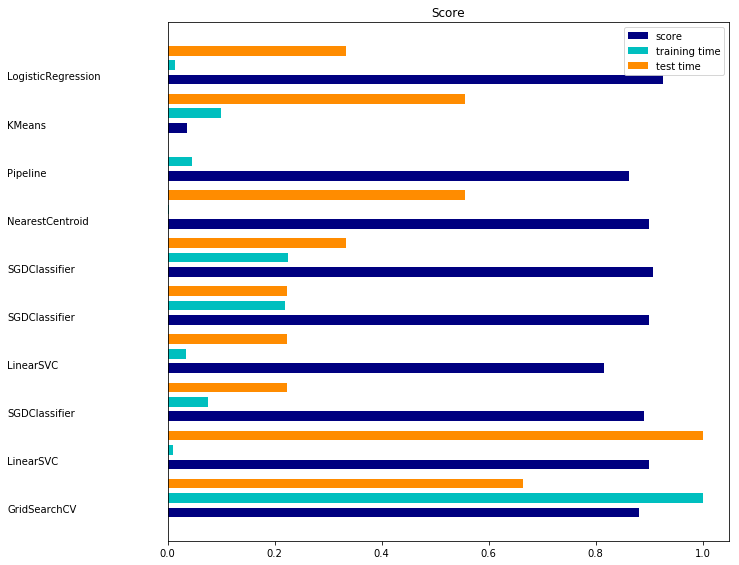

Evaluating Split 0
gridsearchRF
________________________________________________________________________________
Training: 
GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000900,
            n_jobs=None, oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 60, 70], 'min_samples_leaf': [1, 11]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


train time: 1.358s
test time:  0.008s
accuracy:   0.908
classification report:
                         precision    recall  f1-score   support

            Make Update       0.93      1.00      0.96        37
          Setup Printer       1.00      0.92      0.96        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.89      0.85      0.87        40
                   None       0.40      0.40      0.40         5

              micro avg       0.91      0.91      0.91       109
              macro avg       0.84      0.83      0.84       109
           weighted avg       0.91      0.91      0.91       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 12  0  1  0]
 [ 0  0 14  0  0]
 [ 3  0  0 34  3]
 [ 0  0  0  3  2]]

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.101s
test time:  0.002s
accuracy:   0.908
dimensionality: 3748
density: 0.403469

classification report:
                         precision    recall  f1-score   support

            Make Update       0.94      0.92      0.93        37
          Setup Printer       0.93      1.00      0.96        13
      Shutdown Computer       0.93      1.00      0.97        14
Software Recommendation       0.88      0.93      0.90        40
                   None       0.50      0.20      0.29         5

              micro avg       0.91      0.91      0.91       109
              macro avg       0.84      0.81      0.81       109
           weighted avg       0.90      0.91      0.90       109

confusion matrix:
[[34  1  0  2  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  0 37  1]
 [ 0  0  1  3  1]]

L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     interce

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.052s
test time:  0.002s
accuracy:   0.844
dimensionality: 3748
density: 0.006457

classification report:
                         precision    recall  f1-score   support

            Make Update       0.97      0.84      0.90        37
          Setup Printer       0.76      1.00      0.87        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.86      0.80      0.83        40
                   None       0.22      0.40      0.29         5

              micro avg       0.84      0.84      0.84       109
              macro avg       0.76      0.81      0.78       109
           weighted avg       0.88      0.84      0.85       109

confusion matrix:
[[31  3  0  3  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 1  0  0 32  7]
 [ 0  1  0  2  2]]

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, 

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.271s
test time:  0.002s
accuracy:   0.872
dimensionality: 3748
density: 0.350320

classification report:
                         precision    recall  f1-score   support

            Make Update       0.95      0.97      0.96        37
          Setup Printer       0.93      1.00      0.96        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.93      0.70      0.80        40
                   None       0.31      0.80      0.44         5

              micro avg       0.87      0.87      0.87       109
              macro avg       0.82      0.89      0.83       109
           weighted avg       0.92      0.87      0.88       109

confusion matrix:
[[36  0  0  1  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  1  0 28  9]
 [ 0  0  0  1  4]]

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       ea

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.300s
test time:  0.002s
accuracy:   0.844
dimensionality: 3748
density: 0.353202

classification report:
                         precision    recall  f1-score   support

            Make Update       0.92      0.97      0.95        37
          Setup Printer       1.00      1.00      1.00        13
      Shutdown Computer       0.58      1.00      0.74        14
Software Recommendation       0.91      0.72      0.81        40
                   None       0.00      0.00      0.00         5

              micro avg       0.84      0.84      0.84       109
              macro avg       0.68      0.74      0.70       109
           weighted avg       0.84      0.84      0.83       109

confusion matrix:
[[36  0  0  1  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  0  7 29  1]
 [ 0  0  3  2  0]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_thresho

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.061s
test time:  0.000s
accuracy:   0.872
classification report:
                         precision    recall  f1-score   support

            Make Update       0.94      0.89      0.92        37
          Setup Printer       0.76      1.00      0.87        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.91      0.80      0.85        40
                   None       0.38      0.60      0.46         5

              micro avg       0.87      0.87      0.87       109
              macro avg       0.80      0.86      0.82       109
           weighted avg       0.89      0.87      0.88       109

confusion matrix:
[[33  2  0  2  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  1  0 32  5]
 [ 0  1  0  1  3]]

KMeans
________________________________________________________________________________
Training: 
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_d

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.037
classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.00      0.00      0.00        37
          Setup Printer       0.04      0.31      0.07        13
      Shutdown Computer       0.00      0.00      0.00        14
Software Recommendation       0.00      0.00      0.00        40
                   None       0.00      0.00      0.00         5

              micro avg       0.04      0.04      0.04       109
              macro avg       0.01      0.06      0.01       109
           weighted avg       0.00      0.04      0.01       109

confusion matrix:
[[ 0 37  0  0  0]
 [ 9  4  0  0  0]
 [ 0 14  0  0  0]
 [ 1 39  0  0  0]
 [ 1  4  0  0  0]]

LogisticRegression
________________________________________________________________________________
Training: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=Non

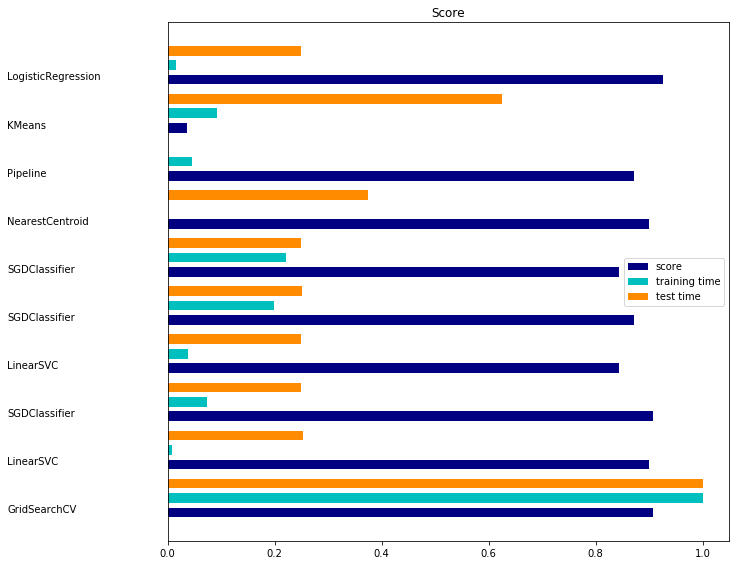

Evaluating Split 0
gridsearchRF
________________________________________________________________________________
Training: 
GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000900,
            n_jobs=None, oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 60, 70], 'min_samples_leaf': [1, 11]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


train time: 1.329s
test time:  0.005s
accuracy:   0.881
classification report:
                         precision    recall  f1-score   support

            Make Update       0.93      1.00      0.96        37
          Setup Printer       0.92      0.92      0.92        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.86      0.80      0.83        40
                   None       0.20      0.20      0.20         5

              micro avg       0.88      0.88      0.88       109
              macro avg       0.78      0.78      0.78       109
           weighted avg       0.88      0.88      0.88       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 12  0  1  0]
 [ 0  0 14  0  0]
 [ 3  1  0 32  4]
 [ 0  0  0  4  1]]

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.108s
test time:  0.002s
accuracy:   0.862
dimensionality: 3748
density: 0.405229

classification report:
                         precision    recall  f1-score   support

            Make Update       0.95      1.00      0.97        37
          Setup Printer       0.93      1.00      0.96        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.96      0.65      0.78        40
                   None       0.27      0.80      0.40         5

              micro avg       0.86      0.86      0.86       109
              macro avg       0.82      0.89      0.82       109
           weighted avg       0.93      0.86      0.88       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  1  0 26 11]
 [ 0  0  0  1  4]]

L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     interce

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.041s
test time:  0.003s
accuracy:   0.835
dimensionality: 3748
density: 0.005870

classification report:
                         precision    recall  f1-score   support

            Make Update       0.97      0.84      0.90        37
          Setup Printer       0.72      1.00      0.84        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.86      0.78      0.82        40
                   None       0.22      0.40      0.29         5

              micro avg       0.83      0.83      0.83       109
              macro avg       0.75      0.80      0.77       109
           weighted avg       0.87      0.83      0.85       109

confusion matrix:
[[31  3  0  3  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 1  1  0 31  7]
 [ 0  1  0  2  2]]

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, 

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.284s
test time:  0.002s
accuracy:   0.899
dimensionality: 3748
density: 0.444610

classification report:
                         precision    recall  f1-score   support

            Make Update       0.97      0.86      0.91        37
          Setup Printer       1.00      1.00      1.00        13
      Shutdown Computer       0.93      1.00      0.97        14
Software Recommendation       0.83      0.95      0.88        40
                   None       0.50      0.20      0.29         5

              micro avg       0.90      0.90      0.90       109
              macro avg       0.85      0.80      0.81       109
           weighted avg       0.89      0.90      0.89       109

confusion matrix:
[[32  0  0  5  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 1  0  0 38  1]
 [ 0  0  1  3  1]]

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       ea

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.285s
test time:  0.002s
accuracy:   0.908
dimensionality: 3748
density: 0.359658

classification report:
                         precision    recall  f1-score   support

            Make Update       0.92      0.97      0.95        37
          Setup Printer       0.93      1.00      0.96        13
      Shutdown Computer       0.82      1.00      0.90        14
Software Recommendation       0.92      0.88      0.90        40
                   None       1.00      0.20      0.33         5

              micro avg       0.91      0.91      0.91       109
              macro avg       0.92      0.81      0.81       109
           weighted avg       0.91      0.91      0.90       109

confusion matrix:
[[36  0  0  1  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  0  2 35  0]
 [ 0  1  1  2  1]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_thresho

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.068s
test time:  0.001s
accuracy:   0.862
classification report:
                         precision    recall  f1-score   support

            Make Update       0.91      0.86      0.89        37
          Setup Printer       0.86      0.92      0.89        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.89      0.80      0.84        40
                   None       0.40      0.80      0.53         5

              micro avg       0.86      0.86      0.86       109
              macro avg       0.81      0.88      0.83       109
           weighted avg       0.89      0.86      0.87       109

confusion matrix:
[[32  2  0  3  0]
 [ 1 12  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  0 32  6]
 [ 0  0  0  1  4]]

KMeans
________________________________________________________________________________
Training: 
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_d

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.037
classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.00      0.00      0.00        37
          Setup Printer       0.04      0.31      0.07        13
      Shutdown Computer       0.00      0.00      0.00        14
Software Recommendation       0.00      0.00      0.00        40
                   None       0.00      0.00      0.00         5

              micro avg       0.04      0.04      0.04       109
              macro avg       0.01      0.06      0.01       109
           weighted avg       0.00      0.04      0.01       109

confusion matrix:
[[ 0 37  0  0  0]
 [ 9  4  0  0  0]
 [ 0 14  0  0  0]
 [ 1 39  0  0  0]
 [ 1  4  0  0  0]]

LogisticRegression
________________________________________________________________________________
Training: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=Non

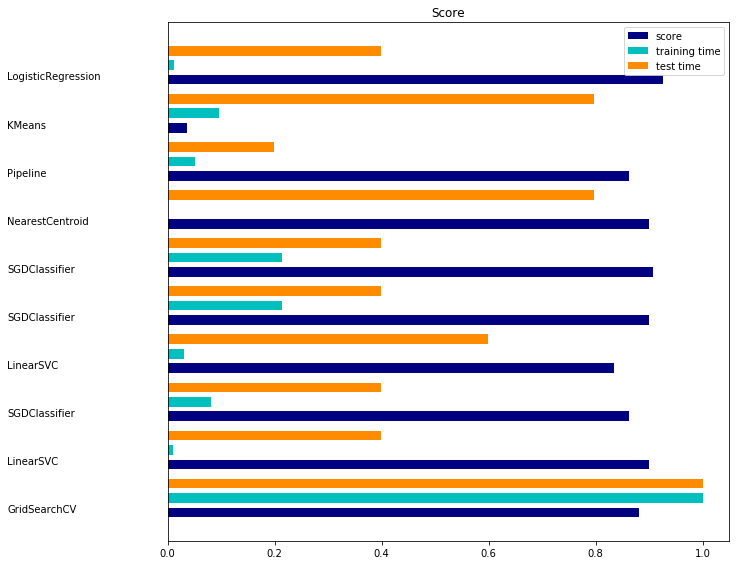

Evaluating Split 0
gridsearchRF
________________________________________________________________________________
Training: 
GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000900,
            n_jobs=None, oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 60, 70], 'min_samples_leaf': [1, 11]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


train time: 1.357s
test time:  0.005s
accuracy:   0.899
classification report:
                         precision    recall  f1-score   support

            Make Update       0.93      1.00      0.96        37
          Setup Printer       1.00      0.92      0.96        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.87      0.85      0.86        40
                   None       0.25      0.20      0.22         5

              micro avg       0.90      0.90      0.90       109
              macro avg       0.81      0.79      0.80       109
           weighted avg       0.89      0.90      0.90       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 12  0  1  0]
 [ 0  0 14  0  0]
 [ 3  0  0 34  3]
 [ 0  0  0  4  1]]

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.108s
test time:  0.003s


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.917
dimensionality: 3748
density: 0.443917

classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.90      1.00      0.95        37
          Setup Printer       0.92      0.92      0.92        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.90      0.93      0.91        40
                   None       0.00      0.00      0.00         5

              micro avg       0.92      0.92      0.92       109
              macro avg       0.75      0.77      0.76       109
           weighted avg       0.88      0.92      0.90       109

confusion matrix:
[[37  0  0  0  0]
 [ 1 12  0  0  0]
 [ 0  0 14  0  0]
 [ 3  0  0 37  0]
 [ 0  1  0  4  0]]

L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.001,


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.038s
test time:  0.003s
accuracy:   0.853
dimensionality: 3748
density: 0.006137

classification report:
                         precision    recall  f1-score   support

            Make Update       0.97      0.84      0.90        37
          Setup Printer       0.72      1.00      0.84        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.87      0.82      0.85        40
                   None       0.29      0.40      0.33         5

              micro avg       0.85      0.85      0.85       109
              macro avg       0.77      0.81      0.78       109
           weighted avg       0.88      0.85      0.86       109

confusion matrix:
[[31  3  0  3  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 1  1  0 33  5]
 [ 0  1  0  2  2]]

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, 

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.284s
test time:  0.002s
accuracy:   0.881
dimensionality: 3748
density: 0.385912

classification report:
                         precision    recall  f1-score   support

            Make Update       0.90      0.95      0.92        37
          Setup Printer       0.92      0.92      0.92        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.83      0.88      0.85        40
                   None       0.00      0.00      0.00         5

              micro avg       0.88      0.88      0.88       109
              macro avg       0.73      0.75      0.74       109
           weighted avg       0.85      0.88      0.86       109

confusion matrix:
[[35  0  0  2  0]
 [ 1 12  0  0  0]
 [ 0  0 14  0  0]
 [ 3  1  0 35  1]
 [ 0  0  0  5  0]]

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       ea

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.301s
test time:  0.002s
accuracy:   0.908
dimensionality: 3748
density: 0.433031

classification report:
                         precision    recall  f1-score   support

            Make Update       0.95      0.95      0.95        37
          Setup Printer       1.00      1.00      1.00        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.89      0.85      0.87        40
                   None       0.43      0.60      0.50         5

              micro avg       0.91      0.91      0.91       109
              macro avg       0.85      0.88      0.86       109
           weighted avg       0.92      0.91      0.91       109

confusion matrix:
[[35  0  0  2  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  0 34  4]
 [ 0  0  0  2  3]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_thresho

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.068s
test time:  0.001s
accuracy:   0.881
classification report:
                         precision    recall  f1-score   support

            Make Update       0.94      0.89      0.92        37
          Setup Printer       0.87      1.00      0.93        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.91      0.80      0.85        40
                   None       0.40      0.80      0.53         5

              micro avg       0.88      0.88      0.88       109
              macro avg       0.82      0.90      0.85       109
           weighted avg       0.91      0.88      0.89       109

confusion matrix:
[[33  2  0  2  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  0 32  6]
 [ 0  0  0  1  4]]

KMeans
________________________________________________________________________________
Training: 
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_d

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.037
classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.00      0.00      0.00        37
          Setup Printer       0.04      0.31      0.07        13
      Shutdown Computer       0.00      0.00      0.00        14
Software Recommendation       0.00      0.00      0.00        40
                   None       0.00      0.00      0.00         5

              micro avg       0.04      0.04      0.04       109
              macro avg       0.01      0.06      0.01       109
           weighted avg       0.00      0.04      0.01       109

confusion matrix:
[[ 0 37  0  0  0]
 [ 9  4  0  0  0]
 [ 0 14  0  0  0]
 [ 1 39  0  0  0]
 [ 1  4  0  0  0]]

LogisticRegression
________________________________________________________________________________
Training: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=Non

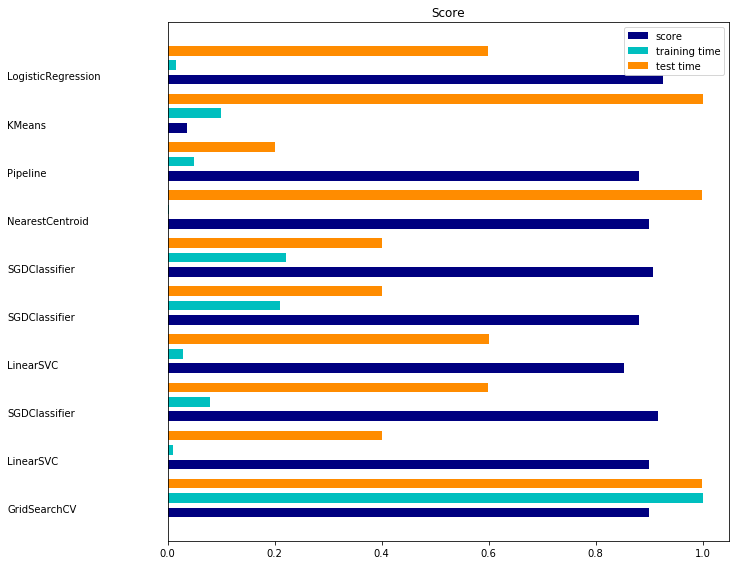

Evaluating Split 0
gridsearchRF
________________________________________________________________________________
Training: 
GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000900,
            n_jobs=None, oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 60, 70], 'min_samples_leaf': [1, 11]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


train time: 1.365s
test time:  0.006s
accuracy:   0.881
classification report:
                         precision    recall  f1-score   support

            Make Update       0.93      1.00      0.96        37
          Setup Printer       1.00      0.92      0.96        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.85      0.82      0.84        40
                   None       0.00      0.00      0.00         5

              micro avg       0.88      0.88      0.88       109
              macro avg       0.75      0.75      0.75       109
           weighted avg       0.87      0.88      0.88       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 12  0  1  0]
 [ 0  0 14  0  0]
 [ 3  0  0 33  4]
 [ 0  0  0  5  0]]

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.099s
test time:  0.002s
accuracy:   0.899
dimensionality: 3748
density: 0.442743

classification report:
                         precision    recall  f1-score   support

            Make Update       1.00      0.86      0.93        37
          Setup Printer       1.00      1.00      1.00        13
      Shutdown Computer       0.93      1.00      0.97        14
Software Recommendation       0.84      0.93      0.88        40
                   None       0.40      0.40      0.40         5

              micro avg       0.90      0.90      0.90       109
              macro avg       0.83      0.84      0.83       109
           weighted avg       0.91      0.90      0.90       109

confusion matrix:
[[32  0  1  4  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 0  0  0 37  3]
 [ 0  0  0  3  2]]

L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     interce

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.042s
test time:  0.002s
accuracy:   0.872
dimensionality: 3748
density: 0.005923

classification report:
                         precision    recall  f1-score   support

            Make Update       0.97      0.86      0.91        37
          Setup Printer       0.72      1.00      0.84        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.89      0.85      0.87        40
                   None       0.33      0.40      0.36         5

              micro avg       0.87      0.87      0.87       109
              macro avg       0.78      0.82      0.80       109
           weighted avg       0.89      0.87      0.88       109

confusion matrix:
[[32  3  0  2  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 1  1  0 34  4]
 [ 0  1  0  2  2]]

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, 

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.308s
test time:  0.002s
accuracy:   0.872
dimensionality: 3748
density: 0.354429

classification report:
                         precision    recall  f1-score   support

            Make Update       0.92      0.95      0.93        37
          Setup Printer       0.93      1.00      0.96        13
      Shutdown Computer       0.88      1.00      0.93        14
Software Recommendation       0.86      0.78      0.82        40
                   None       0.40      0.40      0.40         5

              micro avg       0.87      0.87      0.87       109
              macro avg       0.80      0.82      0.81       109
           weighted avg       0.87      0.87      0.87       109

confusion matrix:
[[35  0  0  2  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  1  2 31  3]
 [ 0  0  0  3  2]]

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       ea

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.313s
test time:  0.002s
accuracy:   0.872
dimensionality: 3748
density: 0.371825

classification report:
                         precision    recall  f1-score   support

            Make Update       0.94      0.92      0.93        37
          Setup Printer       0.93      1.00      0.96        13
      Shutdown Computer       0.74      1.00      0.85        14
Software Recommendation       0.89      0.80      0.84        40
                   None       0.50      0.40      0.44         5

              micro avg       0.87      0.87      0.87       109
              macro avg       0.80      0.82      0.81       109
           weighted avg       0.88      0.87      0.87       109

confusion matrix:
[[34  0  0  3  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  1  3 32  2]
 [ 0  0  2  1  2]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_thresho

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.069s
test time:  0.001s
accuracy:   0.853
classification report:
                         precision    recall  f1-score   support

            Make Update       0.94      0.86      0.90        37
          Setup Printer       0.87      1.00      0.93        13
      Shutdown Computer       0.93      1.00      0.97        14
Software Recommendation       0.88      0.75      0.81        40
                   None       0.36      0.80      0.50         5

              micro avg       0.85      0.85      0.85       109
              macro avg       0.80      0.88      0.82       109
           weighted avg       0.88      0.85      0.86       109

confusion matrix:
[[32  2  0  3  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  1 30  7]
 [ 0  0  0  1  4]]

KMeans
________________________________________________________________________________
Training: 
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_d

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.037
classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.00      0.00      0.00        37
          Setup Printer       0.04      0.31      0.07        13
      Shutdown Computer       0.00      0.00      0.00        14
Software Recommendation       0.00      0.00      0.00        40
                   None       0.00      0.00      0.00         5

              micro avg       0.04      0.04      0.04       109
              macro avg       0.01      0.06      0.01       109
           weighted avg       0.00      0.04      0.01       109

confusion matrix:
[[ 0 37  0  0  0]
 [ 9  4  0  0  0]
 [ 0 14  0  0  0]
 [ 1 39  0  0  0]
 [ 1  4  0  0  0]]

LogisticRegression
________________________________________________________________________________
Training: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=Non

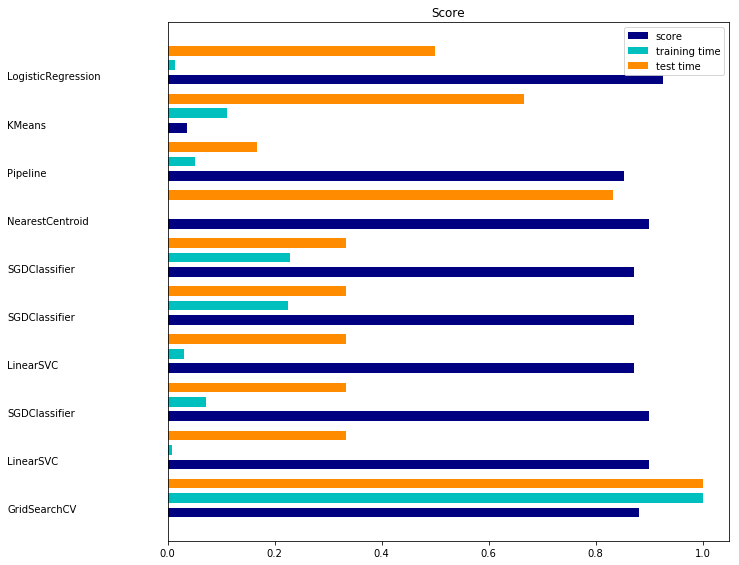

Evaluating Split 0
gridsearchRF
________________________________________________________________________________
Training: 
GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000900,
            n_jobs=None, oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 60, 70], 'min_samples_leaf': [1, 11]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


train time: 1.524s
test time:  0.005s
accuracy:   0.881
classification report:
                         precision    recall  f1-score   support

            Make Update       0.93      1.00      0.96        37
          Setup Printer       1.00      0.92      0.96        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.85      0.82      0.84        40
                   None       0.00      0.00      0.00         5

              micro avg       0.88      0.88      0.88       109
              macro avg       0.75      0.75      0.75       109
           weighted avg       0.87      0.88      0.88       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 12  0  1  0]
 [ 0  0 14  0  0]
 [ 3  0  0 33  4]
 [ 0  0  0  5  0]]

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.113s
test time:  0.003s
accuracy:   0.844
dimensionality: 3748
density: 0.425880

classification report:
                         precision    recall  f1-score   support

            Make Update       0.90      0.97      0.94        37
          Setup Printer       0.92      0.92      0.92        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.88      0.70      0.78        40
                   None       0.20      0.40      0.27         5

              micro avg       0.84      0.84      0.84       109
              macro avg       0.78      0.80      0.78       109
           weighted avg       0.87      0.84      0.85       109

confusion matrix:
[[36  0  0  1  0]
 [ 1 12  0  0  0]
 [ 0  0 14  0  0]
 [ 3  1  0 28  8]
 [ 0  0  0  3  2]]

L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     interce

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.035s
test time:  0.002s
accuracy:   0.872
dimensionality: 3748
density: 0.005816

classification report:
                         precision    recall  f1-score   support

            Make Update       0.94      0.86      0.90        37
          Setup Printer       0.72      1.00      0.84        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.89      0.85      0.87        40
                   None       0.40      0.40      0.40         5

              micro avg       0.87      0.87      0.87       109
              macro avg       0.79      0.82      0.80       109
           weighted avg       0.88      0.87      0.87       109

confusion matrix:
[[32  3  0  2  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  1  0 34  3]
 [ 0  1  0  2  2]]

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, 

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.274s
test time:  0.002s
accuracy:   0.862
dimensionality: 3748
density: 0.366916

classification report:
                         precision    recall  f1-score   support

            Make Update       0.97      0.84      0.90        37
          Setup Printer       0.65      1.00      0.79        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.90      0.90      0.90        40
                   None       0.00      0.00      0.00         5

              micro avg       0.86      0.86      0.86       109
              macro avg       0.70      0.75      0.72       109
           weighted avg       0.87      0.86      0.86       109

confusion matrix:
[[31  3  0  2  1]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 1  1  0 36  2]
 [ 0  3  0  2  0]]

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       ea

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.292s
test time:  0.002s
accuracy:   0.899
dimensionality: 3748
density: 0.382551

classification report:
                         precision    recall  f1-score   support

            Make Update       0.88      0.95      0.91        37
          Setup Printer       1.00      1.00      1.00        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.90      0.88      0.89        40
                   None       0.33      0.20      0.25         5

              micro avg       0.90      0.90      0.90       109
              macro avg       0.82      0.80      0.81       109
           weighted avg       0.89      0.90      0.89       109

confusion matrix:
[[35  0  0  2  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  0  0 35  2]
 [ 2  0  0  2  1]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_thresho

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.062s
test time:  0.001s
accuracy:   0.853
classification report:
                         precision    recall  f1-score   support

            Make Update       0.91      0.86      0.89        37
          Setup Printer       0.86      0.92      0.89        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.86      0.80      0.83        40
                   None       0.33      0.60      0.43         5

              micro avg       0.85      0.85      0.85       109
              macro avg       0.79      0.84      0.81       109
           weighted avg       0.87      0.85      0.86       109

confusion matrix:
[[32  2  0  3  0]
 [ 1 12  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  0 32  6]
 [ 0  0  0  2  3]]

KMeans
________________________________________________________________________________
Training: 
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_d

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.037
classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.00      0.00      0.00        37
          Setup Printer       0.04      0.31      0.07        13
      Shutdown Computer       0.00      0.00      0.00        14
Software Recommendation       0.00      0.00      0.00        40
                   None       0.00      0.00      0.00         5

              micro avg       0.04      0.04      0.04       109
              macro avg       0.01      0.06      0.01       109
           weighted avg       0.00      0.04      0.01       109

confusion matrix:
[[ 0 37  0  0  0]
 [ 9  4  0  0  0]
 [ 0 14  0  0  0]
 [ 1 39  0  0  0]
 [ 1  4  0  0  0]]

LogisticRegression
________________________________________________________________________________
Training: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=Non

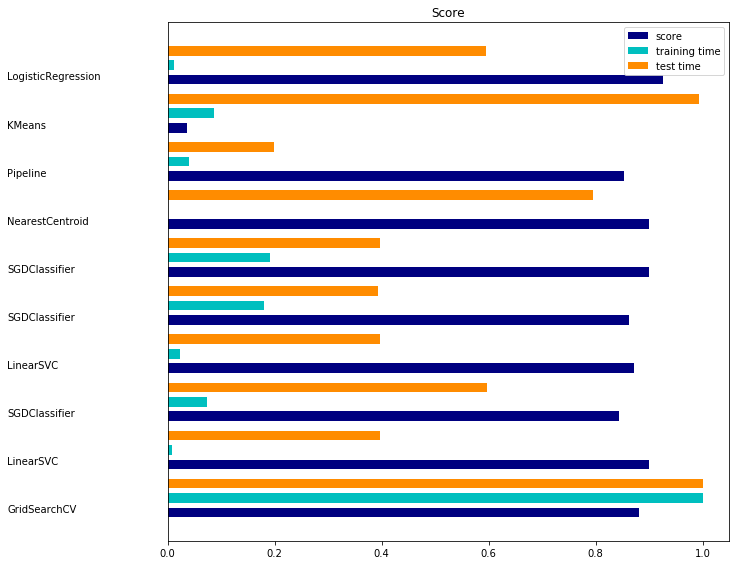

Evaluating Split 0
gridsearchRF
________________________________________________________________________________
Training: 
GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000900,
            n_jobs=None, oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 60, 70], 'min_samples_leaf': [1, 11]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


train time: 1.331s
test time:  0.005s
accuracy:   0.853
classification report:
                         precision    recall  f1-score   support

            Make Update       0.93      1.00      0.96        37
          Setup Printer       1.00      0.92      0.96        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.85      0.72      0.78        40
                   None       0.11      0.20      0.14         5

              micro avg       0.85      0.85      0.85       109
              macro avg       0.78      0.77      0.77       109
           weighted avg       0.88      0.85      0.86       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 12  0  1  0]
 [ 0  0 14  0  0]
 [ 3  0  0 29  8]
 [ 0  0  0  4  1]]

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.107s
test time:  0.002s
accuracy:   0.908
dimensionality: 3748
density: 0.412273

classification report:
                         precision    recall  f1-score   support

            Make Update       0.92      0.95      0.93        37
          Setup Printer       1.00      1.00      1.00        13
      Shutdown Computer       1.00      0.93      0.96        14
Software Recommendation       0.88      0.88      0.88        40
                   None       0.60      0.60      0.60         5

              micro avg       0.91      0.91      0.91       109
              macro avg       0.88      0.87      0.87       109
           weighted avg       0.91      0.91      0.91       109

confusion matrix:
[[35  0  0  2  0]
 [ 0 13  0  0  0]
 [ 0  0 13  1  0]
 [ 3  0  0 35  2]
 [ 0  0  0  2  3]]

L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     interce

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.041s
test time:  0.003s
accuracy:   0.844
dimensionality: 3748
density: 0.005977

classification report:
                         precision    recall  f1-score   support

            Make Update       0.94      0.84      0.89        37
          Setup Printer       0.72      1.00      0.84        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.86      0.80      0.83        40
                   None       0.29      0.40      0.33         5

              micro avg       0.84      0.84      0.84       109
              macro avg       0.76      0.81      0.78       109
           weighted avg       0.86      0.84      0.85       109

confusion matrix:
[[31  3  0  3  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  1  0 32  5]
 [ 0  1  0  2  2]]

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, 

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.296s
test time:  0.002s
accuracy:   0.908
dimensionality: 3748
density: 0.377855

classification report:
                         precision    recall  f1-score   support

            Make Update       0.95      0.97      0.96        37
          Setup Printer       1.00      1.00      1.00        13
      Shutdown Computer       0.93      1.00      0.97        14
Software Recommendation       0.92      0.85      0.88        40
                   None       0.33      0.40      0.36         5

              micro avg       0.91      0.91      0.91       109
              macro avg       0.83      0.84      0.83       109
           weighted avg       0.91      0.91      0.91       109

confusion matrix:
[[36  0  0  1  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  0 34  4]
 [ 0  0  1  2  2]]

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       ea

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.309s
test time:  0.002s


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.908
dimensionality: 3748
density: 0.379189

classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.93      1.00      0.96        37
          Setup Printer       0.76      1.00      0.87        13
      Shutdown Computer       0.93      1.00      0.97        14
Software Recommendation       0.95      0.88      0.91        40
                   None       0.00      0.00      0.00         5

              micro avg       0.91      0.91      0.91       109
              macro avg       0.71      0.78      0.74       109
           weighted avg       0.87      0.91      0.89       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  2  0 35  0]
 [ 0  2  1  2  0]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.002s
test time:  0.004s
accuracy:   0.899
classification report:
                         precis

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.063s
test time:  0.001s
accuracy:   0.853
classification report:
                         precision    recall  f1-score   support

            Make Update       0.91      0.86      0.89        37
          Setup Printer       0.86      0.92      0.89        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.89      0.78      0.83        40
                   None       0.36      0.80      0.50         5

              micro avg       0.85      0.85      0.85       109
              macro avg       0.80      0.87      0.82       109
           weighted avg       0.88      0.85      0.86       109

confusion matrix:
[[32  2  0  3  0]
 [ 1 12  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  0 31  7]
 [ 0  0  0  1  4]]

KMeans
________________________________________________________________________________
Training: 
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_d

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.037
classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.00      0.00      0.00        37
          Setup Printer       0.04      0.31      0.07        13
      Shutdown Computer       0.00      0.00      0.00        14
Software Recommendation       0.00      0.00      0.00        40
                   None       0.00      0.00      0.00         5

              micro avg       0.04      0.04      0.04       109
              macro avg       0.01      0.06      0.01       109
           weighted avg       0.00      0.04      0.01       109

confusion matrix:
[[ 0 37  0  0  0]
 [ 9  4  0  0  0]
 [ 0 14  0  0  0]
 [ 1 39  0  0  0]
 [ 1  4  0  0  0]]

LogisticRegression
________________________________________________________________________________
Training: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=Non

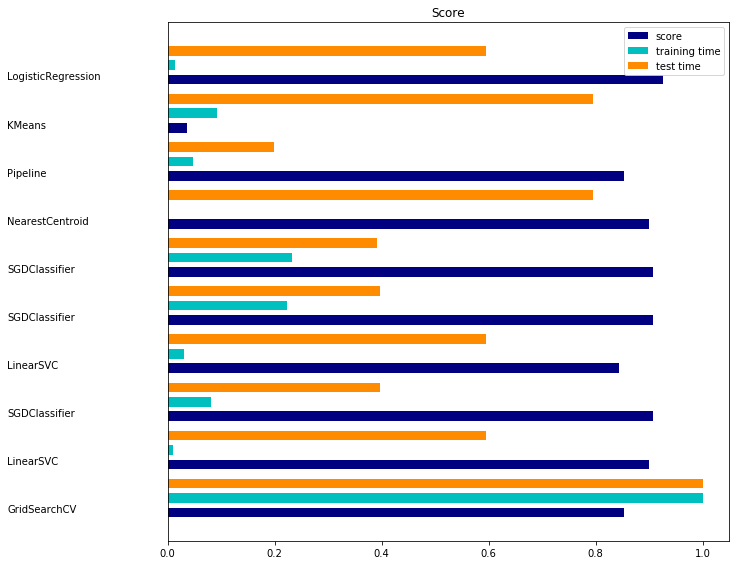

Evaluating Split 0
gridsearchRF
________________________________________________________________________________
Training: 
GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000900,
            n_jobs=None, oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 60, 70], 'min_samples_leaf': [1, 11]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


train time: 1.396s
test time:  0.005s
accuracy:   0.899
classification report:
                         precision    recall  f1-score   support

            Make Update       0.93      1.00      0.96        37
          Setup Printer       1.00      0.92      0.96        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.87      0.85      0.86        40
                   None       0.25      0.20      0.22         5

              micro avg       0.90      0.90      0.90       109
              macro avg       0.81      0.79      0.80       109
           weighted avg       0.89      0.90      0.90       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 12  0  1  0]
 [ 0  0 14  0  0]
 [ 3  0  0 34  3]
 [ 0  0  0  4  1]]

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.100s
test time:  0.002s
accuracy:   0.917
dimensionality: 3748
density: 0.462753

classification report:
                         precision    recall  f1-score   support

            Make Update       0.95      0.95      0.95        37
          Setup Printer       1.00      1.00      1.00        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.86      0.93      0.89        40
                   None       0.50      0.20      0.29         5

              micro avg       0.92      0.92      0.92       109
              macro avg       0.86      0.81      0.82       109
           weighted avg       0.91      0.92      0.91       109

confusion matrix:
[[35  0  0  2  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  0 37  1]
 [ 0  0  0  4  1]]

L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     interce

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.042s
test time:  0.002s
accuracy:   0.826
dimensionality: 3748
density: 0.006190

classification report:
                         precision    recall  f1-score   support

            Make Update       0.97      0.84      0.90        37
          Setup Printer       0.72      1.00      0.84        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.86      0.75      0.80        40
                   None       0.20      0.40      0.27         5

              micro avg       0.83      0.83      0.83       109
              macro avg       0.75      0.80      0.76       109
           weighted avg       0.87      0.83      0.84       109

confusion matrix:
[[31  3  0  3  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 1  1  0 30  8]
 [ 0  1  0  2  2]]

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, 

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.295s
test time:  0.002s
accuracy:   0.917
dimensionality: 3748
density: 0.402508

classification report:
                         precision    recall  f1-score   support

            Make Update       0.90      0.97      0.94        37
          Setup Printer       1.00      0.92      0.96        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.88      0.93      0.90        40
                   None       1.00      0.20      0.33         5

              micro avg       0.92      0.92      0.92       109
              macro avg       0.96      0.80      0.83       109
           weighted avg       0.92      0.92      0.91       109

confusion matrix:
[[36  0  0  1  0]
 [ 1 12  0  0  0]
 [ 0  0 14  0  0]
 [ 3  0  0 37  0]
 [ 0  0  0  4  1]]

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       ea

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.294s
test time:  0.002s


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.862
dimensionality: 3748
density: 0.345784

classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.94      0.89      0.92        37
          Setup Printer       0.76      1.00      0.87        13
      Shutdown Computer       0.78      1.00      0.88        14
Software Recommendation       0.87      0.85      0.86        40
                   None       0.00      0.00      0.00         5

              micro avg       0.86      0.86      0.86       109
              macro avg       0.67      0.75      0.70       109
           weighted avg       0.83      0.86      0.84       109

confusion matrix:
[[33  1  1  2  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  3  1 34  0]
 [ 0  0  2  3  0]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.002s
test time:  0.005s
accuracy:   0.899
classification report:
                         precis

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.063s
test time:  0.001s
accuracy:   0.862
classification report:
                         precision    recall  f1-score   support

            Make Update       0.91      0.86      0.89        37
          Setup Printer       0.86      0.92      0.89        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.89      0.80      0.84        40
                   None       0.40      0.80      0.53         5

              micro avg       0.86      0.86      0.86       109
              macro avg       0.81      0.88      0.83       109
           weighted avg       0.89      0.86      0.87       109

confusion matrix:
[[32  2  0  3  0]
 [ 1 12  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  0 32  6]
 [ 0  0  0  1  4]]

KMeans
________________________________________________________________________________
Training: 
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_d

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.037
classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.00      0.00      0.00        37
          Setup Printer       0.04      0.31      0.07        13
      Shutdown Computer       0.00      0.00      0.00        14
Software Recommendation       0.00      0.00      0.00        40
                   None       0.00      0.00      0.00         5

              micro avg       0.04      0.04      0.04       109
              macro avg       0.01      0.06      0.01       109
           weighted avg       0.00      0.04      0.01       109

confusion matrix:
[[ 0 37  0  0  0]
 [ 9  4  0  0  0]
 [ 0 14  0  0  0]
 [ 1 39  0  0  0]
 [ 1  4  0  0  0]]

LogisticRegression
________________________________________________________________________________
Training: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=Non

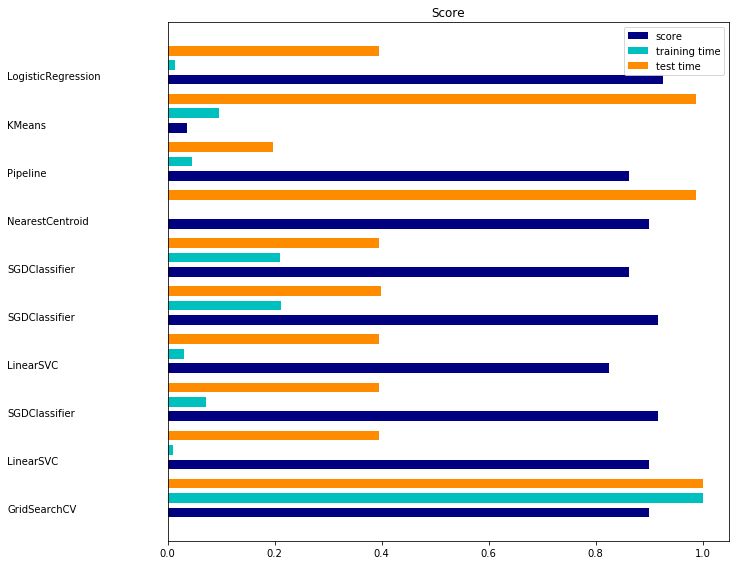

Evaluating Split 0
gridsearchRF
________________________________________________________________________________
Training: 
GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000900,
            n_jobs=None, oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 60, 70], 'min_samples_leaf': [1, 11]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


train time: 1.376s
test time:  0.005s
accuracy:   0.908
classification report:
                         precision    recall  f1-score   support

            Make Update       0.92      0.97      0.95        37
          Setup Printer       0.92      0.92      0.92        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.88      0.88      0.88        40
                   None       0.67      0.40      0.50         5

              micro avg       0.91      0.91      0.91       109
              macro avg       0.88      0.83      0.85       109
           weighted avg       0.90      0.91      0.90       109

confusion matrix:
[[36  0  0  1  0]
 [ 0 12  0  1  0]
 [ 0  0 14  0  0]
 [ 3  1  0 35  1]
 [ 0  0  0  3  2]]

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.110s
test time:  0.002s
accuracy:   0.890
dimensionality: 3748
density: 0.416542

classification report:
                         precision    recall  f1-score   support

            Make Update       0.78      0.97      0.87        37
          Setup Printer       1.00      1.00      1.00        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.94      0.82      0.88        40
                   None       1.00      0.20      0.33         5

              micro avg       0.89      0.89      0.89       109
              macro avg       0.95      0.80      0.82       109
           weighted avg       0.91      0.89      0.88       109

confusion matrix:
[[36  0  0  1  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 7  0  0 33  0]
 [ 3  0  0  1  1]]

L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     interce

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.042s
test time:  0.002s
accuracy:   0.844
dimensionality: 3748
density: 0.006137

classification report:
                         precision    recall  f1-score   support

            Make Update       0.97      0.86      0.91        37
          Setup Printer       0.68      1.00      0.81        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.89      0.78      0.83        40
                   None       0.25      0.40      0.31         5

              micro avg       0.84      0.84      0.84       109
              macro avg       0.76      0.81      0.77       109
           weighted avg       0.88      0.84      0.85       109

confusion matrix:
[[32  3  0  2  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 1  2  0 31  6]
 [ 0  1  0  2  2]]

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, 

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.266s
test time:  0.002s
accuracy:   0.908
dimensionality: 3748
density: 0.388367

classification report:
                         precision    recall  f1-score   support

            Make Update       0.92      0.95      0.93        37
          Setup Printer       0.93      1.00      0.96        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.86      0.90      0.88        40
                   None       1.00      0.20      0.33         5

              micro avg       0.91      0.91      0.91       109
              macro avg       0.94      0.81      0.82       109
           weighted avg       0.91      0.91      0.90       109

confusion matrix:
[[35  0  0  2  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  1  0 36  0]
 [ 0  0  0  4  1]]

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       ea

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.303s
test time:  0.002s
accuracy:   0.862
dimensionality: 3748
density: 0.426094

classification report:
                         precision    recall  f1-score   support

            Make Update       0.94      0.92      0.93        37
          Setup Printer       1.00      1.00      1.00        13
      Shutdown Computer       0.78      1.00      0.88        14
Software Recommendation       0.91      0.75      0.82        40
                   None       0.33      0.60      0.43         5

              micro avg       0.86      0.86      0.86       109
              macro avg       0.79      0.85      0.81       109
           weighted avg       0.89      0.86      0.87       109

confusion matrix:
[[34  0  0  3  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  2 30  6]
 [ 0  0  2  0  3]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_thresho

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.064s
test time:  0.001s
accuracy:   0.899
classification report:
                         precision    recall  f1-score   support

            Make Update       0.94      0.92      0.93        37
          Setup Printer       0.93      1.00      0.96        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.89      0.85      0.87        40
                   None       0.43      0.60      0.50         5

              micro avg       0.90      0.90      0.90       109
              macro avg       0.84      0.87      0.85       109
           weighted avg       0.91      0.90      0.90       109

confusion matrix:
[[34  1  0  2  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  0 34  4]
 [ 0  0  0  2  3]]

KMeans
________________________________________________________________________________
Training: 
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_d

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.037
classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.00      0.00      0.00        37
          Setup Printer       0.04      0.31      0.07        13
      Shutdown Computer       0.00      0.00      0.00        14
Software Recommendation       0.00      0.00      0.00        40
                   None       0.00      0.00      0.00         5

              micro avg       0.04      0.04      0.04       109
              macro avg       0.01      0.06      0.01       109
           weighted avg       0.00      0.04      0.01       109

confusion matrix:
[[ 0 37  0  0  0]
 [ 9  4  0  0  0]
 [ 0 14  0  0  0]
 [ 1 39  0  0  0]
 [ 1  4  0  0  0]]

LogisticRegression
________________________________________________________________________________
Training: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=Non

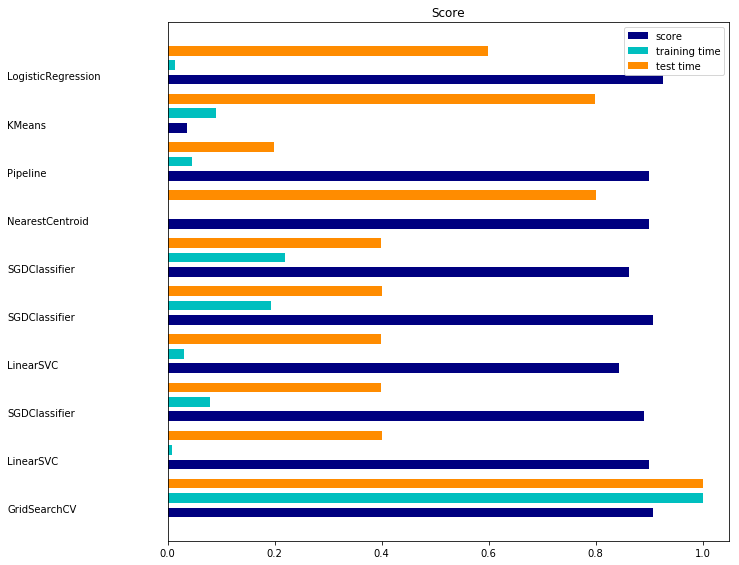

Evaluating Split 0
gridsearchRF
________________________________________________________________________________
Training: 
GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000900,
            n_jobs=None, oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 60, 70], 'min_samples_leaf': [1, 11]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


train time: 1.305s
test time:  0.005s
accuracy:   0.881
classification report:
                         precision    recall  f1-score   support

            Make Update       0.92      0.97      0.95        37
          Setup Printer       0.92      0.92      0.92        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.83      0.85      0.84        40
                   None       0.00      0.00      0.00         5

              micro avg       0.88      0.88      0.88       109
              macro avg       0.74      0.75      0.74       109
           weighted avg       0.86      0.88      0.87       109

confusion matrix:
[[36  0  0  1  0]
 [ 0 12  0  1  0]
 [ 0  0 14  0  0]
 [ 3  1  0 34  2]
 [ 0  0  0  5  0]]

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.110s
test time:  0.002s
accuracy:   0.917
dimensionality: 3748
density: 0.425667

classification report:
                         precision    recall  f1-score   support

            Make Update       0.92      0.92      0.92        37
          Setup Printer       1.00      1.00      1.00        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.88      0.90      0.89        40
                   None       0.75      0.60      0.67         5

              micro avg       0.92      0.92      0.92       109
              macro avg       0.91      0.88      0.89       109
           weighted avg       0.92      0.92      0.92       109

confusion matrix:
[[34  0  0  3  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  0  0 36  1]
 [ 0  0  0  2  3]]

L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     interce

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.042s
test time:  0.002s
accuracy:   0.844
dimensionality: 3748
density: 0.006243

classification report:
                         precision    recall  f1-score   support

            Make Update       0.94      0.84      0.89        37
          Setup Printer       0.76      1.00      0.87        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.86      0.80      0.83        40
                   None       0.25      0.40      0.31         5

              micro avg       0.84      0.84      0.84       109
              macro avg       0.76      0.81      0.78       109
           weighted avg       0.87      0.84      0.85       109

confusion matrix:
[[31  3  0  3  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  0 32  6]
 [ 0  1  0  2  2]]

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, 

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.302s
test time:  0.002s
accuracy:   0.853
dimensionality: 3748
density: 0.437300

classification report:
                         precision    recall  f1-score   support

            Make Update       1.00      0.76      0.86        37
          Setup Printer       0.65      1.00      0.79        13
      Shutdown Computer       0.88      1.00      0.93        14
Software Recommendation       0.86      0.93      0.89        40
                   None       0.50      0.20      0.29         5

              micro avg       0.85      0.85      0.85       109
              macro avg       0.78      0.78      0.75       109
           weighted avg       0.87      0.85      0.85       109

confusion matrix:
[[28  6  1  2  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 0  1  1 37  1]
 [ 0  0  0  4  1]]

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       ea

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.326s
test time:  0.002s
accuracy:   0.908
dimensionality: 3748
density: 0.429936

classification report:
                         precision    recall  f1-score   support

            Make Update       0.94      0.92      0.93        37
          Setup Printer       1.00      1.00      1.00        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.86      0.90      0.88        40
                   None       0.50      0.40      0.44         5

              micro avg       0.91      0.91      0.91       109
              macro avg       0.86      0.84      0.85       109
           weighted avg       0.91      0.91      0.91       109

confusion matrix:
[[34  0  0  3  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  0 36  2]
 [ 0  0  0  3  2]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_thresho

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.057s
test time:  0.001s
accuracy:   0.844
classification report:
                         precision    recall  f1-score   support

            Make Update       0.94      0.86      0.90        37
          Setup Printer       0.76      1.00      0.87        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.86      0.78      0.82        40
                   None       0.25      0.40      0.31         5

              micro avg       0.84      0.84      0.84       109
              macro avg       0.76      0.81      0.78       109
           weighted avg       0.87      0.84      0.85       109

confusion matrix:
[[32  2  0  3  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  1  0 31  6]
 [ 0  1  0  2  2]]

KMeans
________________________________________________________________________________
Training: 
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_d

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.037
classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.00      0.00      0.00        37
          Setup Printer       0.04      0.31      0.07        13
      Shutdown Computer       0.00      0.00      0.00        14
Software Recommendation       0.00      0.00      0.00        40
                   None       0.00      0.00      0.00         5

              micro avg       0.04      0.04      0.04       109
              macro avg       0.01      0.06      0.01       109
           weighted avg       0.00      0.04      0.01       109

confusion matrix:
[[ 0 37  0  0  0]
 [ 9  4  0  0  0]
 [ 0 14  0  0  0]
 [ 1 39  0  0  0]
 [ 1  4  0  0  0]]

LogisticRegression
________________________________________________________________________________
Training: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=Non

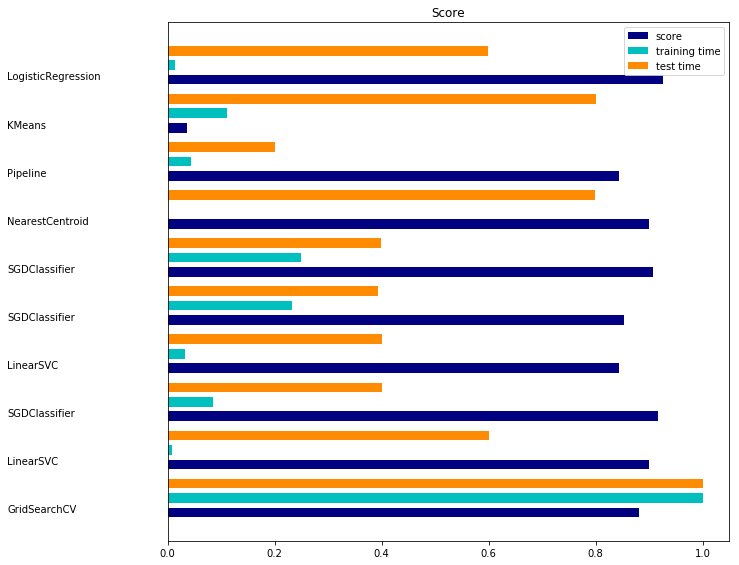

In [27]:
import matplotlib.pyplot as plt
for _ in enumerate(range(20)):
    i_s = 0
    split = 0
    print("Evaluating Split {}".format(i_s))
#     X_train, y_train, X_test, y_test, feature_names = data_for_training()
    target_names = None
    if benchmark_dataset == "Chatbot":
        target_names = ["Departure Time", "Find Connection"]
    elif benchmark_dataset == "AskUbuntu":
        target_names = ["Make Update", "Setup Printer", "Shutdown Computer","Software Recommendation", "None"]
    elif benchmark_dataset == "WebApplication":
        target_names = ["Download Video", "Change Password", "None", "Export Data", "Sync Accounts",
                  "Filter Spam", "Find Alternative", "Delete Account"]
#     print("Train Size: {}\nTest Size: {}".format(X_train.shape[0], X_test.shape[0]))
#     print("Train Size: {}\nTest Size: {}".format(X_train, X_test.shape[0]))
    results = []
    #alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
    parameters_mlp={'hidden_layer_sizes':[(100,50), (300, 100),(300,200,100)]}
    parameters_RF={ "n_estimators" : [50,60,70],
           "min_samples_leaf" : [1, 11]}
    k_range = list(range(3,7))
    parameters_knn = {'n_neighbors':k_range}
    knn=KNeighborsClassifier(n_neighbors=5)
    for clf, name in [  
            #(RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
            #(GridSearchCV(knn,parameters_knn, cv=5),"gridsearchknn"),
            #(Perceptron(n_iter=50), "Perceptron"),
            #(GridSearchCV(MLPClassifier(activation='tanh'),parameters_mlp, cv=5),"gridsearchmlp"),
           # (MLPClassifier(hidden_layer_sizes=(100, 50), activation="logistic", max_iter=300), "MLP"),
            #(MLPClassifier(hidden_layer_sizes=(300, 100, 50), activation="logistic", max_iter=500), "MLP"),
           # (MLPClassifier(hidden_layer_sizes=(300, 100, 50), activation="tanh", max_iter=500), "MLP"),
            #(PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
           # (KNeighborsClassifier(n_neighbors=1), "kNN"),
           # (KNeighborsClassifier(n_neighbors=3), "kNN"),
           # (KNeighborsClassifier(n_neighbors=5), "kNN"),
            #(KNeighborsClassifier(n_neighbors=10), "kNN"),
            (GridSearchCV(RandomForestClassifier(n_estimators=10000900),parameters_RF, cv=5),"gridsearchRF")
            #(RandomForestClassifier(n_estimators=10), "Random forest"),
            #(RandomForestClassifier(n_estimators=50), "Random forest")
    ]:
           
        print('=' * 80)
        print(name)
        result = benchmark(clf, X_train, y_train, X_test, y_test, target_names,
                                 feature_names=feature_names)
        results.append(result)
        
       # print('parameters')
       # print(clf.grid_scores_[0])
        #print('CV Validation Score')
       # print(clf.grid_scores_[0].cv_validation_scores)
       # print('Mean Validation Score')
       # print(clf.grid_scores_[0].mean_validation_score)
       # grid_mean_scores = [result.mean_validation_score for result in clf.grid_scores_]
       # print(grid_mean_scores)
       # plt.plot(k_range, grid_mean_scores)
       # plt.xlabel('Value of K for KNN')
       # plt.ylabel('Cross-Validated Accuracy')

    #parameters_Linearsvc = [{'C': [1, 10], 'gamma': [0.1,1.0]}]
    for penalty in ["l2", "l1"]:
        print('=' * 80)
        print("%s penalty" % penalty.upper())
        # Train Liblinear model
        #grid=(GridSearchCV(LinearSVC,parameters_Linearsvc, cv=10),"gridsearchSVC")
        #results.append(benchmark(LinearSVC(penalty=penalty), X_train, y_train, X_test, y_test, target_names,
                                # feature_names=feature_names))
        
        result = benchmark(LinearSVC(penalty=penalty, dual=False,tol=1e-3),
                                 X_train, y_train, X_test, y_test, target_names,
                                 feature_names=feature_names)
        results.append(result)

        # Train SGD model
        result = benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                               penalty=penalty),
                                 X_train, y_train, X_test, y_test, target_names,
                                 feature_names=feature_names)
        results.append(result)
        
#         if penalty == 'l2':
#             semHash_acc.append(result[1])
#             semHash_time_train.append(result[2])
#             semHash_time_test.append(result[3])
#             semHash_f1.append(result[4])
            

    # Train SGD with Elastic Net penalty
    print('=' * 80)
    print("Elastic-Net penalty")
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty="elasticnet"),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))

    # Train NearestCentroid without threshold
    print('=' * 80)
    print("NearestCentroid (aka Rocchio classifier)")
    results.append(benchmark(NearestCentroid(),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))

    # Train sparse Naive Bayes classifiers
    print('=' * 80)
    print("Naive Bayes")
    print('Cant do it with negatives from HD!')
#     results.append(benchmark(MultinomialNB(alpha=.01),
#                              X_train, y_train, X_test, y_test, target_names,
#                              feature_names=feature_names))
    
#     result = benchmark(BernoulliNB(alpha=.01),
#                              X_train, y_train, X_test, y_test, target_names,
#                              feature_names=feature_names)
#     results.append(result)

    print('=' * 80)
    print("LinearSVC with L1-based feature selection")
    # The smaller C, the stronger the regularization.
    # The more regularization, the more sparsity.
    
# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
    result = benchmark(Pipeline([
                                  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                                                  tol=1e-3))),
                                  ('classification', LinearSVC(penalty="l2"))]),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names)
    results.append(result)
    semHash_acc.append(result[1])
    semHash_time_train.append(result[2])
    semHash_time_test.append(result[3])
    semHash_f1.append(result[4])
            
   # print(grid.grid_scores_)
   #KMeans clustering algorithm 
    print('=' * 80)
    print("KMeans")
    results.append(benchmark(KMeans(n_clusters=2, init='k-means++', max_iter=300,
                verbose=0, random_state=0, tol=1e-4),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))
    
   
    
    print('=' * 80)
    print("LogisticRegression")
    #kfold = model_selection.KFold(n_splits=2, random_state=0)
    #model = LinearDiscriminantAnalysis()
    results.append(benchmark(LogisticRegression(C=1.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
                             X_train, y_train, X_test, y_test, target_names,
                             feature_names=feature_names))
    
    plot_results(results)
    
    

In [28]:
print(len(semHash_acc))
print(len(semHash_time_train))
print(len(semHash_time_test))
print(len(semHash_f1))

20
20
20
20


In [29]:
x_train_HD = ngram_encode(X_train_raw[0].lower(), HD_aphabet, aphabet, 2)
print(x_train_HD)
# print(x_test_raw_clean)
print(y_test_raw)
print(y_train_raw)
# del str
print(str)

[ 1.41045734  0.47015245 -0.9403049   0.47015245 -1.41045734 -2.35076224
 -0.9403049  -0.47015245 -0.47015245  0.9403049   0.9403049   1.88060979
  0.47015245  0.47015245 -0.9403049   0.47015245 -0.47015245 -1.41045734
  0.         -0.47015245 -0.9403049   0.47015245  2.35076224 -0.47015245
  0.9403049   0.9403049  -0.47015245  0.47015245 -0.47015245  0.47015245
  1.41045734  0.9403049   1.88060979 -0.47015245 -0.47015245  0.9403049
  0.47015245  1.88060979  0.         -0.47015245  0.47015245 -2.35076224
 -0.9403049  -0.47015245  0.47015245  0.          1.41045734  0.47015245
 -0.9403049   1.41045734 -1.88060979 -0.9403049   1.41045734 -1.88060979
 -0.9403049   0.         -1.41045734  0.          0.9403049   0.
 -0.9403049   0.         -1.41045734 -0.9403049   0.47015245  0.
  0.          0.9403049   1.41045734  0.         -0.47015245  1.88060979
  0.9403049  -0.9403049  -0.47015245  0.         -0.9403049   0.9403049
  0.47015245  0.47015245 -1.41045734  1.88060979 -0.47015245 -0.47015

  0.47015245  0.          0.          0.47015245]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 4, 3, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
<class 'str'>


In [73]:
# print(len(X_train_raw))
# print(X_train_raw[0])
# print(aphabet)
# print([x_to_encode for x_to_encode in X_train_raw])
HD_vec_N = []
HD_vec_acc = []
HD_time = []
HD_f1 = []
train_time = []
test_time = []
HD_aphabet = 2 * (np.random.randn(len(aphabet), 10000) < 0) - 1 # generates bipolar {-1, +1}^N HD vectors; one random HD vector per symbol in the alphabet

for j in range(0, 18):
    start = timer()
                                                        #HD_aphabet
    x_train_with_HD = [ngram_encode(x_to_encode.lower(), HD_aphabet, aphabet, j) for x_to_encode in X_train_raw]
    x_test_with_HD = [ngram_encode(x_test_encode.lower(), HD_aphabet, aphabet, j) for x_test_encode in x_test_raw_clean]
#     print(f'round: {j} {x_test_with_HD}')
    end = timer()
    
    print("Time taken:", end-start)
    HD_time.append(end-start)
    HD_vec_N.append(j)
    
    
    target_names = None
    if benchmark_dataset == "Chatbot":
        target_names = ["Departure Time", "Find Connection"]
    elif benchmark_dataset == "AskUbuntu":
        target_names = ["Make Update", "Setup Printer", "Shutdown Computer","Software Recommendation", "None"]
    elif benchmark_dataset == "WebApplication":
        target_names = ["Download Video", "Change Password", "None", "Export Data", "Sync Accounts",
                  "Filter Spam", "Find Alternative", "Delete Account"]
        
    results = []
    
    result =benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty="l2"), #elasticnet
                             x_train_with_HD, y_train_raw, x_test_with_HD, y_test_raw, target_names,
                             feature_names=target_names)

    print(f'result {j}')
    HD_f1.append(result[4])
    HD_vec_acc.append(result[1])
    train_time.append(result[2])
    test_time.append(result[3])
    
    with open("./resultsHDvectors.csv", 'a', encoding='utf8') as csvFile:
        fileWriter = csv.writer(csvFile, delimiter='\t')
        fileWriter.writerow([result[0],str(N),str(j), str(result[4]), str(result[1]), str(result[2]), str(result[3]), str(end-start)])
            
#             benchmark_dataset,str(clf),str(oversample),str(synonym_extra_samples),str(augment_extra_samples),
#                              str(additional_synonyms),str(additional_augments), str(mistake_distance), str(score), str(f1_score)])


    


Time taken: 0.019109333333346967
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=50, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.128s
test time:  0.007s


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.330
dimensionality: 10000
density: 1.000000

classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                 precision    recall  f1-score   support

 Departure Time       0.33      1.00      0.50        35
Find Connection       0.00      0.00      0.00        71

      micro avg       0.33      0.33      0.33       106
      macro avg       0.17      0.50      0.25       106
   weighted avg       0.11      0.33      0.16       106

confusion matrix:
[[35  0]
 [71  0]]

result 0
Time taken: 0.18608581818182302
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=50, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.080s
test time:  0.015s
accuracy:   0.962
dimensionality: 10000
density: 1.000000

classification report:
                 precision    recall  f1-score   support

 Departure Time       0.97      0.91      0.94        35
Find Connection       0.96      0.99      0.97        71

      micro avg       0.96      0.96      0.96       106
      macro avg       0.96      0.95      0.96       106
   weighted avg       0.96      0.96      0.96       106

confusion matrix:
[[32  3]
 [ 1 70]]

result 1
Time taken: 0.4749900606060464
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=50, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.084s
test time:  0.007s
accuracy:   0.981
dimensionality: 10000
density: 1.000000

classification report:
                 precision    recall  f1-score   support

 Departure Time       1.00      0.94      0.97        35
Find Connection       0.97      1.00      0.99        71

      micro avg       0.98      0.98      0.98       106
      macro avg       0.99      0.97      0.98       106
   weighted avg       0.98      0.98      0.98       106

confusion matrix:
[[33  2]
 [ 0 71]]

result 2
Time taken: 0.7922535757575702
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=50, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.083s
test time:  0.006s
accuracy:   0.962
dimensionality: 10000
density: 1.000000

classification report:
                 precision    recall  f1-score   support

 Departure Time       0.97      0.91      0.94        35
Find Connection       0.96      0.99      0.97        71

      micro avg       0.96      0.96      0.96       106
      macro avg       0.96      0.95      0.96       106
   weighted avg       0.96      0.96      0.96       106

confusion matrix:
[[32  3]
 [ 1 70]]

result 3
Time taken: 1.0960707878788298
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=50, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.084s
test time:  0.007s
accuracy:   0.962
dimensionality: 10000
density: 1.000000

classification report:
                 precision    recall  f1-score   support

 Departure Time       0.92      0.97      0.94        35
Find Connection       0.99      0.96      0.97        71

      micro avg       0.96      0.96      0.96       106
      macro avg       0.95      0.96      0.96       106
   weighted avg       0.96      0.96      0.96       106

confusion matrix:
[[34  1]
 [ 3 68]]

result 4
Time taken: 1.3262579393938836
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=50, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.086s
test time:  0.006s
accuracy:   0.934
dimensionality: 10000
density: 1.000000

classification report:
                 precision    recall  f1-score   support

 Departure Time       0.91      0.89      0.90        35
Find Connection       0.94      0.96      0.95        71

      micro avg       0.93      0.93      0.93       106
      macro avg       0.93      0.92      0.92       106
   weighted avg       0.93      0.93      0.93       106

confusion matrix:
[[31  4]
 [ 3 68]]

result 5
Time taken: 1.5792208484848516
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=50, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.084s
test time:  0.006s
accuracy:   0.877
dimensionality: 10000
density: 1.000000

classification report:
                 precision    recall  f1-score   support

 Departure Time       0.78      0.89      0.83        35
Find Connection       0.94      0.87      0.91        71

      micro avg       0.88      0.88      0.88       106
      macro avg       0.86      0.88      0.87       106
   weighted avg       0.89      0.88      0.88       106

confusion matrix:
[[31  4]
 [ 9 62]]

result 6
Time taken: 1.8334967272727454
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=50, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.073s
test time:  0.013s
accuracy:   0.953
dimensionality: 10000
density: 1.000000

classification report:
                 precision    recall  f1-score   support

 Departure Time       1.00      0.86      0.92        35
Find Connection       0.93      1.00      0.97        71

      micro avg       0.95      0.95      0.95       106
      macro avg       0.97      0.93      0.94       106
   weighted avg       0.96      0.95      0.95       106

confusion matrix:
[[30  5]
 [ 0 71]]

result 7
Time taken: 2.1068538181818326
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=50, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.083s
test time:  0.006s
accuracy:   0.887
dimensionality: 10000
density: 1.000000

classification report:
                 precision    recall  f1-score   support

 Departure Time       0.79      0.89      0.84        35
Find Connection       0.94      0.89      0.91        71

      micro avg       0.89      0.89      0.89       106
      macro avg       0.87      0.89      0.88       106
   weighted avg       0.89      0.89      0.89       106

confusion matrix:
[[31  4]
 [ 8 63]]

result 8
Time taken: 2.774746181818159
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=50, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.091s
test time:  0.007s
accuracy:   0.934
dimensionality: 10000
density: 1.000000

classification report:
                 precision    recall  f1-score   support

 Departure Time       0.85      0.97      0.91        35
Find Connection       0.98      0.92      0.95        71

      micro avg       0.93      0.93      0.93       106
      macro avg       0.92      0.94      0.93       106
   weighted avg       0.94      0.93      0.93       106

confusion matrix:
[[34  1]
 [ 6 65]]

result 9
Time taken: 2.9558113939394275
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=50, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.101s
test time:  0.012s
accuracy:   0.868
dimensionality: 10000
density: 1.000000

classification report:
                 precision    recall  f1-score   support

 Departure Time       0.72      0.97      0.83        35
Find Connection       0.98      0.82      0.89        71

      micro avg       0.87      0.87      0.87       106
      macro avg       0.85      0.89      0.86       106
   weighted avg       0.90      0.87      0.87       106

confusion matrix:
[[34  1]
 [13 58]]

result 10
Time taken: 3.2134254545454723
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=50, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.083s
test time:  0.014s
accuracy:   0.858
dimensionality: 10000
density: 1.000000

classification report:
                 precision    recall  f1-score   support

 Departure Time       0.75      0.86      0.80        35
Find Connection       0.92      0.86      0.89        71

      micro avg       0.86      0.86      0.86       106
      macro avg       0.84      0.86      0.85       106
   weighted avg       0.87      0.86      0.86       106

confusion matrix:
[[30  5]
 [10 61]]

result 11
Time taken: 3.2397410909090922
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=50, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.082s
test time:  0.007s
accuracy:   0.877
dimensionality: 10000
density: 1.000000

classification report:
                 precision    recall  f1-score   support

 Departure Time       0.75      0.94      0.84        35
Find Connection       0.97      0.85      0.90        71

      micro avg       0.88      0.88      0.88       106
      macro avg       0.86      0.89      0.87       106
   weighted avg       0.90      0.88      0.88       106

confusion matrix:
[[33  2]
 [11 60]]

result 12
Time taken: 3.221292606060615
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=50, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.080s
test time:  0.007s
accuracy:   0.858
dimensionality: 10000
density: 1.000000

classification report:
                 precision    recall  f1-score   support

 Departure Time       0.75      0.86      0.80        35
Find Connection       0.92      0.86      0.89        71

      micro avg       0.86      0.86      0.86       106
      macro avg       0.84      0.86      0.85       106
   weighted avg       0.87      0.86      0.86       106

confusion matrix:
[[30  5]
 [10 61]]

result 13
Time taken: 3.264706909090876
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=50, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.086s
test time:  0.007s
accuracy:   0.868
dimensionality: 10000
density: 1.000000

classification report:
                 precision    recall  f1-score   support

 Departure Time       0.74      0.91      0.82        35
Find Connection       0.95      0.85      0.90        71

      micro avg       0.87      0.87      0.87       106
      macro avg       0.85      0.88      0.86       106
   weighted avg       0.88      0.87      0.87       106

confusion matrix:
[[32  3]
 [11 60]]

result 14
Time taken: 3.3343064242424134
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=50, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.088s
test time:  0.008s
accuracy:   0.792
dimensionality: 10000
density: 1.000000

classification report:
                 precision    recall  f1-score   support

 Departure Time       0.65      0.80      0.72        35
Find Connection       0.89      0.79      0.84        71

      micro avg       0.79      0.79      0.79       106
      macro avg       0.77      0.79      0.78       106
   weighted avg       0.81      0.79      0.80       106

confusion matrix:
[[28  7]
 [15 56]]

result 15
Time taken: 3.3800751515152
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=50, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.082s
test time:  0.011s
accuracy:   0.774
dimensionality: 10000
density: 1.000000

classification report:
                 precision    recall  f1-score   support

 Departure Time       0.68      0.60      0.64        35
Find Connection       0.81      0.86      0.84        71

      micro avg       0.77      0.77      0.77       106
      macro avg       0.75      0.73      0.74       106
   weighted avg       0.77      0.77      0.77       106

confusion matrix:
[[21 14]
 [10 61]]

result 16
Time taken: 3.3978055757576158
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=50, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.070s
test time:  0.021s
accuracy:   0.764
dimensionality: 10000
density: 1.000000

classification report:
                 precision    recall  f1-score   support

 Departure Time       0.60      0.83      0.70        35
Find Connection       0.90      0.73      0.81        71

      micro avg       0.76      0.76      0.76       106
      macro avg       0.75      0.78      0.75       106
   weighted avg       0.80      0.76      0.77       106

confusion matrix:
[[29  6]
 [19 52]]

result 17


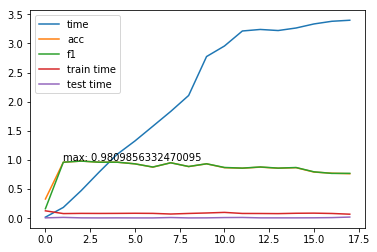

In [74]:
plt.plot(HD_vec_N, HD_time)
plt.plot(HD_vec_N, HD_vec_acc)
plt.plot(HD_vec_N, HD_f1)
plt.plot(HD_vec_N, train_time)
plt.plot(HD_vec_N, test_time)
plt.legend(['time', 'acc', 'f1', 'train time', 'test time'])
plt.text(max(HD_f1),max(HD_f1),'max: ' + str(max(HD_f1)))
plt.yticks()
plt.show()

In [181]:
# print(len(X_train_raw))
# print(X_train_raw[0])
# print(aphabet)
# print([x_to_encode for x_to_encode in X_train_raw])
HD_vec_N = []
HD_vec_acc = []
HD_time = []
HD_f1 = []
train_time = []
test_time = []

for j in range(3, 500, 50):
    start = timer()
    HD_aphabet = 2 * (np.random.randn(len(aphabet), j) < 0) - 1 # generates bipolar {-1, +1}^N HD vectors; one random HD vector per symbol in the alphabet
                                             #HD_aphabet
    x_train_with_HD = [ngram_encode(x_to_encode.lower(), HD_aphabet, aphabet, n_size) for x_to_encode in X_train_raw]
    x_test_with_HD = [ngram_encode(x_test_encode.lower(), HD_aphabet, aphabet, n_size) for x_test_encode in x_test_raw_clean]
#     print(f'round: {j} {x_test_with_HD}')
    end = timer()
    
    print("Time taken:", end-start)
    HD_time.append(end-start)
    HD_vec_N.append(j)
    
    
    target_names = None
    if benchmark_dataset == "Chatbot":
        target_names = ["Departure Time", "Find Connection"]
    elif benchmark_dataset == "AskUbuntu":
        target_names = ["Make Update", "Setup Printer", "Shutdown Computer","Software Recommendation", "None"]
    elif benchmark_dataset == "WebApplication":
        target_names = ["Download Video", "Change Password", "None", "Export Data", "Sync Accounts",
                  "Filter Spam", "Find Alternative", "Delete Account"]
        
    results = []
    
    result =benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty="l2"), #elasticnet
                             x_train_with_HD, y_train_raw, x_test_with_HD, y_test_raw, target_names,
                             feature_names=target_names)

    print(f'result {j}')
    HD_f1.append(result[4])
    HD_vec_acc.append(result[1])
    train_time.append(result[2])
    test_time.append(result[3])
    
    with open("./resultsHDvectors.csv", 'a', encoding='utf8') as csvFile:
        fileWriter = csv.writer(csvFile, delimiter='\t')
        fileWriter.writerow([result[0],str(j), str(3), str(result[4]), str(result[1]), str(result[2]), str(result[3]), str(end-start)])

    


Time taken: 0.24128775757526455
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=50, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.002s
test time:  0.000s
accuracy:   0.229
dimensionality: 3
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.12      0.03      0.04        37
          Setup Printer       0.20      0.85      0.32        13
      Shutdown Computer       0.32      0.79      0.46        14
Software Recommendation       0.50      0.03      0.05        40
                   None       0.11      0.20      0.14         5

              micro avg       0.23      0.23      0.23       109
              macro avg       0.25      0.38      0.20       109
           weighted avg       0.30      0.23      0.14       109

confusion matrix:
[[ 1 30  4  0  2]
 [ 0 11  0  0  2]
 [ 0  2 11  1  0]
 [ 5 11 19  1  4]
 [ 2  2  0  0  1]]

result 3
Time taken: 0.2531418181806657
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weigh

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.003s
test time:  0.000s
accuracy:   0.789
dimensionality: 53
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.94      0.89      0.92        37
          Setup Printer       0.55      0.92      0.69        13
      Shutdown Computer       0.86      0.86      0.86        14
Software Recommendation       0.85      0.70      0.77        40
                   None       0.20      0.20      0.20         5

              micro avg       0.79      0.79      0.79       109
              macro avg       0.68      0.71      0.69       109
           weighted avg       0.82      0.79      0.79       109

confusion matrix:
[[33  0  0  3  1]
 [ 0 12  1  0  0]
 [ 0  0 12  1  1]
 [ 1  8  1 28  2]
 [ 1  2  0  1  1]]

result 53
Time taken: 0.2494681212119758
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_wei

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.005s
test time:  0.000s
accuracy:   0.844
dimensionality: 103
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.92      0.92      0.92        37
          Setup Printer       0.57      0.92      0.71        13
      Shutdown Computer       0.87      0.93      0.90        14
Software Recommendation       0.94      0.72      0.82        40
                   None       0.80      0.80      0.80         5

              micro avg       0.84      0.84      0.84       109
              macro avg       0.82      0.86      0.83       109
           weighted avg       0.87      0.84      0.85       109

confusion matrix:
[[34  2  0  1  0]
 [ 0 12  1  0  0]
 [ 0  1 13  0  0]
 [ 3  6  1 29  1]
 [ 0  0  0  1  4]]

result 103
Time taken: 0.2900955151526432
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_w

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.008s
test time:  0.001s
accuracy:   0.807
dimensionality: 153
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.89      0.86      0.88        37
          Setup Printer       0.64      0.69      0.67        13
      Shutdown Computer       0.93      1.00      0.97        14
Software Recommendation       0.76      0.80      0.78        40
                   None       0.50      0.20      0.29         5

              micro avg       0.81      0.81      0.81       109
              macro avg       0.75      0.71      0.72       109
           weighted avg       0.80      0.81      0.80       109

confusion matrix:
[[32  0  0  5  0]
 [ 0  9  0  4  0]
 [ 0  0 14  0  0]
 [ 4  3  0 32  1]
 [ 0  2  1  1  1]]

result 153
Time taken: 0.3317032727281912
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_w

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.008s
test time:  0.001s
accuracy:   0.780
dimensionality: 203
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.94      0.89      0.92        37
          Setup Printer       0.55      0.92      0.69        13
      Shutdown Computer       0.72      0.93      0.81        14
Software Recommendation       0.93      0.62      0.75        40
                   None       0.29      0.40      0.33         5

              micro avg       0.78      0.78      0.78       109
              macro avg       0.68      0.75      0.70       109
           weighted avg       0.83      0.78      0.79       109

confusion matrix:
[[33  2  1  1  0]
 [ 0 12  1  0  0]
 [ 0  1 13  0  0]
 [ 2  6  2 25  5]
 [ 0  1  1  1  2]]

result 203
Time taken: 0.3072324848471908
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_w

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.009s
test time:  0.001s
accuracy:   0.853
dimensionality: 253
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.93      1.00      0.96        37
          Setup Printer       0.76      1.00      0.87        13
      Shutdown Computer       0.82      1.00      0.90        14
Software Recommendation       1.00      0.65      0.79        40
                   None       0.33      0.60      0.43         5

              micro avg       0.85      0.85      0.85       109
              macro avg       0.77      0.85      0.79       109
           weighted avg       0.89      0.85      0.85       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  2  3 26  6]
 [ 0  2  0  0  3]]

result 253
Time taken: 0.28261963636214205
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.009s
test time:  0.000s
accuracy:   0.835
dimensionality: 303
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.97      0.84      0.90        37
          Setup Printer       0.72      1.00      0.84        13
      Shutdown Computer       0.88      1.00      0.93        14
Software Recommendation       0.91      0.72      0.81        40
                   None       0.36      0.80      0.50         5

              micro avg       0.83      0.83      0.83       109
              macro avg       0.77      0.87      0.80       109
           weighted avg       0.88      0.83      0.84       109

confusion matrix:
[[31  2  0  3  1]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 1  2  2 29  6]
 [ 0  1  0  0  4]]

result 303
Time taken: 0.3039995151502808
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_w

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.011s
test time:  0.000s
accuracy:   0.890
dimensionality: 353
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.90      0.97      0.94        37
          Setup Printer       1.00      1.00      1.00        13
      Shutdown Computer       0.87      0.93      0.90        14
Software Recommendation       0.87      0.85      0.86        40
                   None       0.50      0.20      0.29         5

              micro avg       0.89      0.89      0.89       109
              macro avg       0.83      0.79      0.80       109
           weighted avg       0.88      0.89      0.88       109

confusion matrix:
[[36  0  0  1  0]
 [ 0 13  0  0  0]
 [ 0  0 13  1  0]
 [ 3  0  2 34  1]
 [ 1  0  0  3  1]]

result 353
Time taken: 0.3196290909090749
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_w

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.013s
test time:  0.001s
accuracy:   0.798
dimensionality: 403
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       1.00      0.84      0.91        37
          Setup Printer       0.63      0.92      0.75        13
      Shutdown Computer       0.82      1.00      0.90        14
Software Recommendation       0.78      0.72      0.75        40
                   None       0.20      0.20      0.20         5

              micro avg       0.80      0.80      0.80       109
              macro avg       0.69      0.74      0.70       109
           weighted avg       0.82      0.80      0.80       109

confusion matrix:
[[31  0  0  6  0]
 [ 0 12  1  0  0]
 [ 0  0 14  0  0]
 [ 0  5  2 29  4]
 [ 0  2  0  2  1]]

result 403
Time taken: 0.29766351515172573
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.014s
test time:  0.001s
accuracy:   0.872
dimensionality: 453
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.85      0.95      0.90        37
          Setup Printer       0.76      1.00      0.87        13
      Shutdown Computer       0.93      1.00      0.97        14
Software Recommendation       0.97      0.80      0.88        40
                   None       0.33      0.20      0.25         5

              micro avg       0.87      0.87      0.87       109
              macro avg       0.77      0.79      0.77       109
           weighted avg       0.87      0.87      0.87       109

confusion matrix:
[[35  1  1  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 5  1  0 32  2]
 [ 1  2  0  1  1]]

result 453


In [182]:
# HD_vec_acc.append(0.7706422018348624)
# print(x_train_raw_clean)
print(len(HD_time))
print(len(HD_vec_N))
print(len(HD_f1))
print(len(HD_vec_acc))


10
10
10
10


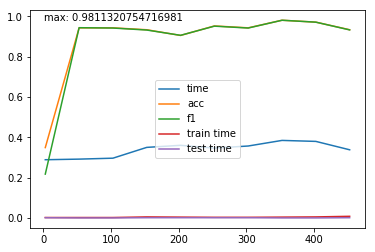

In [77]:
plt.plot(HD_vec_N, HD_time)
plt.plot(HD_vec_N, HD_vec_acc)
plt.plot(HD_vec_N, HD_f1)
plt.plot(HD_vec_N, train_time)
plt.plot(HD_vec_N, test_time)
plt.legend(['time', 'acc', 'f1', 'train time', 'test time'])
plt.text(max(HD_f1),max(HD_f1),'max: ' + str(max(HD_f1)))
plt.yticks()
plt.show()

In [382]:
HD_vec_N = []
HD_vec_acc = []
HD_time = []
HD_f1 = []
train_time = []
test_time = []
HD_acc_avg = []
power = np.arange(5, 15, 1)
power = np.power(2, power)
print(power)
HD_time_train_avg = []
HD_f1_avg = []
HD_time_test_avg = []
for x in range(0,10):
    HD_vec_acc = []
#     HD_time_train_avg = []
#     HD_f1_avg = []
#     HD_time_test_avg = []
    HD_f1 = []
    train_time = []
    test_time = []
    for j in power:
        start = timer()
        print(j)
        HD_aphabet = 2 * (np.random.randn(len(aphabet), j) < 0) - 1 # generates bipolar {-1, +1}^N HD vectors;
#                                                                 one random HD vector per symbol in the alphabet

                                                        #HD_aphabet
        x_train_with_HD = [ngram_encode_mod(x_to_encode.lower(), HD_aphabet, aphabet, n_size_mod) for x_to_encode in X_train_raw]
        x_test_with_HD = [ngram_encode_mod(x_test_encode.lower(), HD_aphabet, aphabet, n_size_mod) for x_test_encode in x_test_raw_clean]
    #     print(f'round: {j} {x_test_with_HD}')
        end = timer()

        print("Time taken:", end-start)
        HD_time.append(end-start)
        HD_vec_N.append(j)


        target_names = None
        if benchmark_dataset == "Chatbot":
            target_names = ["Departure Time", "Find Connection"]
        elif benchmark_dataset == "AskUbuntu":
            target_names = ["Make Update", "Setup Printer", "Shutdown Computer","Software Recommendation", "None"]
        elif benchmark_dataset == "WebApplication":
            target_names = ["Download Video", "Change Password", "None", "Export Data", "Sync Accounts",
                      "Filter Spam", "Find Alternative", "Delete Account"]

        results = []

        result =benchmark(LinearSVC(max_iter=2000, penalty="l2", 
#                                     learning_rate='adaptive', eta0=0.004
                                       )
                          , #elasticnet
                                 x_train_with_HD, y_train_raw, x_test_with_HD, y_test_raw, target_names,
                                 feature_names=target_names)

        print(f'result {j}')
        HD_f1.append(result[4])
        print('Accuracy compile:', result[1])
        HD_vec_acc.append(result[1])
        train_time.append(result[2])
        test_time.append(result[3])

        with open("./resultsHDvectors.csv", 'a', encoding='utf8') as csvFile:
            fileWriter = csv.writer(csvFile, delimiter='\t')
            fileWriter.writerow([result[0],str(j), str(3), str(result[4]), str(result[1]), str(result[2]), str(result[3]), str(end-start)])
    HD_acc_avg.append(HD_vec_acc)
    HD_time_train_avg.append(train_time)
    HD_time_test_avg.append(test_time)
    HD_f1_avg.append(HD_f1)
    print(f'Accuracy compiled {HD_acc_avg}')
    print(f'F1 compiled {HD_f1_avg}')
    print(f'train compiled {HD_time_train_avg}')
    print(f'test compiled {HD_time_test_avg}')

[   32    64   128   256   512  1024  2048  4096  8192 16384]
32
Time taken: 1.129778424234246
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=2000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
train time: 0.005s
test time:  0.004s
accuracy:   0.477
dimensionality: 32
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.79      0.51      0.62        37
          Setup Printer       0.30      0.69      0.42        13
      Shutdown Computer       0.57      0.86      0.69        14
Software Recommendation       0.58      0.28      0.37        40
                   None       0.07      0.20      0.10         5

              micro avg       0.48      0.48      0.48       109
              macro avg 

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.416s
test time:  0.006s
accuracy:   0.908
dimensionality: 512
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.93      1.00      0.96        37
          Setup Printer       0.87      1.00      0.93        13
      Shutdown Computer       0.93      0.93      0.93        14
Software Recommendation       0.92      0.85      0.88        40
                   None       0.67      0.40      0.50         5

              micro avg       0.91      0.91      0.91       109
              macro avg       0.86      0.84      0.84       109
           weighted avg       0.90      0.91      0.90       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 13  1  0]
 [ 2  2  1 34  1]
 [ 1  0  0  2  2]]

result 512
Accuracy compile: 0.908256880733945
1024
Time taken: 1.4194050909136422
________________________________________________________________________________
Training: 
LinearSVC

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.776s
test time:  0.012s
accuracy:   0.917
dimensionality: 1024
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.92      0.97      0.95        37
          Setup Printer       0.93      1.00      0.96        13
      Shutdown Computer       0.88      1.00      0.93        14
Software Recommendation       0.92      0.90      0.91        40
                   None       1.00      0.20      0.33         5

              micro avg       0.92      0.92      0.92       109
              macro avg       0.93      0.81      0.82       109
           weighted avg       0.92      0.92      0.91       109

confusion matrix:
[[36  0  0  1  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  0  1 36  0]
 [ 0  1  1  2  1]]

result 1024
Accuracy compile: 0.9174311926605505
2048
Time taken: 1.4742550302908057
________________________________________________________________________________
Training: 
Linear

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 1.966s
test time:  0.002s
accuracy:   0.890
dimensionality: 2048
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.90      1.00      0.95        37
          Setup Printer       0.81      1.00      0.90        13
      Shutdown Computer       0.88      1.00      0.93        14
Software Recommendation       0.97      0.80      0.88        40
                   None       0.33      0.20      0.25         5

              micro avg       0.89      0.89      0.89       109
              macro avg       0.78      0.80      0.78       109
           weighted avg       0.89      0.89      0.88       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  2  1 32  2]
 [ 1  1  1  1  1]]

result 2048
Accuracy compile: 0.8899082568807339
4096
Time taken: 1.9661566060531186
________________________________________________________________________________
Training: 
Linear

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 1.098s
test time:  0.003s
accuracy:   0.917
dimensionality: 4096
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.93      1.00      0.96        37
          Setup Printer       0.87      1.00      0.93        13
      Shutdown Computer       0.93      1.00      0.97        14
Software Recommendation       0.95      0.88      0.91        40
                   None       0.50      0.20      0.29         5

              micro avg       0.92      0.92      0.92       109
              macro avg       0.83      0.82      0.81       109
           weighted avg       0.91      0.92      0.91       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  1  0 35  1]
 [ 0  1  1  2  1]]

result 4096
Accuracy compile: 0.9174311926605505
8192
Time taken: 3.1949018181767315
________________________________________________________________________________
Training: 
Linear

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.917
dimensionality: 16384
density: 1.000000

classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.95      1.00      0.97        37
          Setup Printer       0.87      1.00      0.93        13
      Shutdown Computer       0.93      1.00      0.97        14
Software Recommendation       0.90      0.90      0.90        40
                   None       0.00      0.00      0.00         5

              micro avg       0.92      0.92      0.92       109
              macro avg       0.73      0.78      0.75       109
           weighted avg       0.88      0.92      0.90       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  2  0 36  0]
 [ 0  0  1  4  0]]

result 16384
Accuracy compile: 0.9174311926605505
Accuracy compiled [[0.47706422018348627, 0.6605504587155964, 0.8073394495412844, 0.7889908256880734, 0.908256880733945, 0.9174311926605505, 0.8899082568807339, 0.9174311926605505, 0.9174311926605505, 0.9174311926605505]]
F1 compiled [[0.490883440644708

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.881
dimensionality: 512
density: 1.000000

classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.92      0.95      0.93        37
          Setup Printer       0.68      1.00      0.81        13
      Shutdown Computer       0.88      1.00      0.93        14
Software Recommendation       0.94      0.85      0.89        40
                   None       0.00      0.00      0.00         5

              micro avg       0.88      0.88      0.88       109
              macro avg       0.68      0.76      0.71       109
           weighted avg       0.85      0.88      0.86       109

confusion matrix:
[[35  1  0  1  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  1  2 34  0]
 [ 0  4  0  1  0]]

result 512
Accuracy compile: 0.8807339449541285
1024
Time taken: 1.4293347878701752
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=20

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.784s
test time:  0.003s
accuracy:   0.917
dimensionality: 1024
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.95      1.00      0.97        37
          Setup Printer       0.87      1.00      0.93        13
      Shutdown Computer       0.88      1.00      0.93        14
Software Recommendation       0.95      0.90      0.92        40
                   None       0.00      0.00      0.00         5

              micro avg       0.92      0.92      0.92       109
              macro avg       0.73      0.78      0.75       109
           weighted avg       0.89      0.92      0.90       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  1 36  1]
 [ 0  2  1  2  0]]

result 1024
Accuracy compile: 0.9174311926605505
2048
Time taken: 1.655260606057709
________________________________________________________________________________
Training: 
LinearS

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 2.023s
test time:  0.005s


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.927
dimensionality: 2048
density: 1.000000

classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.95      1.00      0.97        37
          Setup Printer       0.87      1.00      0.93        13
      Shutdown Computer       0.88      1.00      0.93        14
Software Recommendation       0.95      0.93      0.94        40
                   None       0.00      0.00      0.00         5

              micro avg       0.93      0.93      0.93       109
              macro avg       0.73      0.78      0.75       109
           weighted avg       0.89      0.93      0.90       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  1 37  0]
 [ 0  2  1  2  0]]

result 2048
Accuracy compile: 0.926605504587156
4096
Time taken: 2.0859762424370274
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=20

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 1.250s
test time:  0.022s
accuracy:   0.927
dimensionality: 4096
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.93      1.00      0.96        37
          Setup Printer       0.93      1.00      0.96        13
      Shutdown Computer       0.88      1.00      0.93        14
Software Recommendation       0.95      0.90      0.92        40
                   None       1.00      0.20      0.33         5

              micro avg       0.93      0.93      0.93       109
              macro avg       0.94      0.82      0.82       109
           weighted avg       0.93      0.93      0.91       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  0  1 36  0]
 [ 0  1  1  2  1]]

result 4096
Accuracy compile: 0.926605504587156
8192
Time taken: 3.258503757577273
________________________________________________________________________________
Training: 
LinearSV

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.917
dimensionality: 16384
density: 1.000000

classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.93      1.00      0.96        37
          Setup Printer       1.00      1.00      1.00        13
      Shutdown Computer       0.88      1.00      0.93        14
Software Recommendation       0.90      0.90      0.90        40
                   None       0.00      0.00      0.00         5

              micro avg       0.92      0.92      0.92       109
              macro avg       0.74      0.78      0.76       109
           weighted avg       0.88      0.92      0.90       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  0  1 36  0]
 [ 0  0  1  4  0]]

result 16384
Accuracy compile: 0.9174311926605505
Accuracy compiled [[0.47706422018348627, 0.6605504587155964, 0.8073394495412844, 0.7889908256880734, 0.908256880733945, 0.9174311926605505, 0.8899082568807339, 0.9174311926605505, 0.9174311926605505, 0.9174311926605505], [0.5779816513761468, 0.66972477

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.389s
test time:  0.000s
accuracy:   0.927
dimensionality: 512
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.97      1.00      0.99        37
          Setup Printer       0.86      0.92      0.89        13
      Shutdown Computer       0.93      0.93      0.93        14
Software Recommendation       0.95      0.93      0.94        40
                   None       0.50      0.40      0.44         5

              micro avg       0.93      0.93      0.93       109
              macro avg       0.84      0.84      0.84       109
           weighted avg       0.92      0.93      0.92       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 12  0  0  1]
 [ 0  0 13  1  0]
 [ 1  0  1 37  1]
 [ 0  2  0  1  2]]

result 512
Accuracy compile: 0.926605504587156
1024
Time taken: 1.4825595151487505
________________________________________________________________________________
Training: 
LinearSVC

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.877s
test time:  0.001s


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.908
dimensionality: 1024
density: 1.000000

classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.95      1.00      0.97        37
          Setup Printer       0.87      1.00      0.93        13
      Shutdown Computer       0.82      1.00      0.90        14
Software Recommendation       0.92      0.88      0.90        40
                   None       0.00      0.00      0.00         5

              micro avg       0.91      0.91      0.91       109
              macro avg       0.71      0.78      0.74       109
           weighted avg       0.87      0.91      0.89       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  1  2 35  0]
 [ 0  1  1  3  0]]

result 1024
Accuracy compile: 0.908256880733945
2048
Time taken: 1.5099466666724766
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=20

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 1.792s
test time:  0.013s
accuracy:   0.927
dimensionality: 2048
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.95      1.00      0.97        37
          Setup Printer       0.87      1.00      0.93        13
      Shutdown Computer       0.93      1.00      0.97        14
Software Recommendation       0.92      0.90      0.91        40
                   None       1.00      0.20      0.33         5

              micro avg       0.93      0.93      0.93       109
              macro avg       0.93      0.82      0.82       109
           weighted avg       0.93      0.93      0.92       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  1  1 36  0]
 [ 0  1  0  3  1]]

result 2048
Accuracy compile: 0.926605504587156
4096
Time taken: 2.0080150303110713
________________________________________________________________________________
Training: 
LinearS

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.978s
test time:  0.006s


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.899
dimensionality: 1024
density: 1.000000

classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.95      1.00      0.97        37
          Setup Printer       0.72      1.00      0.84        13
      Shutdown Computer       0.93      1.00      0.97        14
Software Recommendation       0.92      0.85      0.88        40
                   None       0.00      0.00      0.00         5

              micro avg       0.90      0.90      0.90       109
              macro avg       0.70      0.77      0.73       109
           weighted avg       0.87      0.90      0.88       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  3  1 34  0]
 [ 0  2  0  3  0]]

result 1024
Accuracy compile: 0.8990825688073395
2048
Time taken: 1.530059151511523
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=20

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 1.139s
test time:  0.004s
accuracy:   0.908
dimensionality: 2048
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.95      1.00      0.97        37
          Setup Printer       0.76      1.00      0.87        13
      Shutdown Computer       0.82      1.00      0.90        14
Software Recommendation       0.97      0.85      0.91        40
                   None       1.00      0.20      0.33         5

              micro avg       0.91      0.91      0.91       109
              macro avg       0.90      0.81      0.80       109
           weighted avg       0.92      0.91      0.90       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  3  1 34  0]
 [ 0  1  2  1  1]]

result 2048
Accuracy compile: 0.908256880733945
4096
Time taken: 2.108029575756518
________________________________________________________________________________
Training: 
LinearSV


confusion matrix:
[[ 9  2  2 24  0]
 [ 0  7  1  2  3]
 [ 1  3  8  2  0]
 [ 1  3  6 25  5]
 [ 1  1  0  2  1]]

result 32
Accuracy compile: 0.45871559633027525
64
Time taken: 1.2023418181779562
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=2000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
train time: 0.016s
test time:  0.001s
accuracy:   0.725
dimensionality: 64
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.84      0.84      0.84        37
          Setup Printer       0.57      1.00      0.72        13
      Shutdown Computer       0.55      0.86      0.67        14
Software Recommendation       0.88      0.57      0.70        40
                   None       0.00      0.00      0.00   

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.888s
test time:  0.001s
accuracy:   0.899
dimensionality: 1024
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.95      1.00      0.97        37
          Setup Printer       0.65      1.00      0.79        13
      Shutdown Computer       0.93      1.00      0.97        14
Software Recommendation       1.00      0.80      0.89        40
                   None       0.67      0.40      0.50         5

              micro avg       0.90      0.90      0.90       109
              macro avg       0.84      0.84      0.82       109
           weighted avg       0.92      0.90      0.90       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  4  1 32  1]
 [ 0  3  0  0  2]]

result 1024
Accuracy compile: 0.8990825688073395
2048
Time taken: 1.8377440000040224
________________________________________________________________________________
Training: 
Linear

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 1.671s
test time:  0.004s
accuracy:   0.917
dimensionality: 2048
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.93      1.00      0.96        37
          Setup Printer       0.81      1.00      0.90        13
      Shutdown Computer       0.93      1.00      0.97        14
Software Recommendation       0.95      0.88      0.91        40
                   None       1.00      0.20      0.33         5

              micro avg       0.92      0.92      0.92       109
              macro avg       0.92      0.82      0.81       109
           weighted avg       0.92      0.92      0.91       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  1  1 35  0]
 [ 0  2  0  2  1]]

result 2048
Accuracy compile: 0.9174311926605505
4096
Time taken: 2.564784000001964
________________________________________________________________________________
Training: 
LinearS

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 2.038s
test time:  0.004s


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.917
dimensionality: 4096
density: 1.000000

classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.93      1.00      0.96        37
          Setup Printer       0.87      1.00      0.93        13
      Shutdown Computer       0.93      1.00      0.97        14
Software Recommendation       0.92      0.90      0.91        40
                   None       0.00      0.00      0.00         5

              micro avg       0.92      0.92      0.92       109
              macro avg       0.73      0.78      0.75       109
           weighted avg       0.88      0.92      0.90       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  1  0 36  0]
 [ 0  1  1  3  0]]

result 4096
Accuracy compile: 0.9174311926605505
8192
Time taken: 4.29710981817334
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=200

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 1.225s
test time:  0.003s
accuracy:   0.899
dimensionality: 1024
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.93      1.00      0.96        37
          Setup Printer       1.00      1.00      1.00        13
      Shutdown Computer       0.93      0.93      0.93        14
Software Recommendation       0.85      0.88      0.86        40
                   None       0.00      0.00      0.00         5

              micro avg       0.90      0.90      0.90       109
              macro avg       0.74      0.76      0.75       109
           weighted avg       0.87      0.90      0.88       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 13  1  0]
 [ 3  0  1 35  1]
 [ 0  0  0  5  0]]

result 1024
Accuracy compile: 0.8990825688073395
2048
Time taken: 1.781373575766338
________________________________________________________________________________
Training: 
LinearS

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 1.988s
test time:  0.007s


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.908
dimensionality: 2048
density: 1.000000

classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.95      0.97      0.96        37
          Setup Printer       0.81      1.00      0.90        13
      Shutdown Computer       0.93      1.00      0.97        14
Software Recommendation       0.90      0.90      0.90        40
                   None       0.00      0.00      0.00         5

              micro avg       0.91      0.91      0.91       109
              macro avg       0.72      0.77      0.74       109
           weighted avg       0.87      0.91      0.89       109

confusion matrix:
[[36  0  0  1  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  1  1 36  0]
 [ 0  2  0  3  0]]

result 2048
Accuracy compile: 0.908256880733945
4096
Time taken: 2.564991030303645
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=200

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.807
dimensionality: 256
density: 1.000000

classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.88      0.95      0.91        37
          Setup Printer       0.59      1.00      0.74        13
      Shutdown Computer       0.74      1.00      0.85        14
Software Recommendation       0.93      0.65      0.76        40
                   None       0.00      0.00      0.00         5

              micro avg       0.81      0.81      0.81       109
              macro avg       0.63      0.72      0.65       109
           weighted avg       0.80      0.81      0.79       109

confusion matrix:
[[35  0  2  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 4  7  3 26  0]
 [ 1  2  0  2  0]]

result 256
Accuracy compile: 0.8073394495412844
512
Time taken: 1.6907718787842896
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=200

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.948s
test time:  0.002s
accuracy:   0.890
dimensionality: 1024
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.92      0.97      0.95        37
          Setup Printer       0.93      1.00      0.96        13
      Shutdown Computer       0.88      1.00      0.93        14
Software Recommendation       0.91      0.80      0.85        40
                   None       0.40      0.40      0.40         5

              micro avg       0.89      0.89      0.89       109
              macro avg       0.81      0.83      0.82       109
           weighted avg       0.89      0.89      0.89       109

confusion matrix:
[[36  0  0  1  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  0  2 32  3]
 [ 0  1  0  2  2]]

result 1024
Accuracy compile: 0.8899082568807339
2048
Time taken: 1.9035093333368422
________________________________________________________________________________
Training: 
Linear

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 1.778s
test time:  0.010s


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.917
dimensionality: 2048
density: 1.000000

classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.93      1.00      0.96        37
          Setup Printer       0.93      1.00      0.96        13
      Shutdown Computer       0.88      1.00      0.93        14
Software Recommendation       0.92      0.90      0.91        40
                   None       0.00      0.00      0.00         5

              micro avg       0.92      0.92      0.92       109
              macro avg       0.73      0.78      0.75       109
           weighted avg       0.88      0.92      0.90       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  0  1 36  0]
 [ 0  1  1  3  0]]

result 2048
Accuracy compile: 0.9174311926605505
4096
Time taken: 3.3058623030228773
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=2

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 1.747s
test time:  0.018s


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.927
dimensionality: 4096
density: 1.000000

classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.95      1.00      0.97        37
          Setup Printer       0.93      1.00      0.96        13
      Shutdown Computer       0.93      1.00      0.97        14
Software Recommendation       0.90      0.93      0.91        40
                   None       0.00      0.00      0.00         5

              micro avg       0.93      0.93      0.93       109
              macro avg       0.74      0.78      0.76       109
           weighted avg       0.88      0.93      0.90       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  1  0 37  0]
 [ 0  0  1  4  0]]

result 4096
Accuracy compile: 0.926605504587156
8192
Time taken: 4.962970181819401
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=200

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 1.021s
test time:  0.000s
accuracy:   0.872
dimensionality: 1024
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.93      1.00      0.96        37
          Setup Printer       0.68      1.00      0.81        13
      Shutdown Computer       0.93      1.00      0.97        14
Software Recommendation       0.94      0.78      0.85        40
                   None       0.00      0.00      0.00         5

              micro avg       0.87      0.87      0.87       109
              macro avg       0.70      0.76      0.72       109
           weighted avg       0.86      0.87      0.86       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  4  0 31  2]
 [ 0  2  1  2  0]]

result 1024
Accuracy compile: 0.8715596330275229
2048
Time taken: 2.2032756363769295
________________________________________________________________________________
Training: 
Linear

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 1.311s
test time:  0.014s
accuracy:   0.927
dimensionality: 2048
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.95      1.00      0.97        37
          Setup Printer       1.00      1.00      1.00        13
      Shutdown Computer       0.88      1.00      0.93        14
Software Recommendation       0.93      0.93      0.93        40
                   None       0.00      0.00      0.00         5

              micro avg       0.93      0.93      0.93       109
              macro avg       0.75      0.78      0.77       109
           weighted avg       0.89      0.93      0.91       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  0 37  1]
 [ 0  0  2  3  0]]

result 2048
Accuracy compile: 0.926605504587156
4096
Time taken: 2.6749507878848817
________________________________________________________________________________
Training: 
LinearS

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 1.556s
test time:  0.027s
accuracy:   0.927
dimensionality: 4096
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.93      1.00      0.96        37
          Setup Printer       0.93      1.00      0.96        13
      Shutdown Computer       0.93      1.00      0.97        14
Software Recommendation       0.92      0.90      0.91        40
                   None       1.00      0.20      0.33         5

              micro avg       0.93      0.93      0.93       109
              macro avg       0.94      0.82      0.83       109
           weighted avg       0.93      0.93      0.91       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  0  1 36  0]
 [ 0  1  0  3  1]]

result 4096
Accuracy compile: 0.926605504587156
8192
Time taken: 5.010598787877825
________________________________________________________________________________
Training: 
LinearSV

     verbose=0)
train time: 0.436s
test time:  0.000s
accuracy:   0.853
dimensionality: 512
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.92      0.95      0.93        37
          Setup Printer       0.72      1.00      0.84        13
      Shutdown Computer       0.82      1.00      0.90        14
Software Recommendation       0.88      0.75      0.81        40
                   None       0.50      0.20      0.29         5

              micro avg       0.85      0.85      0.85       109
              macro avg       0.77      0.78      0.75       109
           weighted avg       0.85      0.85      0.84       109

confusion matrix:
[[35  1  0  1  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  3  3 30  1]
 [ 0  1  0  3  1]]

result 512
Accuracy compile: 0.8532110091743119
1024
Time taken: 1.7282516363629838
________________________________________________________________________________
Tra

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.873s
test time:  0.008s
accuracy:   0.917
dimensionality: 1024
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.95      1.00      0.97        37
          Setup Printer       1.00      1.00      1.00        13
      Shutdown Computer       0.88      1.00      0.93        14
Software Recommendation       0.92      0.88      0.90        40
                   None       0.33      0.20      0.25         5

              micro avg       0.92      0.92      0.92       109
              macro avg       0.82      0.82      0.81       109
           weighted avg       0.91      0.92      0.91       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  1 35  2]
 [ 0  0  1  3  1]]

result 1024
Accuracy compile: 0.9174311926605505
2048
Time taken: 1.8642913939402206
________________________________________________________________________________
Training: 
Linear

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 1.685s
test time:  0.003s
accuracy:   0.936
dimensionality: 2048
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.95      1.00      0.97        37
          Setup Printer       0.93      1.00      0.96        13
      Shutdown Computer       0.93      1.00      0.97        14
Software Recommendation       0.93      0.93      0.93        40
                   None       1.00      0.20      0.33         5

              micro avg       0.94      0.94      0.94       109
              macro avg       0.95      0.82      0.83       109
           weighted avg       0.94      0.94      0.92       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  1 37  0]
 [ 0  1  0  3  1]]

result 2048
Accuracy compile: 0.9357798165137615
4096
Time taken: 2.5240843636420323
________________________________________________________________________________
Training: 
Linear

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.173s
test time:  0.006s
accuracy:   0.862
dimensionality: 256
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.92      0.97      0.95        37
          Setup Printer       0.72      1.00      0.84        13
      Shutdown Computer       0.88      1.00      0.93        14
Software Recommendation       0.91      0.72      0.81        40
                   None       0.50      0.40      0.44         5

              micro avg       0.86      0.86      0.86       109
              macro avg       0.79      0.82      0.79       109
           weighted avg       0.87      0.86      0.86       109

confusion matrix:
[[36  0  0  1  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  5  1 29  2]
 [ 0  0  1  2  2]]

result 256
Accuracy compile: 0.8623853211009175
512
Time taken: 1.8701372121286113
________________________________________________________________________________
Training: 
LinearSVC

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 0.477s
test time:  0.002s
accuracy:   0.908
dimensionality: 512
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.95      1.00      0.97        37
          Setup Printer       0.76      1.00      0.87        13
      Shutdown Computer       0.88      1.00      0.93        14
Software Recommendation       1.00      0.82      0.90        40
                   None       0.50      0.40      0.44         5

              micro avg       0.91      0.91      0.91       109
              macro avg       0.82      0.85      0.82       109
           weighted avg       0.92      0.91      0.91       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  2  1 33  2]
 [ 0  2  1  0  2]]

result 512
Accuracy compile: 0.908256880733945
1024
Time taken: 2.110467878781492
________________________________________________________________________________
Training: 
LinearSVC(

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 1.083s
test time:  0.010s
accuracy:   0.890
dimensionality: 1024
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.90      1.00      0.95        37
          Setup Printer       0.87      1.00      0.93        13
      Shutdown Computer       0.82      1.00      0.90        14
Software Recommendation       0.97      0.80      0.88        40
                   None       0.33      0.20      0.25         5

              micro avg       0.89      0.89      0.89       109
              macro avg       0.78      0.80      0.78       109
           weighted avg       0.89      0.89      0.88       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  0  3 32  2]
 [ 1  2  0  1  1]]

result 1024
Accuracy compile: 0.8899082568807339
2048
Time taken: 2.200284606049536
________________________________________________________________________________
Training: 
LinearS

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 2.306s
test time:  0.003s
accuracy:   0.927
dimensionality: 2048
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.95      1.00      0.97        37
          Setup Printer       0.81      1.00      0.90        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.95      0.90      0.92        40
                   None       0.50      0.20      0.29         5

              micro avg       0.93      0.93      0.93       109
              macro avg       0.84      0.82      0.82       109
           weighted avg       0.92      0.93      0.92       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  1  0 36  1]
 [ 0  2  0  2  1]]

result 2048
Accuracy compile: 0.926605504587156
4096
Time taken: 2.580495030299062
________________________________________________________________________________
Training: 
LinearSV

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 1.421s
test time:  0.003s
accuracy:   0.927
dimensionality: 4096
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.93      1.00      0.96        37
          Setup Printer       0.93      1.00      0.96        13
      Shutdown Computer       0.88      1.00      0.93        14
Software Recommendation       0.95      0.90      0.92        40
                   None       1.00      0.20      0.33         5

              micro avg       0.93      0.93      0.93       109
              macro avg       0.94      0.82      0.82       109
           weighted avg       0.93      0.93      0.91       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  0  1 36  0]
 [ 0  1  1  2  1]]

result 4096
Accuracy compile: 0.926605504587156
8192
Time taken: 4.233560727283475
________________________________________________________________________________
Training: 
LinearSV

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.917
dimensionality: 8192
density: 1.000000

classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\envs\nlp_course\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.93      1.00      0.96        37
          Setup Printer       0.93      1.00      0.96        13
      Shutdown Computer       0.88      1.00      0.93        14
Software Recommendation       0.92      0.90      0.91        40
                   None       0.00      0.00      0.00         5

              micro avg       0.92      0.92      0.92       109
              macro avg       0.73      0.78      0.75       109
           weighted avg       0.88      0.92      0.90       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  0  1 36  0]
 [ 0  1  1  3  0]]

result 8192
Accuracy compile: 0.9174311926605505
16384
Time taken: 5.786547878786223
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=2

In [383]:
HD_list = np.zeros(len(power))
HD_graph_acc = []
HD_graph_f1 = []
HD_graph_time_train = []
HD_graph_time_test = []
for elem in HD_acc_avg:
    print('Accuracy', np.mean(elem))
    HD_list += np.array(elem)
#     print(np.array(elem))
print(HD_list/10)
HD_graph_acc = HD_list/10
print('******************************************************************************************************')
HD_list = np.zeros(len(power))
for elem in HD_f1_avg:
    print('f1 score', np.mean(elem))
    HD_list += np.array(elem)
#     print(np.array(elem).shape)
print(HD_list/10)
HD_graph_f1 = HD_list/10
print('******************************************************************************************************')
HD_list = np.zeros(len(power))
for elem in HD_time_train_avg:
    print('time train', np.mean(elem))
    HD_list += np.array(elem)
#     print(np.array(elem))
print(HD_list/10)
HD_graph_time_train = HD_list/10
print('******************************************************************************************************')
HD_list = np.zeros(len(power))
for elem in HD_time_test_avg:
    print('time test', np.mean(elem))
    HD_list += np.array(elem)
#     print(np.array(elem))
print(HD_list/10)
HD_graph_time_test = HD_list/10
print(power)

Accuracy 0.820183486238532
Accuracy 0.8357798165137617
Accuracy 0.8385321100917432
Accuracy 0.843119266055046
Accuracy 0.8229357798165138
Accuracy 0.8376146788990827
Accuracy 0.8376146788990825
Accuracy 0.8311926605504588
Accuracy 0.8422018348623853
Accuracy 0.8403669724770643
[0.5293578  0.70642202 0.78073394 0.84495413 0.90183486 0.90091743
 0.91834862 0.92018349 0.92385321 0.92293578]
******************************************************************************************************
f1 score 0.8124933963762098
f1 score 0.8260305814709007
f1 score 0.8328290083791907
f1 score 0.8353662994520729
f1 score 0.8118041789623043
f1 score 0.8287582083019158
f1 score 0.8273606159898994
f1 score 0.824312370605135
f1 score 0.8327579334787274
f1 score 0.83394278920302
[0.54180294 0.70286019 0.77384184 0.83464515 0.89237003 0.88897922
 0.90393784 0.90641379 0.91138241 0.90942196]
******************************************************************************************************
time train 0.

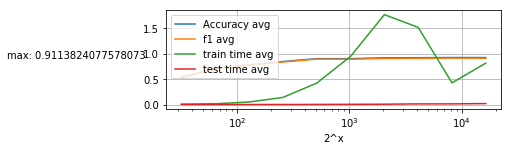

Dimensions [   32    64   128   256   512  1024  2048  4096  8192 16384]
Accuracy list [0.5293578  0.70642202 0.78073394 0.84495413 0.90183486 0.90091743
 0.91834862 0.92018349 0.92385321 0.92293578]
F1 list [0.54180294 0.70286019 0.77384184 0.83464515 0.89237003 0.88897922
 0.90393784 0.90641379 0.91138241 0.90942196]
Time train list [0.00728505 0.01556115 0.04958112 0.14004874 0.42105932 0.94531839
 1.76588991 1.51679237 0.4256928  0.81380196]
Time test list [0.00079737 0.00100191 0.00059228 0.00089812 0.00245655 0.00462713
 0.00662093 0.01239209 0.01275215 0.01902206]


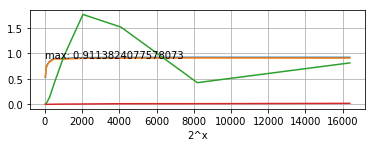

In [384]:
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)

plt.plot(power, HD_graph_acc)
plt.plot(power, HD_graph_f1)
plt.plot(power, HD_graph_time_train)
plt.plot(power, HD_graph_time_test)

ax.set_xscale('log')
# plt.plot(power, test_time)
plt.legend(['Accuracy avg', 'f1 avg', 'train time avg', #'train time', 
                                                        'test time avg'])
plt.text(0.9,0.9,'max: ' + str(max(HD_graph_f1)))
plt.grid()
x = np.arange(len(power)+1)
plt.yticks()
plt.xlabel('2^x')
# plt.xticks(power#, power, rotation=45
#           )
plt.show()
# print('Accuracy:', np.mean(#HD_vec_acc
#                     np.array(HD_acc_avg)))
print('Dimensions', power)
# print(np.mean(np.matrix(HD_acc_avg)))
# print(len(HD_acc_avg))

print('Accuracy list', HD_graph_acc)
print('F1 list', HD_graph_f1)
print('Time train list', HD_graph_time_train)
print('Time test list', HD_graph_time_test)

fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)

plt.plot(power, HD_graph_acc)
plt.plot(power, HD_graph_f1)
plt.plot(power, HD_graph_time_train)
plt.plot(power, HD_graph_time_test)

# ax.set_xscale('log')
# plt.plot(power, test_time)
# plt.legend(['Accuracy avg', 'f1 avg', 'train time avg', #'train time', 
#                                                         'test time avg'])
plt.text(0.9,0.9,'max: ' + str(max(HD_graph_f1)))
plt.grid()
x = np.arange(len(power)+1)
plt.yticks()
plt.xlabel('2^x')
# plt.xticks(power#, power, rotation=45
#           )
plt.show()
# print('Accuracy:', np.mean(#HD_vec_acc
#                     np.array(HD_acc_avg)))

In [ ]:
def ngram_encode_bin(str_test, HD_aphabet, aphabet, n_size): # method for mapping n-gram statistics of a word to an N-dimensional HD vector
    HD_ngram = np.zeros(HD_aphabet.shape[1]) # will store n-gram statistics mapped to HD vector
    full_str = '#' + str_test + '#' # include extra symbols to the string
#     print(str_test)
    #adjust the string for n-gram size
    
    if n_size == 1:
        full_str_e=full_str            
    else:
        full_str_e=full_str[:-(n_size-1)]    
        
    for il, l in enumerate(full_str_e): # loops through all n-grams
        hdgram = HD_aphabet[aphabet.find(full_str[il]), :] # picks HD vector for the first symbol in the current n-gram
        
        for ng in range(1, n_size): #loops through the rest of symbols in the current n-gram
                hdgram = np.logical_xor( hdgram, np.roll(HD_aphabet[aphabet.find(full_str[il+ng]), :], ng)) # two operations simultaneously; binding via XOR; rotation via cyclic shift

        HD_ngram += hdgram # increments HD vector of n-gram statistics with the HD vector for the currently observed n-gram

    
    HD_ngram_norm =HD_ngram/len(full_str_e)  # normalizes HD-vector by number of n-grams. So value in each position is between 0 and 1    
    
    return HD_ngram_norm # output normalized HD mapping

N_bin = 1000 # set the desired dimensionality of HD vectors
n_size_bin=2 # n-gram size
aphabet_bin = 'abcdefghijklmnopqrstuvwxyz# ?-/!\+[]{}().,:;1234567890äö' #fix the alphabet. Note, we assume that capital letters are not in use 
np.random.seed(1) # for reproducibility
HD_aphabet_bin = (np.random.randn(len(aphabet_bin), N_bin) < 0)  # generates binary {0, 1}^N HD vectors; one random HD vector per symbol in the alphabet

str_tst='jump' # example string to represent using n-grams
HD_ngram_bin = ngram_encode_bin(str_tst, HD_aphabet_bin, aphabet_bin, n_size_bin) # HD_ngram is a projection of n-gram statistics for str to N-dimensional space. It can be used to learn the word embedding

print(len(HD_ngram_bin))

In [ ]:
# print(len(X_train_raw))
# print(X_train_raw[0])
# print(aphabet)
# print([x_to_encode for x_to_encode in X_train_raw])
HD_vec_N = []
HD_vec_acc = []
HD_time = []
HD_f1 = []
train_time = []
test_time = []
HD_aphabet = 2 * (np.random.randn(len(aphabet_bin), 10000) < 0) - 1 # generates bipolar {-1, +1}^N HD vectors; one random HD vector per symbol in the alphabet

for j in range(0,17):
    start = timer()
                                                        #HD_aphabet
    x_train_with_HD = [ngram_encode_bin(x_to_encode.lower(), HD_aphabet_bin, aphabet_bin, j) for x_to_encode in X_train_raw]
    x_test_with_HD = [ngram_encode_bin(x_test_encode.lower(), HD_aphabet_bin, aphabet_bin, j) for x_test_encode in x_test_raw_clean]
    print(f'round: {j} {x_test_with_HD}')
#     print(j)
    end = timer()
    
    print("Time taken:", end-start)
    HD_time.append(end-start)
    HD_vec_N.append(j)
    
    
    target_names = None
    if benchmark_dataset == "Chatbot":
        target_names = ["Departure Time", "Find Connection"]
    elif benchmark_dataset == "AskUbuntu":
        target_names = ["Make Update", "Setup Printer", "Shutdown Computer","Software Recommendation", "None"]
    elif benchmark_dataset == "WebApplication":
        target_names = ["Download Video", "Change Password", "None", "Export Data", "Sync Accounts",
                  "Filter Spam", "Find Alternative", "Delete Account"]
        
    results = []
    
    result = benchmark(BernoulliNB(alpha=.01),
                             x_train_with_HD, y_train_raw, x_test_with_HD, y_test_raw, target_names,
                             feature_names=target_names) #feature_names
    print(f'result {j}')
    HD_f1.append(result[4])
    HD_vec_acc.append(result[1])
    train_time.append(result[2])
    test_time.append(result[3])
    
#     with open("./resultsHDvectors.csv", 'a', encoding='utf8') as csvFile:
#         fileWriter = csv.writer(csvFile, delimiter='\t')
#         fileWriter.writerow([result[0],str(N_bin),str(j), str(result[4]), str(result[1]), str(result[2]), str(result[3]), str(end-start)])
            
#             benchmark_dataset,str(clf),str(oversample),str(synonym_extra_samples),str(augment_extra_samples),
#                              str(additional_synonyms),str(additional_augments), str(mistake_distance), str(score), str(f1_score)])


    


In [ ]:
plt.plot(HD_vec_N, HD_time)
plt.plot(HD_vec_N, HD_vec_acc)
plt.plot(HD_vec_N, HD_f1)
plt.plot(HD_vec_N, train_time)
plt.plot(HD_vec_N, test_time)
plt.legend(['time', 'acc', 'f1', 'train time', 'test time'])
plt.text(max(HD_f1),max(HD_f1),'max: ' + str(max(HD_f1)))
plt.yticks()
plt.show()

In [104]:
import time as timmer

def ngram_encode_mod(str_test, HD_aphabet, aphabet, n_size): # method for mapping n-gram statistics of a word to an N-dimensional HD vector
    HD_ngram = np.zeros(HD_aphabet.shape[1]) # will store n-gram statistics mapped to HD vector
    full_str = '#' + str_test + '#' # include extra symbols to the string
    shift=n_size-1
        
    # form the vector for the first n-gram
    hdgram = HD_aphabet[aphabet.find(full_str[0]), :] # picks HD vector for the first symbol in the current n-gram
#     for ng in range(1, n_size): #loops through the rest of symbols in the current n-gram
#         hdgram = hdgram * np.roll(HD_aphabet[aphabet.find(full_str[0+ng]), :], ng) # two operations simultaneously; binding via elementvise multiplication; rotation via cyclic shift        
#     HD_ngram += hdgram # increments HD vector of n-gram statistics with the HD vector for the currently observed n-gram
        
#     for l in range(1, len(full_str)-shift):  # form all other n-grams using the HD vector for the first one      
#         hdgram = np.roll( hdgram * HD_aphabet[aphabet.find(full_str[l-1]), :], -1) * np.roll(HD_aphabet[aphabet.find(full_str[l+shift]), :], shift) # improved implementation of forming HD vectors for n-grams
#         HD_ngram += hdgram # increments HD vector of n-gram statistics with the HD vector for the currently observed n-gram
    
#     HD_ngram_norm = np.sqrt(HD_aphabet.shape[1]) * (HD_ngram/ np.linalg.norm(HD_ngram) )  # normalizes HD-vector so that its norm equals sqrt(N)       
    
    HD_ngram_tot = np.zeros(HD_aphabet.shape[1])
    for n_size in range(2, 7):
        HD_ngram_tot += ngram_encode_hybrid(str_test, HD_aphabet, aphabet, n_size)
    HD_ngram_tot = np.sqrt(HD_aphabet.shape[1]) * (HD_ngram_tot/ np.linalg.norm(HD_ngram_tot))
    
#     return HD_ngram_norm # output normalized HD mapping
    return HD_ngram_tot


def ngram_encode_hybrid(str_test, HD_aphabet, aphabet, n_size): # method for mapping n-gram statistics of a word to an N-dimensional HD vector
    HD_ngram = np.zeros(HD_aphabet.shape[1]) # will store n-gram statistics mapped to HD vector
    full_str = '#' + str_test + '#' # include extra symbols to the string
    shift=n_size-1
#     print(full_str)
    
    if n_size < 3: # use the initial implementation
        #adjust the string for n-gram size
        if n_size == 1:
            full_str_e=full_str            
        else:
            full_str_e=full_str[:-(n_size-1)]    
            
        for il, l in enumerate(full_str_e): # loops through all n-grams
            hdgram = HD_aphabet[aphabet.find(full_str[il]), :] # picks HD vector for the first symbol in the current n-gram
            
            for ng in range(1, n_size): #loops through the rest of symbols in the current n-gram
                    hdgram = hdgram * np.roll(HD_aphabet[aphabet.find(full_str[il+ng]), :], ng) # two operations simultaneously; binding via elementvise multiplication; rotation via cyclic shift
    
            HD_ngram += hdgram # increments HD vector of n-gram statistics with the HD vector for the currently observed n-gram

    else:    # use the modified implementation

        # form the vector for the first n-gram
        hdgram = HD_aphabet[aphabet.find(full_str[0]), :] # picks HD vector for the first symbol in the current n-gram
        for ng in range(1, n_size): #loops through the rest of symbols in the current n-gram
            hdgram = hdgram * np.roll(HD_aphabet[aphabet.find(full_str[0+ng]), :], ng) # two operations simultaneously; binding via elementvise multiplication; rotation via cyclic shift        
        HD_ngram += hdgram # increments HD vector of n-gram statistics with the HD vector for the currently observed n-gram
            
        for l in range(1, len(full_str)-shift): # form all other n-grams using the HD vector for the first one    
            hdgram = np.roll( hdgram * HD_aphabet[aphabet.find(full_str[l-1]), :], -1) * np.roll(HD_aphabet[aphabet.find(full_str[l+shift]), :], shift) # improved implementation of forming HD vectors for n-grams
            HD_ngram += hdgram # increments HD vector of n-gram statistics with the HD vector for the currently observed n-gram
    
    HD_ngram_norm = np.sqrt(HD_aphabet.shape[1]) * (HD_ngram/ np.linalg.norm(HD_ngram) )  # normalizes HD-vector so that its norm equals sqrt(N)    
    
    return HD_ngram_norm # output normalized HD mapping



N_mod = 17000 # set the desired dimensionality of HD vectors
n_size_mod=3 # n-gram size
aphabet_mod = 'abcdefghijklmnopqrstuvwxyz# ?-/!\+[]{}().,:;1234567890äöÿã' #fix the alphabet. Note, we assume that capital letters are not in use 
# np.random.seed(1) # for reproducibility
HD_aphabet_mod = 2 * (np.random.randn(len(aphabet_mod), N_mod) < 0) - 1 # generates bipolar {-1, +1}^N HD vectors; one random HD vector per symbol in the alphabet

#str='jump' # example string to represent using n-grams
str_tst='intrigued started to work it out the third installment of the twilight saga eclipse proved to be a small stepup from the first two movies lowrie atoned for an error he made in the top half of the inning when he dropped a foul popup while playing first base but she couldnt sleep knowing that her mother was sitting alone somewhere in a big foreign airport that had gone into crisis mode call the minot at to reserve your spot for beginning duplicate bridge monday evenings plucking the track from her am sasha fierce beyonces halo has become one of her signature songs wow sound smart should change his name to really dumb it dabbles in several facets of the financial services industry from its jpmorgan investment banking chase credit cards and various banking operations the developing industrial applications for silver are exciting and expect longterm growth here rick morgan has been fishing lower manitou since he was a kid growing up in hibbing in the late he may not be a good guy but hes not a rapist at least not yet we have taken this request under consideration in gardner was facing trial for killing melvyn otterstrom a bartender in salt lake city when a girlfriend slipped him a gun at the courthouse soon after more offers came piling in from other schools central michigan miami western michigan and ohio for the current crop of condo dwellers losing the convenience of a car is part of the price of home ownership by values were in retreat will julian crocker look into this small problem but she said that officer didnt want to hear any more these were on increases in gross and average from their pathetic predecessors though neither measure was ever an accurate barometer of industry health the participants bacon cheeseburger patty with bacon lettuce tomato and mayo phillies catcher carlos ruiz connects for a gamewinning home run in the inning against the cardinals tango don cheadle is an undercover cop posing as a drug lord watching his criminal compatriot wesley snipes in a restrained return to form return to power after a lengthy prison stretch we are eliminating sales and management company cars altogether and moving those positions to an allowance said lisa kneggs fleet manager on a per school dayhourly basis has anyone done the math on this why dont we just pay everyone not to work peacock asks referring to losing the streak lot depends on the pitching staff of course but as the smoke cleared lost became as twitter fan joe hewitt put it a soap opera not an intellectual scifi thriller and thus a waste of time that is something hill hopes they all take seriously in worlds recent tests on mobile bandwidth speeds ranks first hands down its too early to judge whether a large number of donors across the country will pour money into the race as they did for brown but browns appearance here is likely to increase that possibility as the contest gains notice president ahmadinejad further announced irans decision to postpone talks with the world powers until august in a move to punish the west weir fire escape extension burley bridge mills viaduct road burley hes a house republican guy he may have been wearing number on his hip but tonights reebok boston indoor games at the reggie lewis center here was anything but unlucky for twotime olympic medallist bernard lagat adam vinatieri answered with a bomb of his own from yards many towns around the state are facing tightening budgets as certain services and repairs are left for another day whatrsquos amazing about jayz is that even nearing an age unheard of for a viable rapper even a decade ago the artist keeps putting out genredefying and essential albums is it rugged enough to handle outside terrain the war is coming to their cities the chechen rebel leader said in an interview on an islamist website he lasted only innings for his secondshortest outing of ford motor co has extended buyout offers once again to workers at its hamburg stamping plant a sign that the automaker is pushing hard to reduce its production work force rich barber says thats as it should be card companies can slap a penalty interest rate on existing balances if a customer falls at least days behind on payments obama then took on jay leno the nights entertainment saying great to see you jay the order was made through ovhs automated systems on the eve of retirement minnesota duluth chancellor kathryn martin seeks to finish her transformation of campus you are now over limit and so an over limit fee of rs can also be applied making the owed balance on the first page youll get photos of white folks being beaten up by groups of blacks and arabs in the spring mcdaniels made brandon marshall and tony scheffler who werent shy about expressing criticism his new jay cutlers its a sad day when a collegeuniversity honours a politician whose claim to fame was the businessoriented common sense revolution over someone anyone whose life serveds to inspire students to celebrate education the change while not material was accounted for on a retrospective basis and more closely aligns the depreciation policies with those of the companys drilling rigs which are depreciated based on operating days lets go to henry its popup menu lists all the pcs in your house that have been prepared for remote controlling including the kitchen laptop but there were other places to take a dip and a handful of bajans were taking advantage as dozed horn already had worked out for teams such as the carolina panthers and the philadelphia eagles but his times were in the mediocre to range notre dame beat providence next at syracuse saturday evolution as a search engine for commensurate energy and nutrient niches was now possible evolution as a euros the survival of the most fitting on this or any other wet rocky and sunlit planet and in any galaxy taking legal and critical measures of control in the sphere on nuclear security the international community should not ignore the global trends in energy and high technologies the judges did not goof in picking the medal winners mostly because the athletes last night made their jobs so easy ryan cross or potentially digby iaoni seem logical to me to add a bit of size what are your thoughts susan joy share holds one of her fish puppets from the sleep of waters theatrical presentation at her animated library exhibit wednesday at out north the battery gives me about hours usage under normal web browsing together with some office applications it really pisses me off submitted by mikel on sat we should also stop taxing businesses as individuals but rather reduce rates to which would help business to grow and create jobs ousley also won titles in breakaway roping and bradley in tiedown roping beyond that im not sure anybody agrees on anything be ready for a bunch of hostiles they were kind of targeting him and if youre not giving your best effort it allows the other team to feed off of that troy orion tom of beclabito killed aug by an improvised explosives device when his squad went to the aid of another that had come under heavy fire how many did it during the era we had the answers designed for those who recently lost a loved one he would like to provide more coverage to the uninsured by allowing people to buy into medicaid coverage an unknown suspect shot into a the residence and a vehicle that was parked in front of craig st neither the vehicle nor the residence was occupied at the time backtoback home runs by dollar ridgell and jerry powell highlighted an eightrun firstinning as morehouse went on to a convincing second round victory ron mcclelland the pastpresident of the and law association sees the changes as a case of jobs and services being moved out of the community ryan wittman has the game is upsidedown ahh well the lower prices just give myself and you more time to get more gold before it moves much higher so take it as a blessing in disguise shes the best candidate weve had since shandy finnessey but better earth day events include an art exhibition featuring kimberly piazzas tire recycling concepts at the pacific pinball museum in alameda and a screening of natures half acre about insects and flowers at the walt disney family museum in san francisco most of the paratroopers are still arriving trying to assess conditions and find the right local officials to work with the most lush lowkey spot in the world with a code attached to it she really comes across as a hypocrite steve teques was fifth in the the anniversary earth day will be observed thursday and the mesa republic is taking a look at four local businesses that use green practices days a year harry and nancy plastered them up at every press conference health care is legislation and the supposed divide of polls are within the margin of error of said pollsin which case there is no provable divide and the use journalistically of the word divide is inappropriate they would show about as much understanding of our system reagan agreed immediately it is a known fact what we arent paying out in decent shelter and living allowances we are paying out later in medical expenses prisons and child protection services we enter like animals and go out like animals says samir sublaban a grocery store owner he has missed straight games since suffering a torn groin at ottawa on jan and isnt expected to return until after the olympic break theyre not viable in commercial theaters without movie stars at least the government will then give you a tax break so you can buy a house cousins is taller than jefferson but should be able to put up similar doubledouble numbers cant even seem to sign up on atts website to check that means the tests are set to ignore the majority of banks holdings of sovereign debt as they moved the riskier elements of the debt out of their trading books so that it was left out of the scope of the tests compelling story lines involving the city of new orleans and itsongoing recovery from hurricane katrina and the attempt at a secondsuper bowl ring for indianapolis quarterback peyton manningpropelled the viewership they lost their mental strength after qualifying for the world cup strike while the irons hot unite says another was not sent a form and while their lives dont revolve solely around potter these days its still a source of good fun lynn neuenswander public information officer for the department of behavioral health part of the countys continuum of care said the face of homelessness is changing so please leave well enough alone unless you can do better or help in some way he said once a month he plans to open both sides both party central and party zone for larger parties juan uribe walked and sanchez doubled home sandoval loan from a bank or credit union more financial institutions are offering shortterm loans to people with poor credit with the mailout of census questionnaires slightly more than a month away the census bureau will run three ads promoting census awareness during the super bowl telecast two during the pregame show and one during the third quarter she is saying she is doing this for fun and why cant moms have fun rookie percy harvin is a real threat as is visanthe shiancoe tds including playoffs how are we to judge the austerity measures just passed by the merkel government ms chithra would not be eliminated or replaced by anybody think ill miss the walks to the stadium more than the games themselves its dans understanding and we have neurological evidence that abbie is not capable of seeing or having any cognitive understanding of the children even if they were standing in front of her greene said predicts a percent increase in the number of marylanders traveling by car this weekend in trying to find his best diego led argentina into battle on occasions with a record of luftha'

start = timmer.time()
HD_ngram_mod = ngram_encode_mod(str_tst, HD_aphabet_mod, aphabet_mod, n_size_mod) # HD_ngram is a projection of n-gram statistics for str to N-dimensional space. It can be used to learn the word embedding
end = timmer.time()
print(end - start) # get execution time

start = timmer.time()
HD_ngram2_mod = ngram_encode_hybrid(str_tst, HD_aphabet_mod, aphabet_mod, n_size_mod) # HD_ngram is a projection of n-gram statistics for str to N-dimensional space. It can be used to learn the word embedding
end = timmer.time()
print(end - start)  # get execution time

print(np.sum(np.abs(HD_ngram2_mod-HD_ngram_mod))) # check correctness of obtained HD vectors
print(HD_ngram2_mod)
print(HD_ngram_mod[:20])


5.1507182121276855
1.1951978206634521
13866.548402746263
[ 0.86767195  0.1750735   0.24433334 ...  0.09427035 -0.22894227
 -0.3251365 ]
[ 0.14134681 -0.84024051  1.28952415 -0.27630654 -1.06456857 -0.16630718
  0.17005066 -0.15815461  1.05466506  0.68308811  3.75911199  2.4244325
  0.25737224  0.15970954 -2.11083349 -0.93454156 -0.01195684  1.45816859
 -0.49765357  0.96195551]


In [105]:
print(len(X_train_raw))

85


In [106]:
# print(len(X_train_raw))
# print(X_train_raw[0])
# print(aphabet)
# print([x_to_encode for x_to_encode in X_train_raw])
HD_vec_N = []
HD_vec_acc = []
HD_time = []
HD_f1 = []
train_time = []
test_time = []
# HD_aphabe_mod = 2 * (np.random.randn(len(aphabet_mod), 10000) < 0) - 1 # generates bipolar {-1, +1}^N HD vectors; one random HD vector per symbol in the alphabet

# def hd_ngrams_test():

for j in range(0, 20): #This is the error which gives the nan's: IndexError: string index out of range
    #                         Here: hdgram = hdgram * np.roll(HD_aphabet[aphabet.find(full_str[0+ng]), :], ng) # two operations simultaneousl
    HD_aphabet_mod = 2 * (np.random.randn(len(aphabet_mod), 10000) < 0) - 1 # generates bipolar {-1, +1}^N HD vectors; one random HD vector per symbol in the alphabet

    start = timer()
                                                            #HD_aphabet
#         x_train_with_HD = [ngram_encode_hybrid(x_to_encode.lower(), HD_aphabet_mod, aphabet_mod, j) for x_to_encode in X_train_raw]
#         x_test_with_HD = [ngram_encode_hybrid(x_test_encode.lower(), HD_aphabet_mod, aphabet_mod, j) for x_test_encode in x_test_raw_clean]

    x_train_with_HD = [ngram_encode_mod(x_to_encode.lower(), HD_aphabet_mod, aphabet_mod, n_size_mod) for x_to_encode in X_train_raw]
    x_test_with_HD = [ngram_encode_mod(x_test_encode.lower(), HD_aphabet_mod, aphabet_mod, n_size_mod) for x_test_encode in x_test_raw_clean]
        
        
        
    
    #     print(f'round: {j} {x_test_with_HD}')
    end = timer()

    print("Time taken:", end-start)
    HD_time.append(end-start)
    HD_vec_N.append(j)


    target_names = None
    if benchmark_dataset == "Chatbot":
        target_names = ["Departure Time", "Find Connection"]
    elif benchmark_dataset == "AskUbuntu":
        target_names = ["Make Update", "Setup Printer", "Shutdown Computer","Software Recommendation", "None"]
    elif benchmark_dataset == "WebApplication":
        target_names = ["Download Video", "Change Password", "None", "Export Data", "Sync Accounts",
                      "Filter Spam", "Find Alternative", "Delete Account"]

    results = []

#     result =benchmark(SGDClassifier(alpha=.0001, n_iter=50,
#                                                penalty="l2"), #elasticnet
#                                  x_train_with_HD, y_train_raw, x_test_with_HD, y_test_raw, target_names,
#                                  feature_names=target_names)

    result =benchmark(LinearSVC(penalty="l2"), #elasticnet
                      x_train_with_HD, y_train_raw, x_test_with_HD, y_test_raw, target_names, feature_names=target_names)


    print(f'result {j}')
    HD_f1.append(result[4])
    HD_vec_acc.append(result[1])
    train_time.append(result[2])
    test_time.append(result[3])

    with open("./resultsHDvectors.csv", 'a', encoding='utf8') as csvFile:
            fileWriter = csv.writer(csvFile, delimiter='\t')
            fileWriter.writerow([result[0],str(N_mod),str(j), str(result[4]), str(result[1]), str(result[2]), str(result[3]), str(end-start)])

    #             benchmark_dataset,str(clf),str(oversample),str(synonym_extra_samples),str(augment_extra_samples),
    #                              str(additional_synonyms),str(additional_augments), str(mistake_distance), str(score), str(f1_score)])

#         return result[4], result[1], result[2], result[3]
print('test....')
# hd_ngrams_test()
print('end...')
print(HD_vec_N)
print(HD_vec_acc)
print(HD_f1)
print(train_time)
print(test_time)

Time taken: 3.5043163615446247
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
train time: 0.386s
test time:  0.008s
accuracy:   0.945
dimensionality: 10000
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.93      1.00      0.96        37
          Setup Printer       1.00      1.00      1.00        13
      Shutdown Computer       0.93      1.00      0.97        14
Software Recommendation       0.95      0.93      0.94        40
                   None       1.00      0.40      0.57         5

              micro avg       0.94      0.94      0.94       109
              macro avg       0.96      0.86      0.89       109
           weighted 

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.917
dimensionality: 10000
density: 1.000000

classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.92      0.97      0.95        37
          Setup Printer       0.93      1.00      0.96        13
      Shutdown Computer       0.93      1.00      0.97        14
Software Recommendation       0.90      0.93      0.91        40
                   None       0.00      0.00      0.00         5

              micro avg       0.92      0.92      0.92       109
              macro avg       0.74      0.78      0.76       109
           weighted avg       0.88      0.92      0.90       109

confusion matrix:
[[36  0  0  1  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  0  0 37  0]
 [ 0  1  1  3  0]]

result 7
Time taken: 3.9798691006690206
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', ra


confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  0  0 37  0]
 [ 0  0  1  1  3]]

result 14
Time taken: 3.8741668488873984
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
train time: 1.290s
test time:  0.008s
accuracy:   0.936
dimensionality: 10000
density: 1.000000

classification report:
                         precision    recall  f1-score   support

            Make Update       0.92      0.97      0.95        37
          Setup Printer       1.00      1.00      1.00        13
      Shutdown Computer       0.93      1.00      0.97        14
Software Recommendation       0.93      0.93      0.93        40
                   None       1.00      0.40      0.57         5

              micro avg      

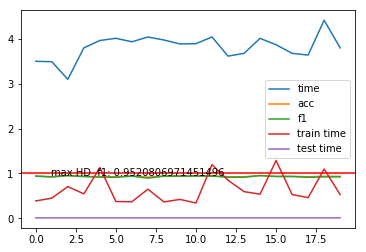

Accuracy: 0.9366972477064219
Dimensions 17000


In [112]:
plt.subplot()
plt.plot(HD_vec_N, HD_time)
plt.plot(HD_vec_N, HD_vec_acc)
plt.plot(HD_vec_N, HD_f1)
plt.plot(HD_vec_N, train_time)
plt.plot(HD_vec_N, test_time)
plt.axhline(y=1.0, color='r', linestyle='-')
plt.legend(['time', 'acc', 'f1', 'train time', 'test time'])
plt.text(max(HD_f1),max(HD_f1),'max HD  f1: ' + str(max(HD_f1)))
# plt.text(max(semHash_f1),max(semHash_f1),'max semhash  f1: ' + str(max(semHash_f1)))
plt.yticks()
plt.show()
print('Accuracy:', np.mean(HD_vec_acc))
print('Dimensions', N_mod)

20
20
20


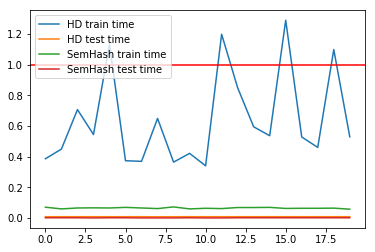

In [108]:
from matplotlib import pyplot as PLT
 
print(len(train_time))
print(len(test_time))
print(len(HD_vec_N))

fig = PLT.figure()
# fig,axes= plt.subplots(nrows=3, ncols=1)


ax1 = fig.add_subplot(111)
# ax1.plot(HD_vec_N, train_time)
# ax1.plot(HD_vec_N, test_time)
ax1.plot(train_time)
ax1.plot(test_time)
ax1.plot(semHash_time_train)
ax1.plot(semHash_time_test)
plt.axhline(y=1.0, color='r', linestyle='-')
plt.legend(['HD train time', 'HD test time', 'SemHash train time', 'SemHash test time'])


# ax2 = fig.add_subplot(212)
# ax2.plot(HD_vec_N, HD_time)
# ax2.plot(HD_vec_N, HD_vec_acc)
# ax2.plot(HD_vec_N, HD_f1)
# plt.axhline(y=1.0, color='r', linestyle='-')

# ax3 = fig.add_subplot(313)
# ax3.plot(HD_vec_N, HD_time)
# ax3.plot(HD_vec_N, HD_vec_acc)
# ax3.plot(HD_vec_N, HD_f1)
# plt.axhline(y=1.0, color='r', linestyle='-')


PLT.show()

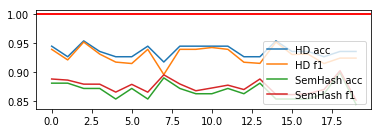

In [109]:
from matplotlib import pyplot as PLT

fig = PLT.figure()
# fig,axes= plt.subplots(nrows=3, ncols=1)

ax2 = fig.add_subplot(212)
# ax2.plot(HD_vec_N, HD_time)
# ax2.plot(HD_vec_N, HD_vec_acc)
# ax2.plot(HD_vec_N, HD_f1)

ax2.plot(HD_vec_acc)
ax2.plot(HD_f1)
ax2.plot(semHash_acc)
ax2.plot(semHash_f1)
plt.axhline(y=1.0, color='r', linestyle='-')
plt.legend(['HD acc', 'HD f1', 'SemHash acc', 'SemHash f1'], loc=4)
# plt.legend()
plt.axhline(y=1.0, color='r', linestyle='-')

# ax3 = fig.add_subplot(313)
# ax3.plot(HD_vec_N, HD_time)
# ax3.plot(HD_vec_N, HD_vec_acc)
# ax3.plot(HD_vec_N, HD_f1)
# plt.axhline(y=1.0, color='r', linestyle='-')

PLT.show()

In [110]:
print(np.average(HD_vec_acc))
print(np.average(HD_f1))
print(np.average(semHash_acc))
print(np.average(semHash_f1))
print(HD_vec_acc)

0.9366972477064219
0.9290704251363803
0.8674311926605505
0.8749137715051873
[0.944954128440367, 0.926605504587156, 0.9541284403669725, 0.9357798165137615, 0.926605504587156, 0.926605504587156, 0.944954128440367, 0.9174311926605505, 0.944954128440367, 0.944954128440367, 0.944954128440367, 0.944954128440367, 0.926605504587156, 0.926605504587156, 0.9541284403669725, 0.9357798165137615, 0.9357798165137615, 0.926605504587156, 0.9357798165137615, 0.9357798165137615]


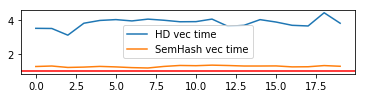

1.2653741743640368


In [111]:
from matplotlib import pyplot as PLT

fig = PLT.figure()
# fig,axes= plt.subplots(nrows=3, ncols=1)

# ax2 = fig.add_subplot(212)
# ax2.plot(HD_vec_N, HD_time)
# ax2.plot(HD_vec_N, HD_vec_acc)
# ax2.plot(HD_vec_N, HD_f1)
# plt.axhline(y=1.0, color='r', linestyle='-')

ax3 = fig.add_subplot(313)
# ax3.plot(HD_vec_N, HD_time)
# ax3.plot(HD_vec_N, HD_vec_acc)
# ax3.plot(HD_vec_N, HD_f1)
ax3.plot(HD_time)
# ax3.plot(HD_vec_acc)
# ax3.plot(HD_f1)

# ax3.plot(semHash_f1)
# ax3.plot(semHash_acc)
ax3.plot(semHash_vec_time)
plt.axhline(y=1.0, color='r', linestyle='-')
# plt.legend(['HD vec time', 'HD acc',  'HD f1', 'SemHash f1', 'SemHash acc', 'SemHash vec time'])
plt.legend(['HD vec time', 'SemHash vec time'])



PLT.show()
print(np.average(semHash_vec_time))

In [91]:
# print(x_train_raw_clean)
X_train_raw = x_train_raw_clean[:]
X_test_raw = x_test_raw_clean[:]


for j in range(1, 100):
    start = timer()
#     for i in range(len(X_train_raw)):
#         print('preHD', X_train_raw[i])
#         X_train_raw[i] = ngram_encode(X_train_raw[i], HD_aphabet, aphabet, j) # HD_ngram is a projection of n-gram statistics for str to N-dimensional space. It can be used to learn the word embedding
#         # print(X_train_raw[:5])
#         print('postHD', X_train_raw[i])
#     for i in range(len(X_test_raw)):
#         print(X_test_raw[1])
#         X_test_raw[i] = ngram_encode(X_test_raw[i], HD_aphabet, aphabet, j)
#     # print(X_test_raw[:5])
#         print(X_test_raw[1])
    
    x_train_with_HD = [ngram_encode(x_to_encode, HD_aphabet, aphabet, j) for x_to_encode in X_train_raw ]
    end = timer()
    print("Time taken:", end-start)
    HD_time.append(end-start)
    HD_vec_N.append(j)
    
    target_names = None
    if benchmark_dataset == "Chatbot":
        target_names = ["Departure Time", "Find Connection"]
    elif benchmark_dataset == "AskUbuntu":
        target_names = ["Make Update", "Setup Printer", "Shutdown Computer","Software Recommendation", "None"]
    elif benchmark_dataset == "WebApplication":
        target_names = ["Download Video", "Change Password", "None", "Export Data", "Sync Accounts",
                  "Filter Spam", "Find Alternative", "Delete Account"]
        
    results = []
    
#     result = benchmark(Pipeline([('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,tol=1e-3))),
#                                   ('classification', LinearSVC(penalty="l2"))]),
#                              X_train, y_train, X_test, y_test, target_names,
#                              feature_names=target_names)
    result =benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty="elasticnet"),
                             X_train, y_train_raw, X_test, y_test_raw, target_names,
                             feature_names=target_names)

    print(f'result {j}')
    HD_f1.append(result[4])
    HD_vec_acc.append(result[1])
#     print("./datasets/KL/" + benchmark_dataset + "/train.csv")
    dataset = MeraDataset("./datasets/KL/" + benchmark_dataset + "/train.csv")
#     print("mera****************************")
    splits = dataset.get_splits()
    xS_train = []
    yS_train = []
    for elem in splits[0]["train"]["X"]:
        xS_train.append(elem)
#         print(xS_train[:5])

    for elem in splits[0]["train"]["y"]:
        yS_train.append(intent_dict[elem])
    
#         print(len(xS_train))

    X_train_raw = xS_train[:]
    X_test_raw = x_test_raw_clean[:]
    
    

Time taken: 0.0167917494327412
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=50, n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.316s
test time:  0.004s
accuracy:   0.872
dimensionality: 3748
density: 0.415048

classification report:
                         precision    recall  f1-score   support

            Make Update       0.94      0.86      0.90        37
          Setup Printer       1.00      1.00      1.00        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.80      0.88      0.83        40
                   None       0.25      0.20      0.22         5

              micro avg       0.87      0.87      0.87       109
              macro avg       0.80      0.79      0.79       109
           weighted avg       0.87      0.87      0.87       109

confusion matrix:
[[32  0  0  5  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  0 35  3]
 [ 0  0  0  4  1]]

result 1
['record screen ?', 'highlight annotate pdf ?', 'worth upgrade 12.04 LTS 13.04', 'upgrade 12.04 64 bit', 'upgrade Ubuntu 14.04.1 14.04.2 ?', 'upgrade Ubuntu 14.04 15.04', 'up

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.290s
test time:  0.004s
accuracy:   0.908
dimensionality: 3748
density: 0.394023

classification report:
                         precision    recall  f1-score   support

            Make Update       0.93      1.00      0.96        37
          Setup Printer       0.87      1.00      0.93        13
      Shutdown Computer       0.93      1.00      0.97        14
Software Recommendation       0.92      0.82      0.87        40
                   None       0.67      0.40      0.50         5

              micro avg       0.91      0.91      0.91       109
              macro avg       0.86      0.85      0.84       109
           weighted avg       0.90      0.91      0.90       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  2  1 33  1]
 [ 0  0  0  3  2]]

result 2
['record screen ?', 'highlight annotate pdf ?', 'worth upgrade 12.04 LTS 13.04', 'upgrade 12.04 64 bit', 'upgrade Ubuntu 14.04.1 14.04.2 ?', 'upgrade Ubuntu 14.04 15.04', 'up

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.352s
test time:  0.004s
accuracy:   0.835
dimensionality: 3748
density: 0.397279

classification report:
                         precision    recall  f1-score   support

            Make Update       1.00      0.73      0.84        37
          Setup Printer       0.72      1.00      0.84        13
      Shutdown Computer       0.93      1.00      0.97        14
Software Recommendation       0.77      0.93      0.84        40
                   None       0.00      0.00      0.00         5

              micro avg       0.83      0.83      0.83       109
              macro avg       0.69      0.73      0.70       109
           weighted avg       0.83      0.83      0.82       109

confusion matrix:
[[27  2  0  8  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 0  1  1 37  1]
 [ 0  2  0  3  0]]

result 3
['record screen ?', 'highlight annotate pdf ?', 'worth upgrade 12.04 LTS 13.04', 'upgrade 12.04 64 bit', 'upgrade Ubuntu 14.04.1 14.04.2 ?', 'upgrade Ubuntu 14.04 15.04', 'up

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.332s
test time:  0.000s
accuracy:   0.908
dimensionality: 3748
density: 0.406990

classification report:
                         precision    recall  f1-score   support

            Make Update       0.95      0.95      0.95        37
          Setup Printer       1.00      1.00      1.00        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.89      0.85      0.87        40
                   None       0.43      0.60      0.50         5

              micro avg       0.91      0.91      0.91       109
              macro avg       0.85      0.88      0.86       109
           weighted avg       0.92      0.91      0.91       109

confusion matrix:
[[35  0  0  2  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  0 34  4]
 [ 0  0  0  2  3]]

result 4
['record screen ?', 'highlight annotate pdf ?', 'worth upgrade 12.04 LTS 13.04', 'upgrade 12.04 64 bit', 'upgrade Ubuntu 14.04.1 14.04.2 ?', 'upgrade Ubuntu 14.04 15.04', 'up

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.336s
test time:  0.004s
accuracy:   0.908
dimensionality: 3748
density: 0.390715

classification report:
                         precision    recall  f1-score   support

            Make Update       0.94      0.89      0.92        37
          Setup Printer       0.93      1.00      0.96        13
      Shutdown Computer       0.93      1.00      0.97        14
Software Recommendation       0.86      0.93      0.89        40
                   None       1.00      0.40      0.57         5

              micro avg       0.91      0.91      0.91       109
              macro avg       0.93      0.84      0.86       109
           weighted avg       0.91      0.91      0.90       109

confusion matrix:
[[33  0  0  4  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  1 37  0]
 [ 0  1  0  2  2]]

result 5
['record screen ?', 'highlight annotate pdf ?', 'worth upgrade 12.04 LTS 13.04', 'upgrade 12.04 64 bit', 'upgrade Ubuntu 14.04.1 14.04.2 ?', 'upgrade Ubuntu 14.04 15.04', 'up

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.332s
test time:  0.004s
accuracy:   0.899
dimensionality: 3748
density: 0.362060

classification report:
                         precision    recall  f1-score   support

            Make Update       0.88      1.00      0.94        37
          Setup Printer       0.87      1.00      0.93        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.92      0.82      0.87        40
                   None       0.50      0.20      0.29         5

              micro avg       0.90      0.90      0.90       109
              macro avg       0.83      0.81      0.80       109
           weighted avg       0.89      0.90      0.89       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 4  2  0 33  1]
 [ 1  0  0  3  1]]

result 6
['record screen ?', 'highlight annotate pdf ?', 'worth upgrade 12.04 LTS 13.04', 'upgrade 12.04 64 bit', 'upgrade Ubuntu 14.04.1 14.04.2 ?', 'upgrade Ubuntu 14.04 15.04', 'up

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.288s
test time:  0.000s
accuracy:   0.908
dimensionality: 3748
density: 0.378015

classification report:
                         precision    recall  f1-score   support

            Make Update       0.93      1.00      0.96        37
          Setup Printer       0.93      1.00      0.96        13
      Shutdown Computer       0.82      1.00      0.90        14
Software Recommendation       0.94      0.82      0.88        40
                   None       0.67      0.40      0.50         5

              micro avg       0.91      0.91      0.91       109
              macro avg       0.86      0.85      0.84       109
           weighted avg       0.91      0.91      0.90       109

confusion matrix:
[[37  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  1  2 33  1]
 [ 0  0  1  2  2]]

result 7
['record screen ?', 'highlight annotate pdf ?', 'worth upgrade 12.04 LTS 13.04', 'upgrade 12.04 64 bit', 'upgrade Ubuntu 14.04.1 14.04.2 ?', 'upgrade Ubuntu 14.04 15.04', 'up

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.316s
test time:  0.000s
accuracy:   0.890
dimensionality: 3748
density: 0.407311

classification report:
                         precision    recall  f1-score   support

            Make Update       0.88      0.97      0.92        37
          Setup Printer       1.00      1.00      1.00        13
      Shutdown Computer       0.82      1.00      0.90        14
Software Recommendation       0.92      0.85      0.88        40
                   None       0.00      0.00      0.00         5

              micro avg       0.89      0.89      0.89       109
              macro avg       0.72      0.76      0.74       109
           weighted avg       0.86      0.89      0.87       109

confusion matrix:
[[36  0  0  1  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 4  0  1 34  1]
 [ 1  0  2  2  0]]

result 8
['record screen ?', 'highlight annotate pdf ?', 'worth upgrade 12.04 LTS 13.04', 'upgrade 12.04 64 bit', 'upgrade Ubuntu 14.04.1 14.04.2 ?', 'upgrade Ubuntu 14.04 15.04', 'up

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.296s
test time:  0.000s
accuracy:   0.872
dimensionality: 3748
density: 0.346958

classification report:
                         precision    recall  f1-score   support

            Make Update       0.94      0.86      0.90        37
          Setup Printer       1.00      1.00      1.00        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.80      0.88      0.83        40
                   None       0.25      0.20      0.22         5

              micro avg       0.87      0.87      0.87       109
              macro avg       0.80      0.79      0.79       109
           weighted avg       0.87      0.87      0.87       109

confusion matrix:
[[32  0  0  5  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 2  0  0 35  3]
 [ 0  0  0  4  1]]

result 9
['record screen ?', 'highlight annotate pdf ?', 'worth upgrade 12.04 LTS 13.04', 'upgrade 12.04 64 bit', 'upgrade Ubuntu 14.04.1 14.04.2 ?', 'upgrade Ubuntu 14.04 15.04', 'up

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.340s
test time:  0.004s
accuracy:   0.908
dimensionality: 3748
density: 0.407097

classification report:
                         precision    recall  f1-score   support

            Make Update       0.92      0.95      0.93        37
          Setup Printer       1.00      1.00      1.00        13
      Shutdown Computer       0.93      1.00      0.97        14
Software Recommendation       0.88      0.88      0.88        40
                   None       0.67      0.40      0.50         5

              micro avg       0.91      0.91      0.91       109
              macro avg       0.88      0.84      0.85       109
           weighted avg       0.90      0.91      0.90       109

confusion matrix:
[[35  0  0  2  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  0  1 35  1]
 [ 0  0  0  3  2]]

result 10
['record screen ?', 'highlight annotate pdf ?', 'worth upgrade 12.04 LTS 13.04', 'upgrade 12.04 64 bit', 'upgrade Ubuntu 14.04.1 14.04.2 ?', 'upgrade Ubuntu 14.04 15.04', 'u

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.269s
test time:  0.000s


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.908
dimensionality: 3748
density: 0.356617

classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.92      0.97      0.95        37
          Setup Printer       1.00      1.00      1.00        13
      Shutdown Computer       0.93      1.00      0.97        14
Software Recommendation       0.86      0.90      0.88        40
                   None       0.00      0.00      0.00         5

              micro avg       0.91      0.91      0.91       109
              macro avg       0.74      0.77      0.76       109
           weighted avg       0.87      0.91      0.89       109

confusion matrix:
[[36  0  0  1  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  0  1 36  0]
 [ 0  0  0  5  0]]

result 11
['record screen ?', 'highlight annotate pdf ?', 'worth upgrade 12.04 LTS 13.04', 'upgrade 12.04 64 bit', 'upgrade Ubuntu 14.04.1 14.04.2 ?', 'upgrade Ubuntu 14.04 15.04', 'upgrade ubuntu 15.04 15.10 ?', 'upgrade 12.04 12.10 startup disk', 'upgrade 11.10 12.04 get problem ?', 'update 11.04 12

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.296s
test time:  0.012s
accuracy:   0.927
dimensionality: 3748
density: 0.385272

classification report:
                         precision    recall  f1-score   support

            Make Update       0.92      0.97      0.95        37
          Setup Printer       0.93      1.00      0.96        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.90      0.90      0.90        40
                   None       1.00      0.40      0.57         5

              micro avg       0.93      0.93      0.93       109
              macro avg       0.95      0.85      0.88       109
           weighted avg       0.93      0.93      0.92       109

confusion matrix:
[[36  0  0  1  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  1  0 36  0]
 [ 0  0  0  3  2]]

result 12
['record screen ?', 'highlight annotate pdf ?', 'worth upgrade 12.04 LTS 13.04', 'upgrade 12.04 64 bit', 'upgrade Ubuntu 14.04.1 14.04.2 ?', 'upgrade Ubuntu 14.04 15.04', 'u

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.285s
test time:  0.004s
accuracy:   0.917
dimensionality: 3748
density: 0.442156

classification report:
                         precision    recall  f1-score   support

            Make Update       0.90      0.97      0.94        37
          Setup Printer       1.00      0.92      0.96        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.88      0.93      0.90        40
                   None       1.00      0.20      0.33         5

              micro avg       0.92      0.92      0.92       109
              macro avg       0.96      0.80      0.83       109
           weighted avg       0.92      0.92      0.91       109

confusion matrix:
[[36  0  0  1  0]
 [ 1 12  0  0  0]
 [ 0  0 14  0  0]
 [ 3  0  0 37  0]
 [ 0  0  0  4  1]]

result 13
['record screen ?', 'highlight annotate pdf ?', 'worth upgrade 12.04 LTS 13.04', 'upgrade 12.04 64 bit', 'upgrade Ubuntu 14.04.1 14.04.2 ?', 'upgrade Ubuntu 14.04 15.04', 'u

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.309s
test time:  0.004s
accuracy:   0.890
dimensionality: 3748
density: 0.435699

classification report:
                         precision    recall  f1-score   support

            Make Update       0.97      0.86      0.91        37
          Setup Printer       0.87      1.00      0.93        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.83      0.95      0.88        40
                   None       0.00      0.00      0.00         5

              micro avg       0.89      0.89      0.89       109
              macro avg       0.73      0.76      0.75       109
           weighted avg       0.86      0.89      0.87       109

confusion matrix:
[[32  1  0  4  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 1  0  0 38  1]
 [ 0  1  0  4  0]]

result 14
['record screen ?', 'highlight annotate pdf ?', 'worth upgrade 12.04 LTS 13.04', 'upgrade 12.04 64 bit', 'upgrade Ubuntu 14.04.1 14.04.2 ?', 'upgrade Ubuntu 14.04 15.04', 'u

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.278s
test time:  0.004s


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:   0.917
dimensionality: 3748
density: 0.412433

classification report:


C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Make Update       0.92      0.97      0.95        37
          Setup Printer       1.00      1.00      1.00        13
      Shutdown Computer       1.00      1.00      1.00        14
Software Recommendation       0.86      0.93      0.89        40
                   None       0.00      0.00      0.00         5

              micro avg       0.92      0.92      0.92       109
              macro avg       0.76      0.78      0.77       109
           weighted avg       0.88      0.92      0.90       109

confusion matrix:
[[36  0  0  1  0]
 [ 0 13  0  0  0]
 [ 0  0 14  0  0]
 [ 3  0  0 37  0]
 [ 0  0  0  5  0]]

result 15
['record screen ?', 'highlight annotate pdf ?', 'worth upgrade 12.04 LTS 13.04', 'upgrade 12.04 64 bit', 'upgrade Ubuntu 14.04.1 14.04.2 ?', 'upgrade Ubuntu 14.04 15.04', 'upgrade ubuntu 15.04 15.10 ?', 'upgrade 12.04 12.10 startup disk', 'upgrade 11.10 12.04 get problem ?', 'update 11.04 12

C:\Users\pedalo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:130: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


train time: 0.305s
test time:  0.000s
accuracy:   0.899
dimensionality: 3748
density: 0.410245

classification report:
                         precision    recall  f1-score   support

            Make Update       0.84      1.00      0.91        37
          Setup Printer       1.00      0.92      0.96        13
      Shutdown Computer       0.93      1.00      0.97        14
Software Recommendation       0.97      0.80      0.88        40
                   None       0.60      0.60      0.60         5

              micro avg       0.90      0.90      0.90       109
              macro avg       0.87      0.86      0.86       109
           weighted avg       0.91      0.90      0.90       109

confusion matrix:
[[37  0  0  0  0]
 [ 1 12  0  0  0]
 [ 0  0 14  0  0]
 [ 5  0  1 32  2]
 [ 1  0  0  1  3]]

result 16
['record screen ?', 'highlight annotate pdf ?', 'worth upgrade 12.04 LTS 13.04', 'upgrade 12.04 64 bit', 'upgrade Ubuntu 14.04.1 14.04.2 ?', 'upgrade Ubuntu 14.04 15.04', 'u

Warning: String is less than n-gram size

In [ ]:
# HD_vec_acc.append(0.7706422018348624)
# print(x_train_raw_clean)
print(len(HD_time))
print(len(HD_vec_N))
print(len(HD_f1))
print(len(HD_vec_acc))


In [ ]:
plt.plot(HD_vec_N, HD_time)
plt.plot(HD_vec_N, HD_vec_acc)
plt.plot(HD_vec_N, HD_f1)
plt.legend(['time', 'acc', 'f1'])
plt.show()